# <h1 style="color:red;">Initial Setup</h>

Import all necessary modules

In [2]:
import nest_asyncio
import asyncio
import schwabdev
from datetime import datetime, timedelta
from dotenv import load_dotenv
import time
import os
import json
import pandas as pd
import pytz
import numpy as np
import mplfinance as mpf
from IPython.display import display, clear_output
import warnings
from Multi_Strat_Back_Tester_Functions import *
from datetime import datetime, time
import matplotlib.pyplot as plt
from itertools import product
import copy

Load environment variables from .env file for authentification purposes

In [3]:
load_dotenv()

True

Patches the notebook's running event loop so that it can handle multiple calls to `asyncio.run()` or other asynchronous methods without causing conflicts

In [4]:
nest_asyncio.apply()

Set the display options

In [5]:
# Display options
# Set the global float format to 4 decimal places
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
pd.options.display.float_format = '{:,.4f}'.format # Format numerical output to have certain number of decimals
# pd.options.display.float_format = None # Reset to default numerical output formatting
pd.set_option('display.width', 2000) # Set the display width to a large number
pd.set_option('display.max_colwidth', 1000) # Set max column width to a large number

pd.set_option('display.max_columns', None) # Displays all columns
# pd.set_option('display.max_rows', None) # Displays all rows                             
# pd.reset_option('display.max_columns') # Display default abbreviated columns
pd.reset_option('display.max_rows') # Display default abbreviated rows

Create the client object.

In [6]:
app_key = os.getenv('app_key')
app_secret = os.getenv('app_secret')
callback_url = os.getenv('callback_url')

# Print them to verify (avoid printing sensitive info in production)
print(f"App Key: {app_key}")
print(f"App Secret: {app_secret}")
print(f"Callback URL: {callback_url}")

# Now proceed to initialize the client
client = schwabdev.Client(app_key, app_secret, callback_url)
print('Client initialized!')

App Key: 2C7Jh6zt5QdlSb0N5RnhWpaiEzKFr150
App Secret: OQGxH0GkD5bAEMA4
Callback URL: https://127.0.0.1
Client initialized!


The refresh token has expired, please update!
Open to authenticate: https://api.schwabapi.com/v1/oauth/authorize?client_id=2C7Jh6zt5QdlSb0N5RnhWpaiEzKFr150&redirect_uri=https://127.0.0.1
After authorizing, paste the address bar url here: 

Use this when in need of updating the refresh token.

In [7]:
# client.update_tokens(force=True)
# client = schwabdev.Client(app_key, app_secret, callback_url)

# <h1 style="color:red;">Permanent Data Extraction and Storage Functions</h>

Ticker list and point value definition.

In [8]:
tickers = "/ES,/NQ,/CL,/GC"
# tickers = "MARA,PLUG,SOFI,SWN,RKLB"

ticker_to_point_value = {
    "/ES": 50,       # E-Mini S&P 500
    "/NQ": 20,       # E-Mini NASDAQ 100
    "/CL": 1000,     # Crude Oil
    "/GC": 100,      # Gold
}

ticker_to_tick_size = {
    "/ES": 0.25,        # E-Mini S&P 500
    "/NQ": 0.25,        # E-Mini NASDAQ 100
    "/CL": 0.01,        # Crude Oil
    "/GC": 0.1,         # Gold
}

tick_size = ticker_to_tick_size.get("/ES")
tick_size

0.25

In [9]:
# tickers = "/ES,/NQ,/CL,/GC,/MES,/MNQ,/MCL,/MGC"
# # tickers = "MARA,PLUG,SOFI,SWN,RKLB"

# ticker_to_point_value = {
#     "/ES": 50,       # E-Mini S&P 500
#     "/NQ": 20,       # E-Mini NASDAQ 100
#     "/CL": 1000,     # Crude Oil
#     "/GC": 100,      # Gold
#     "/MES": 5,       # Micro E-Mini S&P 500
#     "/MNQ": 2,       # Micro E-Mini NASDAQ 100
#     "/MCL": 100,     # Micro Crude Oil
#     "/MGC": 10       # Micro Gold
# }

# ticker_to_tick_size = {
#     "/ES": 0.25,        # E-Mini S&P 500
#     "/NQ": 0.25,        # E-Mini NASDAQ 100
#     "/CL": 0.01,        # Crude Oil
#     "/GC": 0.1,         # Gold
#     "/MES": 0.25,       # Micro E-Mini S&P 500
#     "/MNQ": 0.25,       # Micro E-Mini NASDAQ 100
#     "/MCL": 0.01,       # Micro Crude Oil
#     "/MGC": 0.1         # Micro Gold
# }

# tick_size = ticker_to_tick_size.get("/ES")
# tick_size

Extracting and storing raw streaming data with two functions into ticker_tables dictionary. 

In [10]:
def extract_row_data(entry, content):
    
    # Create a row dictionary with the relevant fields
    row = { # For futures
        'timestamp': entry['timestamp'],
        'key': content.get('key', None),
        'bid_price': content.get('1', None),
        'ask_price': content.get('2', None),
        # 'last_price': last_price,  # Use updated last_price
        'last_price': content.get('3', None),
        'bid_size': content.get('4', None), # These two variables can be correlated 
        'ask_size': content.get('5', None), # with direction of price action
        'total_volume': content.get('8', None),
        'last_size': content.get('9', 0),
        'high_price': content.get('12', None),
        'low_price': content.get('13', None),
        'close_price': content.get('14', None),
        'open_price': content.get('18', None),
        'net_change': content.get('19', None),
        'future_pct_change': content.get('20', None),
        'open_interest': content.get('23', None),
        'tick': content.get('25', None),
        'tick_amount': content.get('26', None),
        'future_exp_date': content.get('35', None),
        'ask_time': content.get('37', None),
        'bid_time': content.get('38', None)
        }

    # row = { # For equities
    #     'timestamp': entry['timestamp'],               # Same
    #     'key': content.get('key', None),               # Same
    #     'bid_price': content.get('1', None),           # Matches bid_price
    #     'ask_price': content.get('2', None),           # Matches ask_price
    #     'last_price': last_price,                      # Matches last_price (updated)
    #     'bid_size': content.get('4', None),            # Matches bid_size
    #     'ask_size': content.get('5', None),            # Matches ask_size
    #     'total_volume': content.get('8', None),        # Matches total_volume
    #     'last_size': content.get('9', 0),              # Matches last_size
    #     'high_price': content.get('10', None),         # Matches high_price
    #     'low_price': content.get('11', None),          # Matches low_price
    #     'close_price': content.get('12', None),        # Matches close_price
    #     'open_price': content.get('17', None),         # Matches open_price
    #     'net_change': content.get('18', None),         # Matches net_change
    #     '52_week_high': content.get('19', None),       # Matches 52_week_high
    #     '52_week_low': content.get('20', None),        # Matches 52_week_low
    #     'pe_ratio': content.get('21', None),           # Matches pe_ratio
    #     'net_pct_change': content.get('42', None)}      # Matches net_pct_change  
    
    return row


In [11]:
ticker_tables = 'nothing'
ticker_tables = {ticker: pd.DataFrame() for ticker in tickers.split(",")}

# Initialize a dictionary to store the last known price for each ticker
last_known_price = {ticker: None for ticker in tickers.split(",")}

def process_message_data(data):
    global ticker_tables, last_known_price
    
    # Loop through the content and extract the relevant fields
    if "data" in data:
        for entry in data['data']:
            if 'content' in entry:
                for content in entry['content']:
                    # Extract row data
                    row = extract_row_data(entry, content)

                    # Get the ticker (key) and last_price
                    ticker = row['key']
                    last_price = row.get('last_price')

                    # Check if last_price is None, if so use the last known price for the ticker
                    if last_price is None and ticker in last_known_price:
                        row['last_price'] = last_known_price[ticker]
                    else:
                        # Update the last known price
                        last_known_price[ticker] = last_price

                    # Convert the row dictionary to a DataFrame
                    row_df = pd.DataFrame([row])

                    # Check the ticker and append the row to the correct ticker table
                    if ticker in ticker_tables:
                        ticker_tables[ticker] = pd.concat([ticker_tables[ticker], row_df], ignore_index=True)

Compressing minute candles from the raw data.

In [12]:
minute_candles = 'nothing'
minute_candles = {ticker: pd.DataFrame(columns=['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']) for ticker in tickers.split(",")}

def update_minute_candles(ticker_tables, time_frame='min'):
    global minute_candles

    for ticker, df in ticker_tables.items():
        if df.empty:
            continue
        
        # Ensure that 'datetime' column exists and is properly set
        if 'timestamp' in df.columns:
            df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('US/Eastern')

        # Ensure that the 'datetime' column is set as the DataFrame index (only if not already set)
        if df.index.name != 'datetime':
            df.set_index('datetime', inplace=True)

        # Group the data by minute intervals using 'min'
        current_minute = df.index.floor(time_frame)[-1]  # Get the most recent minute

        # Select only the rows from the most recent minute
        recent_data = df[df.index.floor(time_frame) == current_minute]

        if not recent_data.empty:
            # Extract OHLC values for the minute candle
            open_price = recent_data['last_price'].iloc[0]  # Open is the first last_price
            high_price = recent_data['last_price'].max()     # High is the max last_price
            low_price = recent_data['last_price'].min()      # Low is the min last_price
            close_price = recent_data['last_price'].iloc[-1] # Close is the last last_price
            total_volume = recent_data['total_volume'].max() # Total volume is the max value in this interval

            # Create a dictionary with the new candle data
            new_candle = {
                'datetime': current_minute,
                'ticker': ticker,
                'open': open_price,
                'high': high_price,
                'low': low_price,
                'close': close_price,
                'accumulative_volume': total_volume
            }

            # Convert the dictionary to a DataFrame and update the respective ticker's DataFrame in minute_candles
            new_candle_df = pd.DataFrame([new_candle])

            # Replace or append the most recent candle for this ticker
            if not minute_candles[ticker].empty and minute_candles[ticker]['datetime'].iloc[-1] == current_minute:
                minute_candles[ticker].iloc[-1] = new_candle  # Update the last candle
            else:
                minute_candles[ticker] = pd.concat([minute_candles[ticker], new_candle_df], ignore_index=True)  # Append new candle

Defining a function to calculate a price action envelope indicator for trend determination.

In [13]:
def calculate_price_action_envelope(df, high_col='high', low_col='low', window=5):
    """
    Calculate the continuous higher highs, higher lows, lower highs, and lower lows
    to create an envelope that wraps around the price action.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the price data.
    high_col (str): The column name for the high prices (default 'high').
    low_col (str): The column name for the low prices (default 'low').
    window (int): The window size for detecting local highs and lows (default 5).
    
    Returns:
    pd.DataFrame: The DataFrame with added columns for the price action envelope.
    """
    # Calculate rolling max (higher highs) and rolling min (lower lows)
    df['higher_high'] = df[high_col].rolling(window=window, min_periods=1).max()
    df['lower_low'] = df[low_col].rolling(window=window, min_periods=1).min()
    
    # Calculate rolling min of high for higher lows, and rolling max of low for lower highs
    df['higher_low'] = df[low_col].rolling(window=window, min_periods=1).min().cummax()
    df['lower_high'] = df[high_col].rolling(window=window, min_periods=1).max().cummin()
    
    # Create the envelope by combining these calculated values
    df['price_action_upper'] = df[['higher_high', 'lower_high']].max(axis=1)
    df['price_action_lower'] = df[['lower_low', 'higher_low']].min(axis=1)
    
    # Drop intermediate columns if not needed
    df.drop(columns=['higher_high', 'lower_low', 'higher_low', 'lower_high'], inplace=True)

    # Add moving averages for price_action_upper and price_action_lower
    ma_period = window  # Set the moving average period length to 5
    df['ma_price_action_upper'] = df['price_action_upper'].rolling(window=ma_period, min_periods=1).mean()
    df['ma_price_action_lower'] = df['price_action_lower'].rolling(window=ma_period, min_periods=1).mean()

    # Define a function to calculate trend score for an entire column over a 5-period window
    def calculate_trend_score(col_series):
        score_series = []
        for i in range(len(col_series)):
            score = 0
            for j in range(1, window):
                if i - j >= 0:
                    if col_series.iloc[i] > col_series.iloc[i - j]:
                        score += 10
                    elif col_series.iloc[i] < col_series.iloc[i - j]:
                        score -= 10
            score_series.append(score)
        return score_series

    # Calculate the trend indicator score for each relevant column and combine them
    scores_upper = calculate_trend_score(df['price_action_upper'])
    scores_lower = calculate_trend_score(df['price_action_lower'])

    # Sum the scores for the final trend indicator based only on price_action_upper and price_action_lower
    total_score = [u + l for u, l in zip(scores_upper, scores_lower)]

    # Rescale total_score to a 0-100 range and assign to 'trend_indicator'
    df['trend_indicator'] = [(score + 100) / 2 for score in total_score]

    return df

A function that calculates a number of indicators.

In [14]:
def calculate_indicators(df, price_col='close', acc_vol_col='accumulative_volume', sma_periods=None, wma_periods=None, rsi_periods=None, volume_col='volume', candle_window=10):
    """
    Calculate SMAs and WMAs for given periods and append them to the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the price data.
    price_col (str): The column name for the price data (default 'close').
    acc_vol_col (str): The column name for the accumulative volume data (default 'accumulative_volume').
    sma_periods (list): A list of periods for SMAs (e.g., [3, 5, 10, 20]).
    wma_periods (list): A list of periods for WMAs (e.g., [3, 5, 10, 20]).
    volume_col (str): The column name to store the volume difference (default 'volume').
    
    Returns:
    pd.DataFrame: The DataFrame with the calculated SMAs and WMAs appended.
    """
    # Calculate volume differences
    df[volume_col] = df[acc_vol_col].diff()
    
    # Calculate SMAs
    if sma_periods:
        for period in sma_periods:
            sma_col_name = f'sma_{period}'
            df[sma_col_name] = df[price_col].rolling(window=period).mean()
    
    # Calculate WMAs
    if wma_periods:
        for period in wma_periods:
            weights = np.arange(1, period + 1)  # Generate weights from 1 to the period length
            wma_col_name = f'wma_{period}'
            df[wma_col_name] = df[price_col].rolling(window=period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)

    # calculate_vwap_and_bands(df, high_col='high', low_col='low', close_col='close', volume_col='volume')

    # Assume 'periods' is a predefined list of different periods for which you want to calculate RSI
    for period in rsi_periods:
        # Calculate RSI for each period
        delta = df[price_col].diff()
        gain = delta.where(delta > 0, 0).rolling(window=period).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
        rs = gain / loss
        df[f'rsi_{period}'] = 100 - (100 / (1 + rs))

    # Calculate price action envelope
    df = calculate_price_action_envelope(df, high_col='high', low_col='low', window=5)

    df['ohlc_average'] = df[['open', 'high', 'low', 'close']].mean(axis=1)
    df['candle_span'] = df['high'] - df['low']
    df['candle_body'] = (df['close'] - df['open']).abs()
    df['candle_span_avg'] = df['candle_span'].rolling(window=candle_window, min_periods=1).mean()
    df['candle_span_max'] = df['candle_span'].rolling(window=candle_window, min_periods=1).max()
    df['candle_span_maxavg_mean'] =(df['candle_span_avg'] + df['candle_span_max'])/2
    df['hundred_line'] = 100
    df['fifty_line'] = 50
    df['zero_line'] = 0
    df['trend_high_threshold'] = 75
    df['trend_low_threshold'] = 25

    return df

# <h1 style="color:red;">Milestone Branch of Trade Logic and Visualization Functions</h>

In [15]:
def generate_trading_signals(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5'):
    """ Vectorized without iterrows
    Generate buy/sell signals based on moving averages and RSI indicators and save position states.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.

    Returns:
    - candles (pd.DataFrame): The DataFrame with updated signal and position state columns.
    """
    # Dynamically generate signal column names
    ma_signal_column = f'signal_{ma_name1}_{ma_name2}'
    rsi_signal_column = f'signal_{rsi_column}'
    ma_position_open_col = f'position_open_{ma_name1}_{ma_name2}'
    rsi_position_open_col = f'position_open_{rsi_column}'

    # Initialize signal and position state columns
    candles[ma_signal_column] = 0
    candles[rsi_signal_column] = 0
    candles[ma_position_open_col] = False
    candles[rsi_position_open_col] = False

    # Moving average signal and position state generation
    ma_position_open = False  # Local variable for tracking state
    ma_signals = []
    ma_positions = []
    for ma1, ma2 in zip(candles[ma_name1], candles[ma_name2]):
        if not ma_position_open and ma1 <= ma2:
            ma_position_open = True
            ma_signals.append(1)
        elif ma_position_open and ma1 > ma2:
            ma_position_open = False
            ma_signals.append(0)
        else:
            ma_signals.append(ma_signals[-1] if ma_signals else 0)
        ma_positions.append(ma_position_open)
    candles[ma_signal_column] = ma_signals
    candles[ma_position_open_col] = ma_positions

    # RSI signal and position state generation
    rsi_position_open = False  # Local variable for tracking state
    rsi_signals = []
    rsi_positions = []
    for rsi in candles[rsi_column]:
        if not rsi_position_open and rsi < 50:
            rsi_position_open = True
            rsi_signals.append(1)
        elif rsi_position_open and rsi >= 50:
            rsi_position_open = False
            rsi_signals.append(0)
        else:
            rsi_signals.append(rsi_signals[-1] if rsi_signals else 0)
        rsi_positions.append(rsi_position_open)
    candles[rsi_signal_column] = rsi_signals
    candles[rsi_position_open_col] = rsi_positions

    return candles

def update_position_open(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5'):
    """
    Update the 'ma_position_open' and 'rsi_position_open' columns for a given DataFrame.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing the signals and position columns.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI signal.

    Returns:
    - pd.DataFrame: The updated DataFrame with 'ma_position_open' and 'rsi_position_open' columns.
    """
    # Dynamically generate signal column names
    ma_signal_column = f'signal_{ma_name1}_{ma_name2}'
    rsi_signal_column = f'signal_{rsi_column}'
    ma_position_open = f'position_open_{ma_name1}_{ma_name2}'
    rsi_position_open = f'position_open_{rsi_column}'
    
    # Update position open columns
    candles[ma_position_open] = candles[ma_signal_column] == 1
    candles[rsi_position_open] = candles[rsi_signal_column] == 1
    
    return candles

def determine_entry_prices(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', ticker_to_tick_size=None, ticker=None):
    """
    Determine entry prices for MA and RSI strategies based on signals.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.
    - ticker_to_tick_size (dict): Mapping of tickers to their tick sizes.
    - ticker (str): The ticker for which the tick size applies.

    Returns:
    - candles (pd.DataFrame): The DataFrame with updated entry price columns.
    """
    # Dynamically generate column names
    ma_signal_column = f'signal_{ma_name1}_{ma_name2}'
    rsi_signal_column = f'signal_{rsi_column}'
    ma_entry_price = f'entry_price_{ma_name1}_{ma_name2}'
    rsi_entry_price = f'entry_price_{rsi_column}'

    # Initialize entry price columns
    candles[ma_entry_price] = None
    candles[rsi_entry_price] = None

    # Get tick size
    tick_size = ticker_to_tick_size.get(ticker, 0) if ticker_to_tick_size else 0

    # Moving Average Strategy
    ma_signals = candles[ma_signal_column]
    ma_close_prices = candles['close']
    ma_entry_mask = (ma_signals == 1) & (ma_signals.shift(1) != 1)
    candles.loc[ma_entry_mask, ma_entry_price] = ma_close_prices[ma_entry_mask] + tick_size

    # RSI Strategy
    rsi_signals = candles[rsi_signal_column]
    rsi_entry_mask = (rsi_signals == 1) & (rsi_signals.shift(1) != 1)
    candles.loc[rsi_entry_mask, rsi_entry_price] = ma_close_prices[rsi_entry_mask] + tick_size

    return candles

def determine_exit_prices(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', ticker_to_tick_size=None, ticker=None):
    """
    Determine exit prices for MA and RSI strategies based on signals.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.
    - ticker_to_tick_size (dict): Mapping of tickers to their tick sizes.
    - ticker (str): The ticker for which the tick size applies.

    Returns:
    - candles (pd.DataFrame): The DataFrame with updated exit price columns.
    """
    # Dynamically generate column names
    ma_signal_column = f'signal_{ma_name1}_{ma_name2}'
    rsi_signal_column = f'signal_{rsi_column}'
    ma_exit_price = f'exit_price_{ma_name1}_{ma_name2}'
    rsi_exit_price = f'exit_price_{rsi_column}'

    # Initialize exit price columns
    candles[ma_exit_price] = None
    candles[rsi_exit_price] = None

    # Get tick size
    tick_size = ticker_to_tick_size.get(ticker, 0) if ticker_to_tick_size else 0

    # Moving Average Strategy
    ma_signals = candles[ma_signal_column]
    ma_close_prices = candles['close']
    ma_exit_mask = (ma_signals == 0) & (ma_signals.shift(1) == 1)
    candles.loc[ma_exit_mask, ma_exit_price] = ma_close_prices[ma_exit_mask] - tick_size

    # RSI Strategy
    rsi_signals = candles[rsi_signal_column]
    rsi_exit_mask = (rsi_signals == 0) & (rsi_signals.shift(1) == 1)
    candles.loc[rsi_exit_mask, rsi_exit_price] = ma_close_prices[rsi_exit_mask] - tick_size

    return candles

def calculate_stop_losses(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5'):
    """
    Dynamically calculate stop loss levels for MA and RSI strategies and ensure they persist while positions are open.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.

    Returns:
    - pd.DataFrame: The updated DataFrame with dynamically named stop loss columns.
    """
    # Dynamically generate column names
    ma_entry_price = f'entry_price_{ma_name1}_{ma_name2}'
    ma_exit_price = f'exit_price_{ma_name1}_{ma_name2}'
    rsi_entry_price = f'entry_price_{rsi_column}'
    rsi_exit_price = f'exit_price_{rsi_column}'
    stop_loss_ma = f'stop_loss_{ma_name1}_{ma_name2}'
    stop_loss_rsi = f'stop_loss_{rsi_column}'

    # Initialize stop loss columns
    candles[stop_loss_ma] = None
    candles[stop_loss_rsi] = None

    # Moving Average Stop Loss
    ma_entry_mask = candles[ma_entry_price].notnull()
    ma_exit_mask = candles[ma_exit_price].notnull()
    
    # Set stop loss where positions open
    candles.loc[ma_entry_mask, stop_loss_ma] = candles[ma_entry_price] - candles['candle_span_max']

    # Reset stop loss and close position where positions close
    candles.loc[ma_exit_mask, stop_loss_ma] = None

    # RSI Stop Loss
    rsi_entry_mask = candles[rsi_entry_price].notnull()
    rsi_exit_mask = candles[rsi_exit_price].notnull()
    
    # Set stop loss where positions open
    candles.loc[rsi_entry_mask, stop_loss_rsi] = candles[rsi_entry_price] - candles['candle_span_max']

    # Reset stop loss and close position where positions close
    candles.loc[rsi_exit_mask, stop_loss_rsi] = None

    # Forward-fill stop loss for both strategies
    candles[stop_loss_ma] = candles[stop_loss_ma].ffill()
    candles[stop_loss_rsi] = candles[stop_loss_rsi].ffill()

    return candles

def track_stop_loss_hits(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', ticker_to_tick_size=None, ticker=None): # Tick size is not being used, address this here and in the function calling
    """
    Track whether stop losses have been hit for MA and RSI strategies and update dynamically named columns.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.
    - ticker_to_tick_size (dict): Mapping of tickers to their tick sizes.
    - ticker (str): The ticker for which the tick size applies.

    Returns:
    - pd.DataFrame: The updated DataFrame with dynamically named stop loss hit flags.
    """
    # Dynamically generate column names
    stop_loss_ma = f'stop_loss_{ma_name1}_{ma_name2}'
    stop_loss_rsi = f'stop_loss_{rsi_column}'
    ma_stop_loss_hit = f'stop_loss_hit_{ma_name1}_{ma_name2}'
    rsi_stop_loss_hit = f'stop_loss_hit_{rsi_column}'
    ma_position_open = f'position_open_{ma_name1}_{ma_name2}'
    rsi_position_open = f'position_open_{rsi_column}'
    
    # Initialize stop loss hit columns
    candles[ma_stop_loss_hit] = False
    candles[rsi_stop_loss_hit] = False

    # Get tick size
    tick_size = ticker_to_tick_size.get(ticker, 0) if ticker_to_tick_size else 0

    # Ensure stop loss values are numerical (convert None to NaN)
    candles[stop_loss_ma] = candles[stop_loss_ma].fillna(float('inf'))
    candles[stop_loss_rsi] = candles[stop_loss_rsi].fillna(float('inf'))

    # Moving Average Stop Loss Hit Logic
    ma_hit_condition = (candles[stop_loss_ma].notnull()) & (candles['close'] <= candles[stop_loss_ma]) & candles[ma_position_open]
    candles.loc[ma_hit_condition, ma_stop_loss_hit] = True

    # RSI Stop Loss Hit Logic
    rsi_hit_condition = (candles[stop_loss_rsi].notnull()) & (candles['close'] <= candles[stop_loss_rsi]) & candles[rsi_position_open]
    candles.loc[rsi_hit_condition, rsi_stop_loss_hit] = True

    return candles

def adjust_signals_for_stop_loss(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5'):
    """
    Adjust MA and RSI signals to 0 where stop loss has been hit.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.

    Returns:
    - pd.DataFrame: The updated DataFrame with adjusted signals.
    """
    # Dynamically generate column names
    ma_signal_column = f'signal_{ma_name1}_{ma_name2}'
    rsi_signal_column = f'signal_{rsi_column}'
    ma_stop_loss_hit_column = f'stop_loss_hit_{ma_name1}_{ma_name2}'
    rsi_stop_loss_hit_column = f'stop_loss_hit_{rsi_column}'

    # Adjust MA and RSI signals where stop loss has been hit
    candles.loc[candles[ma_stop_loss_hit_column], ma_signal_column] = 0
    candles.loc[candles[rsi_stop_loss_hit_column], rsi_signal_column] = 0

    return candles

def update_stop_loss(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5'):
    """
    Dynamically set stop loss columns to NaN where corresponding signal columns are 0.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.

    Returns:
    - pd.DataFrame: The updated DataFrame with dynamically named stop loss columns modified.
    """
    # Dynamically generate column names
    ma_signal_column = f'signal_{ma_name1}_{ma_name2}'
    rsi_signal_column = f'signal_{rsi_column}'
    stop_loss_ma = f'stop_loss_{ma_name1}_{ma_name2}'
    stop_loss_rsi = f'stop_loss_{rsi_column}'

    # Update stop loss columns to NaN where signals are 0
    candles.loc[candles[ma_signal_column] == 0, stop_loss_ma] = float('nan')
    candles.loc[candles[rsi_signal_column] == 0, stop_loss_rsi] = float('nan')

    return candles

def calculate_profit_loss(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', contract_multiplier=1, trade_commission=1.5):
    """ 
    Dynamically calculate profit and loss based on entry and exit price columns, including cumulative commission costs.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data with entry and exit price columns.
    - multiplier (float): The multiplier for PnL calculation (e.g., contract size).
    - trade_commission (float): The commission cost per trade.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.

    Returns:
    - pd.DataFrame: The DataFrame with dynamically named profit/loss and commission cost columns.
    """
    # Dynamically generate column names
    ma_entry_price = f'entry_price_{ma_name1}_{ma_name2}'
    ma_exit_price = f'exit_price_{ma_name1}_{ma_name2}'
    rsi_entry_price = f'entry_price_{rsi_column}'
    rsi_exit_price = f'exit_price_{rsi_column}'
    pnl_ma_col = f'pnl_{ma_name1}_{ma_name2}'
    pnl_rsi_col = f'pnl_{rsi_column}'
    cum_pnl_ma_col = f'cum_{pnl_ma_col}'
    cum_pnl_rsi_col = f'cum_{pnl_rsi_col}'
    cum_pnl_all_col = f'cum_pnl_all_{ma_name1}_{ma_name2}_{rsi_column}'
    ma_commission_col = f'commission_cost_{ma_name1}_{ma_name2}'
    rsi_commission_col = f'commission_cost_{rsi_column}'

    # Initialize PnL and commission columns
    candles[pnl_ma_col] = 0.0
    candles[pnl_rsi_col] = 0.0
    candles[ma_commission_col] = 0.0
    candles[rsi_commission_col] = 0.0

    # Moving Average Strategy PnL and Commission Calculation
    ma_entry_indices = candles.index[candles[ma_entry_price].notnull()]
    ma_exit_indices = candles.index[candles[ma_exit_price].notnull()]

    # Pair up entry and exit prices
    valid_pairs_ma = min(len(ma_entry_indices), len(ma_exit_indices))
    ma_entry_prices = candles.loc[ma_entry_indices[:valid_pairs_ma], ma_entry_price].values
    ma_exit_prices = candles.loc[ma_exit_indices[:valid_pairs_ma], ma_exit_price].values

    # Calculate commission costs for MA strategy
    candles[ma_commission_col] = candles[ma_entry_price].notna().astype(int) * trade_commission + \
                                 candles[ma_exit_price].notna().astype(int) * trade_commission
    candles[ma_commission_col] = candles[ma_commission_col].cumsum()  # Accumulate commission costs

    # Calculate PnL for MA strategy
    ma_pnl = (ma_exit_prices - ma_entry_prices) * contract_multiplier
    candles.loc[ma_exit_indices[:valid_pairs_ma], pnl_ma_col] = ma_pnl

    # RSI Strategy PnL and Commission Calculation
    rsi_entry_indices = candles.index[candles[rsi_entry_price].notnull()]
    rsi_exit_indices = candles.index[candles[rsi_exit_price].notnull()]

    # Pair up entry and exit prices
    valid_pairs_rsi = min(len(rsi_entry_indices), len(rsi_exit_indices))
    rsi_entry_prices = candles.loc[rsi_entry_indices[:valid_pairs_rsi], rsi_entry_price].values
    rsi_exit_prices = candles.loc[rsi_exit_indices[:valid_pairs_rsi], rsi_exit_price].values

    # Calculate commission costs for RSI strategy
    candles[rsi_commission_col] = candles[rsi_entry_price].notna().astype(int) * trade_commission + \
                                  candles[rsi_exit_price].notna().astype(int) * trade_commission
    candles[rsi_commission_col] = candles[rsi_commission_col].cumsum()  # Accumulate commission costs

    # Calculate PnL for RSI strategy
    rsi_pnl = (rsi_exit_prices - rsi_entry_prices) * contract_multiplier
    candles.loc[rsi_exit_indices[:valid_pairs_rsi], pnl_rsi_col] = rsi_pnl

    # Calculate cumulative PnL for both strategies
    candles[cum_pnl_ma_col] = candles[pnl_ma_col].cumsum()
    candles[cum_pnl_rsi_col] = candles[pnl_rsi_col].cumsum()

    # Calculate combined cumulative PnL
    candles[cum_pnl_all_col] = candles[cum_pnl_ma_col] + candles[cum_pnl_rsi_col]

    return candles

In [16]:
def plot_trading_strategies(candles, 
                           ma_name1='wma_5', 
                           ma_name2='sma_5', 
                           rsi_column='rsi_5',  
                           figsize=(40, 20), 
                           font_size=10, 
                           ma_markersize=50, 
                           signal_markersize_y=400, 
                           signal_markersize_b=250
                           ):
    """
    Plots the minute_candles DataFrame with two selected moving averages and optional RSI.
    Also plots cumulative profit for MA and RSI strategies on a secondary axis.

    Parameters:
    - ma_name1 (str): The column name of the first moving average to plot.
    - ma_name2 (str): The column name of the second moving average to plot.
    - signal_column (str): The column name of the signal data (default is 'signal').
    - figsize (tuple): The size of the plot (width, height) in inches (default is (30, 20)).
    """

    try:
        # Clean the data to ensure numeric columns are valid
        columns_to_convert = ['open', 'high', 'low', 'close', 'volume', ma_name1, ma_name2, rsi_column] 
        candles[columns_to_convert] = candles[columns_to_convert].apply(pd.to_numeric, errors='coerce')

        # Generate dynamic column names for PnL and signals
        ma_entry_price = f'entry_price_{ma_name1}_{ma_name2}'
        ma_exit_price = f'exit_price_{ma_name1}_{ma_name2}'
        rsi_entry_price = f'entry_price_{rsi_column}'
        rsi_exit_price = f'exit_price_{rsi_column}'
        cum_pnl_ma_col = f'cum_pnl_{ma_name1}_{ma_name2}'
        cum_pnl_rsi_col = f'cum_pnl_{rsi_column}'
        cum_pnl_all_col = f'cum_pnl_all_{ma_name1}_{ma_name2}_{rsi_column}'
        stop_loss_ma = f'stop_loss_{ma_name1}_{ma_name2}'
        stop_loss_rsi = f'stop_loss_{rsi_column}'

        # Select the columns to plot
        plot_data = candles[['datetime', 'open', 'high', 'low', 'close', 'volume', 
                             ma_name1, ma_name2, rsi_column, 
                             ma_entry_price, ma_exit_price, rsi_entry_price, rsi_exit_price,
                             cum_pnl_ma_col, cum_pnl_rsi_col, cum_pnl_all_col,
                             stop_loss_ma, stop_loss_rsi]].copy() # here
        plot_data.set_index('datetime', inplace=True)

        # Create the additional plots for the moving averages and RSI, but only if they are warmed up
        add_plots = []

        # Check if the moving averages have enough valid data to plot
        if not candles[ma_name1].isnull().all() and not candles[ma_name2].isnull().all():
            add_plots.append(mpf.make_addplot(plot_data[ma_name1], color='yellow', type='scatter', marker='o', markersize=ma_markersize, label=f'{ma_name1}'))
            add_plots.append(mpf.make_addplot(plot_data[ma_name1], color='yellow', linestyle='-', width=0.75))
            add_plots.append(mpf.make_addplot(plot_data[ma_name2], color='purple', type='scatter', marker='o', markersize=ma_markersize, label=f'{ma_name2}'))
            add_plots.append(mpf.make_addplot(plot_data[ma_name2], color='purple', linestyle='-', width=0.75))
        else:
            print("Moving averages have not warmed up yet. Plotting without them.")

        # Check if the RSI has enough valid data to plot
        if not candles[rsi_column].isnull().all():
            add_plots.append(mpf.make_addplot(candles[rsi_column], panel=2, color='blue', type='scatter', marker='o', markersize=ma_markersize, label='RSI'))
            add_plots.append(mpf.make_addplot(candles[rsi_column], panel=2, color='blue', linestyle='-', width=0.75))
            add_plots.append(mpf.make_addplot(candles['trend_indicator'], panel=2, color='white', type='scatter', marker='o', markersize=ma_markersize, label='RSI'))
            add_plots.append(mpf.make_addplot(candles['trend_indicator'], panel=2, color='white', linestyle='-', width=0.75))
            add_plots.append(mpf.make_addplot(candles['hundred_line'], panel=2, color='red', linestyle=':', secondary_y=False))
            add_plots.append(mpf.make_addplot(candles['fifty_line'], panel=2, color='yellow', linestyle=':', secondary_y=False))
            add_plots.append(mpf.make_addplot(candles['zero_line'], panel=2, color='green', linestyle=':', secondary_y=False))
            add_plots.append(mpf.make_addplot(candles['trend_high_threshold'], panel=2, color='white', linestyle=':', secondary_y=False))
            add_plots.append(mpf.make_addplot(candles['trend_low_threshold'], panel=2, color='white', linestyle=':', secondary_y=False))
        else:
            print("RSI has not warmed up yet. Plotting without it.")

        # Add buy, sell, and neutral markers if signal_column exists. Eliminate the if else statement to revert to working order
        if ma_entry_price in candles.columns and ma_exit_price in candles.columns:
            add_plots.append(mpf.make_addplot(candles[ma_entry_price], type='scatter', marker='^', markersize=signal_markersize_y, color='yellow', panel=0, secondary_y=False))
            add_plots.append(mpf.make_addplot(candles[ma_exit_price], type='scatter', marker='o', markersize=signal_markersize_y, color='yellow', panel=0, secondary_y=False))
        else:
            print("Buy/Sell markers for MA strat have not warmed up yet. Plotting without them.")

        # Add buy, sell, and neutral markers for RSI strategy
        if rsi_entry_price in candles.columns and rsi_exit_price in candles.columns:
            add_plots.append(mpf.make_addplot(candles[rsi_entry_price], type='scatter', marker='^', markersize=signal_markersize_b, color='blue', panel=0, secondary_y=False))
            add_plots.append(mpf.make_addplot(candles[rsi_exit_price], type='scatter', marker='o', markersize=signal_markersize_b, color='blue', panel=0, secondary_y=False))
        else:
            print("Buy/Sell markers for RSI strat have not warmed up yet. Plotting without them.")

        # Add cumulative profit plots on a secondary y-axis with dynamic names
        add_plots.append(mpf.make_addplot(candles[cum_pnl_ma_col], panel=0, color='yellow', secondary_y=True, label=f'Cumulative PnL (MA: {ma_name1}_{ma_name2})', linestyle='-', width=1.25))
        add_plots.append(mpf.make_addplot(candles[cum_pnl_rsi_col], panel=0, color='blue', secondary_y=True, label=f'Cumulative PnL (RSI: {rsi_column})', linestyle='-', width=1.25))
        add_plots.append(mpf.make_addplot(candles[cum_pnl_all_col], panel=0, color='green', secondary_y=True, label=f'Cumulative PnL (Combined)', linestyle='-', width=1.25))

        # Add stop-loss markers (x) for both MA and RSI strategies
        # if 'stop_loss_ma' in candles.columns:
        add_plots.append(mpf.make_addplot(candles[stop_loss_ma], type='scatter', marker='x', markersize=100, color='yellow', panel=0, secondary_y=False))
        # else:
        #     print("There are no stop loss markers for MA strat")
        # if 'stop_loss_rsi' in candles.columns:
        add_plots.append(mpf.make_addplot(candles[stop_loss_rsi], type='scatter', marker='x', markersize=50, color='blue', panel=0, secondary_y=False))
        # else:
        #     print("There are no stop loss markers for RSI strat")

        # Add price action envelope as white lines
        if 'price_action_upper' in candles.columns and 'price_action_lower' in candles.columns:
            add_plots.append(mpf.make_addplot(candles['price_action_upper'], color='white', linestyle='-', width=0.5, label='Price Action Upper'))
            add_plots.append(mpf.make_addplot(candles['price_action_lower'], color='white', linestyle='-', width=0.5, label='Price Action Lower'))
            # add_plots.append(mpf.make_addplot(candles['ma_price_action_upper'], color='white', linestyle='-', width=0.5, label='Price Action Upper'))
            # add_plots.append(mpf.make_addplot(candles['ma_price_action_lower'], color='white', linestyle='-', width=0.5, label='Price Action Lower'))
        else:
            print("Price action envelope not calculating properly")

        # Create a custom style with a black background
        black_style = mpf.make_mpf_style(
            base_mpf_style='charles',  # Start with the 'charles' style and modify it
            facecolor='black',         # Set the background color to black
            gridcolor='black',          # Set the grid line color
            edgecolor='purple',          # Set the edge color for candles and boxes
            figcolor='black',          # Set the figure background color to black
            rc={'axes.labelcolor': 'yellow', 
                'xtick.color': 'yellow', 
                'ytick.color': 'yellow', 
                'axes.titlecolor': 'yellow',
                'font.size': font_size, 
                'axes.labelsize': font_size,
                'axes.titlesize': font_size,
                'xtick.labelsize': font_size,
                'ytick.labelsize': font_size,
                'legend.fontsize': font_size}  # Set tick and label colors to white
        )

        # Plot using mplfinance
        mpf.plot(plot_data, type='candle', style=black_style, 
                title='',
                ylabel='Price', 
                addplot=add_plots, 
                figsize=figsize,
                volume=True,
                panel_ratios=(8, 2),
                #  panel_ratios=(8, 2, 2),             
                tight_layout=True)
    except Exception as e:
        print(f"Something wrong in the plotting_moving_averages function: {e}")

def visualize_trades(candles, ticker_to_tick_size, ticker_to_point_value, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', lower_slice=0, upper_slice=-1):

    """
    Visualize trades and print summary statistics, including tick size for each ticker.

    Parameters:
    - candles (dict): Dictionary of DataFrames with candle data for each ticker.
    - ticker_to_tick_size (dict): Dictionary mapping tickers to their respective tick sizes.
    - ticker_to_point_value (dict): Dictionary mapping tickers to their respective point values.
    - ma_name1, ma_name2, rsi_column: Names of MA and RSI columns.
    - lower_slice, upper_slice: Range of rows to visualize.
    """
    # Generate dynamic column names for PnL and trade metrics
    pnl_ma_col = f'pnl_{ma_name1}_{ma_name2}'
    pnl_rsi_col = f'pnl_{rsi_column}'
    cum_pnl_ma_col = f'cum_{pnl_ma_col}'
    cum_pnl_rsi_col = f'cum_{pnl_rsi_col}'
    cum_pnl_all_col = f'cum_pnl_all_{ma_name1}_{ma_name2}_{rsi_column}'
    ma_entry_price = f'entry_price_{ma_name1}_{ma_name2}'
    ma_exit_price = f'exit_price_{ma_name1}_{ma_name2}'
    rsi_entry_price = f'entry_price_{rsi_column}'
    rsi_exit_price = f'exit_price_{rsi_column}'
    ma_commission_col = f'commission_cost_{ma_name1}_{ma_name2}'
    rsi_commission_col = f'commission_cost_{rsi_column}'

    # Variable to accumulate total dollar PnL
    total_dollar_pnl_sum = 0.0

    # Iterate through the candles dictionary
    for ticker, minute_candles_df in candles.items():
        # Create a copy of the DataFrame for the specified slice
        minute_candles_viz_1 = minute_candles_df[lower_slice:upper_slice].copy()
        tick_size = ticker_to_tick_size.get(ticker, "Unknown")  # Retrieve tick size or default to "Unknown"
        point_value = ticker_to_point_value.get(ticker, 1)  # Retrieve point value or default to 1

        try:
            # Plot moving averages
            plot_trading_strategies(
                minute_candles_viz_1,
                ma_name1=ma_name1, ma_name2=ma_name2, rsi_column=rsi_column,
                figsize=(40, 20), font_size=20,
                ma_markersize=50, signal_markersize_y=450, signal_markersize_b=300
            )
            
            # Calculate cumulative PnL and other statistics
            ma_pnl = round(minute_candles_df[cum_pnl_ma_col].iloc[-1], 3)
            rsi_pnl = round(minute_candles_df[cum_pnl_rsi_col].iloc[-1], 3)
            total_pnl = round(minute_candles_df[cum_pnl_all_col].iloc[-1], 3)
            close_price_diff = round(minute_candles_df["close"].iloc[-1] - minute_candles_df["close"].iloc[0], 3)
            point_alpha = round(total_pnl - close_price_diff, 3)

            # Retrieve total commission costs
            ma_commission_total = round(minute_candles_df[ma_commission_col].iloc[-1], 3) if ma_commission_col in minute_candles_df else 0.0
            rsi_commission_total = round(minute_candles_df[rsi_commission_col].iloc[-1], 3) if rsi_commission_col in minute_candles_df else 0.0
            total_commission_cost = ma_commission_total + rsi_commission_total

            # Calculate total dollar PnLs
            ma_dollar_pnl = (ma_pnl * point_value) - ma_commission_total
            rsi_dollar_pnl = (rsi_pnl * point_value) - rsi_commission_total
            total_dollar_pnl = (total_pnl * point_value) - total_commission_cost
            total_dollar_pnl_sum += total_dollar_pnl
            close_price_dollar_diff = close_price_diff * point_value
            dollar_alpha = (point_alpha * point_value) - total_commission_cost

            # Count the number of trades for MA and RSI strategies
            ma_trades = (minute_candles_df[ma_exit_price].notna().sum() + minute_candles_df[ma_entry_price].notna().sum())/2
            rsi_trades = (minute_candles_df[rsi_exit_price].notna().sum() + minute_candles_df[rsi_entry_price].notna().sum())/2
            total_trades = ma_trades + rsi_trades

            # Calculate max gain and max loss for MA, RSI, and total strategies
            ma_max_gain = round(minute_candles_df[cum_pnl_ma_col].max(), 3)
            ma_max_loss = round(minute_candles_df[cum_pnl_ma_col].min(), 3)
            rsi_max_gain = round(minute_candles_df[cum_pnl_rsi_col].max(), 3)
            rsi_max_loss = round(minute_candles_df[cum_pnl_rsi_col].min(), 3)
            total_max_gain = round(minute_candles_df[cum_pnl_all_col].max(), 3)
            total_max_loss = round(minute_candles_df[cum_pnl_all_col].min(), 3)
            ma_max_dollar_gain = (ma_max_gain * point_value) - ma_commission_total
            ma_max_dollar_loss = (ma_max_loss * point_value) - ma_commission_total
            rsi_max_dollar_gain = (rsi_max_gain * point_value) - rsi_commission_total
            rsi_max_dollar_loss = (rsi_max_loss * point_value) - rsi_commission_total
            total_max_dollar_gain = (total_max_gain * point_value) - total_commission_cost
            total_max_dollar_loss = (total_max_loss * point_value) - total_commission_cost

            # Print detailed statistics for the ticker
            print(
                f"{ticker}: {len(minute_candles_df)} rows, "
                f"Total PnL: {total_pnl:.2f}pt/${total_dollar_pnl:.2f}, Total trades: {total_trades}, Total Commission Cost: ${total_commission_cost:.2f}, Total Max Gain: {total_max_gain:.2f}pt/${total_max_dollar_gain}, Total Max Loss: {total_max_loss:.2f}pt/${total_max_dollar_loss}, "
                f"MA PnL: {ma_pnl:.2f}pt/${ma_dollar_pnl:.2f}, MA trades: {ma_trades}, MA Commission Cost: ${ma_commission_total:.2f}, MA Max Gain: {ma_max_gain:.2f}pt/${ma_max_dollar_gain}, MA Max Loss: {ma_max_loss:.2f}pt/${ma_max_dollar_loss}, "
                f"RSI PnL: {rsi_pnl:.2f}pt/${rsi_dollar_pnl:.2f}, RSI trades: {rsi_trades}, RSI Commission Cost: ${rsi_commission_total:.2f}, RSI Max Gain: {rsi_max_gain:.2f}pt/${rsi_max_dollar_gain}, RSI Max Loss: {rsi_max_loss:.2f}pt/${rsi_max_dollar_loss}, "
                f"Close Price Difference: {close_price_diff:.2f}pt/${close_price_dollar_diff:.2f}, Alpha: {point_alpha:.2f}pt/${dollar_alpha:.2f}, Tick Size: {tick_size}, "                
            )
        except Exception as e:
            # Handle any errors that occur during the plotting
            print(f"Error in visualize_trades_1 for {ticker}: {e}")

    # Print total dollar PnL sum across all tickers
    print(f"\nTotal Dollar PnL Across All Tickers: {total_dollar_pnl_sum:.2f}")

# /ES: 398 rows, Total PnL: nanpt/$nan, Total trades: 90.0, Total Commission Cost: $nan, Total Max Gain: 2.00pt/$nan, Total Max Loss: -28.00pt/$nan, MA PnL: nanpt/$nan,
# MA trades: 46.5, MA Commission Cost: $nan, MA Max Gain: 0.75pt/$nan, MA Max Loss: -17.25pt/$nan, RSI PnL: nanpt/$nan, RSI trades: 43.5, RSI Commission Cost: $nan, 
# RSI Max Gain: 1.50pt/$nan, RSI Max Loss: -16.75pt/$nan, Close Price Difference: 34.00pt/$1700.00, Alpha: nanpt/$nan, Tick Size: 0.2

def print_all_pnls(candles, compression_factor, ticker_to_tick_size, ticker_to_point_value, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5'):
    """
    Prints detailed PnL and trade statistics for all tickers in a given dictionary of DataFrames.

    Parameters:
    - candles: Dictionary of DataFrames containing trading data for multiple tickers.
    - compression_factor: The compression factor associated with the current dataset.
    - ticker_to_tick_size: Dictionary mapping tickers to tick sizes.
    - ticker_to_point_value: Dictionary mapping tickers to point values.
    - ma_name1, ma_name2: Moving average column names.
    - rsi_column: RSI column name.
    """
    # Generate dynamic column names for PnL and trade metrics
    pnl_ma_col = f'pnl_{ma_name1}_{ma_name2}'
    pnl_rsi_col = f'pnl_{rsi_column}'
    cum_pnl_ma_col = f'cum_{pnl_ma_col}'
    cum_pnl_rsi_col = f'cum_{pnl_rsi_col}'
    cum_pnl_all_col = f'cum_pnl_all_{ma_name1}_{ma_name2}_{rsi_column}'
    ma_entry_price = f'entry_price_{ma_name1}_{ma_name2}'
    ma_exit_price = f'exit_price_{ma_name1}_{ma_name2}'
    rsi_entry_price = f'entry_price_{rsi_column}'
    rsi_exit_price = f'exit_price_{rsi_column}'
    ma_commission_col = f'commission_cost_{ma_name1}_{ma_name2}'
    rsi_commission_col = f'commission_cost_{rsi_column}'

    # Accumulate total dollar PnL across tickers
    total_dollar_pnl_sum = 0.0

    for ticker, minute_candles_df in candles.items():
        try:
            # Retrieve tick size and point value for the ticker
            tick_size = ticker_to_tick_size.get(ticker, "Unknown")
            point_value = ticker_to_point_value.get(ticker, 1)

            # Calculate cumulative PnL and other statistics
            ma_pnl = round(minute_candles_df[cum_pnl_ma_col].iloc[-1], 3)
            rsi_pnl = round(minute_candles_df[cum_pnl_rsi_col].iloc[-1], 3)
            total_pnl = round(minute_candles_df[cum_pnl_all_col].iloc[-1], 3)
            close_price_diff = round(minute_candles_df["close"].iloc[-1] - minute_candles_df["close"].iloc[0], 3)
            point_alpha = round(total_pnl - close_price_diff, 3)

            # Retrieve total commission costs
            ma_commission_total = round(minute_candles_df[ma_commission_col].iloc[-1], 3) if ma_commission_col in minute_candles_df else 0.0
            rsi_commission_total = round(minute_candles_df[rsi_commission_col].iloc[-1], 3) if rsi_commission_col in minute_candles_df else 0.0
            total_commission_cost = ma_commission_total + rsi_commission_total

            # Calculate total dollar PnLs
            ma_dollar_pnl = (ma_pnl * point_value) - ma_commission_total
            rsi_dollar_pnl = (rsi_pnl * point_value) - rsi_commission_total
            total_dollar_pnl = (total_pnl * point_value) - total_commission_cost
            total_dollar_pnl_sum += total_dollar_pnl
            close_price_dollar_diff = close_price_diff * point_value
            dollar_alpha = (point_alpha * point_value) - total_commission_cost

            # Count the number of trades for MA and RSI strategies
            ma_trades = (minute_candles_df[ma_exit_price].notna().sum() + minute_candles_df[ma_entry_price].notna().sum())/2
            rsi_trades = (minute_candles_df[rsi_exit_price].notna().sum() + minute_candles_df[rsi_entry_price].notna().sum())/2
            total_trades = ma_trades + rsi_trades

            # Calculate max gain and max loss for MA, RSI, and total strategies
            ma_max_gain = round(minute_candles_df[cum_pnl_ma_col].max(), 3)
            ma_max_loss = round(minute_candles_df[cum_pnl_ma_col].min(), 3)
            rsi_max_gain = round(minute_candles_df[cum_pnl_rsi_col].max(), 3)
            rsi_max_loss = round(minute_candles_df[cum_pnl_rsi_col].min(), 3)
            total_max_gain = round(minute_candles_df[cum_pnl_all_col].max(), 3)
            total_max_loss = round(minute_candles_df[cum_pnl_all_col].min(), 3)
            ma_max_dollar_gain = (ma_max_gain * point_value) - ma_commission_total
            ma_max_dollar_loss = (ma_max_loss * point_value) - ma_commission_total
            rsi_max_dollar_gain = (rsi_max_gain * point_value) - rsi_commission_total
            rsi_max_dollar_loss = (rsi_max_loss * point_value) - rsi_commission_total
            total_max_dollar_gain = (total_max_gain * point_value) - total_commission_cost
            total_max_dollar_loss = (total_max_loss * point_value) - total_commission_cost

            # Print detailed statistics for the ticker
            print(
                f"{ticker}: {len(minute_candles_df)} rows, {compression_factor}-Minute Compression Factor, "
                f"Total PnL: {total_pnl:.2f}pt/${total_dollar_pnl:.2f}, Total trades: {total_trades}, Total Commission Cost: ${total_commission_cost:.2f}, Total Max Gain: {total_max_gain:.2f}pt/${total_max_dollar_gain}, Total Max Loss: {total_max_loss:.2f}pt/${total_max_dollar_loss}, "
                f"MA PnL: {ma_pnl:.2f}pt/${ma_dollar_pnl:.2f}, MA trades: {ma_trades}, MA Commission Cost: ${ma_commission_total:.2f}, MA Max Gain: {ma_max_gain:.2f}pt/${ma_max_dollar_gain}, MA Max Loss: {ma_max_loss:.2f}pt/${ma_max_dollar_loss}, "
                f"RSI PnL: {rsi_pnl:.2f}pt/${rsi_dollar_pnl:.2f}, RSI trades: {rsi_trades}, RSI Commission Cost: ${rsi_commission_total:.2f}, RSI Max Gain: {rsi_max_gain:.2f}pt/${rsi_max_dollar_gain}, RSI Max Loss: {rsi_max_loss:.2f}pt/${rsi_max_dollar_loss}, "
                f"Close Price Difference: {close_price_diff:.2f}pt/${close_price_dollar_diff:.2f}, Alpha: {point_alpha:.2f}pt/${dollar_alpha:.2f}, Tick Size: {tick_size}, "                
            )

        except Exception as e:
            print(f"Error processing ticker {ticker}: {e}")

    # Print total dollar PnL across all tickers
    print('     *!*!*')
    print(f"TOTAL DOLLAR PNL ACROSS ALL TICKERS: {total_dollar_pnl_sum:.2f}")

In [17]:
# # Initialize a variable to track if a position is open (market neutral) for function `trade_logic`
# position_open = False  # False means market neutral, True means a trade is active
# entry_price = None  # Store the entry price when a trade is opened

# # Initialize a variable to track if a position is open (market neutral) for function `trade_logic`
# sim_position_open = False  # False means market neutral, True means a trade is active
# sim_entry_price = None  # Store the entry price when a trade is opened

# def trade_logic(candles, buy_order=None, sell_order=None):
#     """
#     Function to decide whether to go long or close positions based on the signal column.

#     Parameters:
#     - candles (pd.DataFrame): The DataFrame containing minute candle data.
#     - buy_order (dict): The buy order configuration (market order).
#     - sell_order (dict): The sell order configuration (market order).
#     """

#     global position_open, entry_price  # Ensure access to global variables

#     current_hour = datetime.now(pytz.timezone('US/Eastern')).hour
#     current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
#     current_second = datetime.now(pytz.timezone('US/Eastern')).second

#     # Check if it's the start of a new minute (second == 00)
#     if current_second == 0 or 1:
#         # Ensure there is enough data in candles (at least 2 rows to check the previous signal)
#         if len(candles) < 2:
#             print("Not enough data to make a trade decision.")
#             return

#         # Get the signal from the row before the one currently forming
#         previous_signal = candles.iloc[-2]['signal']

#         if previous_signal == 1:
#             # If signal is 1 and no position is open, go long (buy)
#             if not position_open:
#                 # Place buy order
#                 resp = client.order_place(account_hash, buy_order)
#                 print(f"Buy order placed. Response: {resp}")
                
#                 # Mark position as open and record entry price
#                 position_open = True
#                 entry_price = candles.iloc[-2]['close']
#                 print(f"Bought at {entry_price}")
#             else:
#                 print("Position already open, no action taken.")

#         elif previous_signal == 0 or previous_signal == -1:
#             # If signal is 0 or -1 and a position is open, close the position (sell)
#             if position_open:
#                 # Place sell order
#                 resp = client.order_place(account_hash, sell_order)
#                 print(f"Sell order placed. Response: {resp}")
                
#                 # Close position
#                 position_open = False
#                 print(f"Sold at {candles.iloc[-2]['close']}")
#             else:
#                 print("No position open, no action taken.")

# def trade_simulator(candles):
#     """
#     Simulated function to decide whether to go long or close positions based on the signal column.

#     Parameters:
#     - candles (pd.DataFrame): The DataFrame containing minute candle data.

#     The function updates the 'sim_signal', 'sim_entry', and 'sim_exit' columns in the DataFrame.
#     """

#     global sim_position_open, sim_entry_price  # Ensure access to global variables

#     # Initialize the new columns if they don't exist
#     if 'sim_signal' not in candles.columns:
#         candles['sim_signal'] = None
#     if 'sim_entry' not in candles.columns:
#         candles['sim_entry'] = None
#     if 'sim_exit' not in candles.columns:
#         candles['sim_exit'] = None

#     current_hour = datetime.now(pytz.timezone('US/Eastern')).hour
#     current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
#     current_second = datetime.now(pytz.timezone('US/Eastern')).second

#     # Check if it's the start of a new minute (second == 00)
#     if current_second == 0 or 1:
#         # Ensure there is enough data in candles (at least 2 rows to check the previous signal)
#         if len(candles) < 2:
#             print("Not enough data to make a trade decision.")
#             return

#         # Get the signal from the row before the one currently forming
#         sim_previous_signal = candles.iloc[-2]['signal']

#         if sim_previous_signal == 1:
#             # If signal is 1 and no position is open, simulate going long (buy)
#             if not sim_position_open:
#                 # Simulate buy entry
#                 sim_entry_price = candles.iloc[-2]['close']
#                 sim_position_open = True
                
#                 # Record simulated signal and entry price in the DataFrame
#                 candles.at[candles.index[-2], 'sim_signal'] = 1
#                 candles.at[candles.index[-2], 'sim_entry'] = sim_entry_price

#                 print(f"Simulated buy at {sim_entry_price}")

#             else:
#                 print("Position already open, no action taken.")

#         elif sim_previous_signal == 0 or sim_previous_signal == -1:
#             # If signal is 0 or -1 and a position is open, simulate closing the position (sell)
#             if sim_position_open:
#                 # Simulate sell exit
#                 sim_exit_price = candles.iloc[-2]['close']
#                 sim_position_open = False

#                 # Record simulated signal and exit price in the DataFrame
#                 candles.at[candles.index[-2], 'sim_signal'] = -1
#                 candles.at[candles.index[-2], 'sim_exit'] = sim_exit_price

#                 print(f"Simulated sell at {sim_exit_price}")
#             else:
#                 print("No position open, no action taken.")

# def trade_simulator(candles):
#     """
#     Simulated function to decide whether to go long or close positions based on the signal column.

#     Parameters:
#     - candles (pd.DataFrame): The DataFrame containing minute candle data.

#     The function updates the 'sim_signal' and 'sim_price' columns in the DataFrame.
#     """

#     global sim_position_open, sim_entry_price  # Ensure access to global variables

#     current_time = datetime.now(pytz.timezone('US/Eastern'))
#     current_hour = datetime.now(pytz.timezone('US/Eastern')).hour    
#     current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
#     current_second = datetime.now(pytz.timezone('US/Eastern')).second

#     # Initialize the new columns if they don't exist
#     if 'sim_signal' not in candles.columns:
#         candles['sim_signal'] = None
#     if 'sim_price' not in candles.columns:
#         candles['sim_price'] = None

#     # Check if it's the start of a new minute (second == 00)
#     if current_time.second == 0:
#         # Ensure there is enough data in candles (at least 2 rows to check the previous signal)
#         if len(candles) < 2:
#             print("Not enough data to make a trade decision.")
#             return

#         # Get the signal from the row before the one currently forming
#         sim_previous_signal = candles.iloc[-2]['signal']

#         if sim_previous_signal == 1:
#             # If signal is 1 and no position is open, simulate going long (buy)
#             if not sim_position_open:
#                 # Simulate buy entry
#                 sim_entry_price = candles.iloc[-2]['close']
#                 sim_position_open = True
                
#                 # Record simulated signal and entry price in the DataFrame
#                 candles.at[candles.index[-2], 'sim_signal'] = 1
#                 candles.at[candles.index[-2], 'sim_price'] = sim_entry_price

#                 print(f"Simulated buy at {sim_entry_price}")

#             else:
#                 print("Position already open, no action taken.")

#         elif sim_previous_signal == 0 or sim_previous_signal == -1:
#             # If signal is 0 or -1 and a position is open, simulate closing the position (sell)
#             if sim_position_open:
#                 # Simulate sell exit
#                 sim_exit_price = candles.iloc[-2]['close']
#                 sim_position_open = False

#                 # Record simulated signal and exit price in the DataFrame
#                 candles.at[candles.index[-2], 'sim_signal'] = -1
#                 candles.at[candles.index[-2], 'sim_price'] = sim_exit_price

#                 print(f"Simulated sell at {sim_exit_price}")
#             else:
#                 print("No position open, no action taken.")

# <h1 style="color:red;"><b>The Data Handler<b></h1>

In [18]:
linked_accounts = client.account_linked().json()
linked_accounts

account_hash = linked_accounts[0].get('hashValue')
print(account_hash)

# equity_ticker = 'MARA'
futures_ticker = '/NQ'

buy_order = {"orderType": "MARKET",
        "session": "NORMAL",
        "duration": "DAY",
        "orderStrategyType": "SINGLE",
        "orderLegCollection": [
            {
                "instruction": "BUY",
                "quantity": 1,
                "instrument": {
                    "symbol": futures_ticker,
                    "assetType": "EQUITY"
                }
            }
            ]
        }  

sell_order = {"orderType": "MARKET",
        "session": "NORMAL",
        "duration": "DAY",
        "orderStrategyType": "SINGLE",
        "orderLegCollection": [
            {
                "instruction": "SELL",
                "quantity": 1,
                "instrument": {
                    "symbol": futures_ticker,
                    "assetType": "EQUITY"
                }
            }
            ]
        }  

8C2363FAEB6002C9B8323540563E17BD7076A5C19E1F2C524AD4B43649C726A7


In [19]:
streamer = client.stream

Function to handle and process incoming data. This is where everything from extraction, raw stream storage, candle compression, indicator calculation, trade logic execution, and profit calculation comes together.

In [20]:
ma_periods=[3, 5, 7, 9]
sma_periods = ma_periods
wma_periods = ma_periods
rsi_periods = ma_periods

# Dynamically create ma_combinations
ma_combinations = [
    (f'wma_{period}', f'sma_{period}', f'rsi_{period}') for period in ma_periods
]

def handle_data(message):
    global minute_candles

    current_time_USE = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d %H:%M:%S')
    current_hour = datetime.now(pytz.timezone('US/Eastern')).hour
    current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
    current_second = datetime.now(pytz.timezone('US/Eastern')).second

    # Stop the streamer at 16:59:55
    if current_hour == 16 and current_minute == 59 and current_second >= 55:
        print(f"{current_time_USE.strftime('%Y-%m-%d %H:%M:%S')} - Stopping the streamer.")
        streamer.stop(clear_subscriptions=True)
        return  # Exit the function immediately after stopping the streamer

    # Try parsing the incoming message
    try: # Indent the code and uncomment the try-except block to revert
        data = json.loads(message)

        # Call the function to process the data and update todays_price_action
        process_message_data(data)

        # **Update the minute candles in real-time**
        update_minute_candles(ticker_tables, time_frame='min')

        # # Iterate through all the tickers in ticker_tables
        # for ticker, df in minute_candles.items():
        #     # Calculate moving averages and indicators for each DataFrame
        #     minute_candles[ticker] = calculate_indicators(
        #         df, 
        #         price_col='close', 
        #         acc_vol_col='accumulative_volume', 
        #         sma_periods=sma_periods,
        #         wma_periods=wma_periods,
        #         rsi_periods=rsi_periods,
        #         candle_window=10
        #     )
        
        # # ANY TRADE STRATEGY LOGIC IS TO GO BETWEEN THE LINES OF ASTERISKS
        # # *********************************************************************************************************************************************************************************
        # # Iterate through all the tickers in the current dictionary
        # for ticker, df in minute_candles.items():
            
        #     # Iterate through all the ma_combinations
        #     for sig_ma, con_ma, rsi_col in ma_combinations:
        #         # Generate trading signals
        #         minute_candles[ticker] = generate_trading_signals(
        #             df,
        #             ma_name1=sig_ma,
        #             ma_name2=con_ma,
        #             rsi_column=rsi_col
        #         )

        #         # Update position_open columns to be 1:1 verbal boolean with the signal
        #         minute_candles[ticker] = update_position_open(
        #             df,
        #             ma_name1=sig_ma,
        #             ma_name2=con_ma,
        #             rsi_column=rsi_col
        #         )

        #         # Determine entry prices for each ticker
        #         minute_candles[ticker] = determine_entry_prices(
        #             df,
        #             ma_name1=sig_ma,
        #             ma_name2=con_ma,
        #             rsi_column=rsi_col,
        #             ticker_to_tick_size=ticker_to_tick_size,
        #             ticker=ticker
        #         )

        #         # Determine exit prices for each ticker
        #         minute_candles[ticker] = determine_exit_prices(
        #             df,
        #             ma_name1=sig_ma,
        #             ma_name2=con_ma,
        #             rsi_column=rsi_col,
        #             ticker_to_tick_size=ticker_to_tick_size,
        #             ticker=ticker
        #         )

        #         # Stop loss calculation
        #         minute_candles[ticker] = calculate_stop_losses(
        #             df,
        #             ma_name1=sig_ma,
        #             ma_name2=con_ma,
        #             rsi_column=rsi_col
        #         )

        #         # Track stop loss hits
        #         minute_candles[ticker] = track_stop_loss_hits(
        #             df,
        #             ma_name1=sig_ma,
        #             ma_name2=con_ma,
        #             rsi_column=rsi_col,
        #             ticker_to_tick_size=ticker_to_tick_size,
        #             ticker=ticker
        #         )

        #         # Adjust signals from stop loss hits
        #         minute_candles[ticker] = adjust_signals_for_stop_loss(
        #             df,
        #             ma_name1=sig_ma,
        #             ma_name2=con_ma,
        #             rsi_column=rsi_col
        #         )

        #         # Re-update position_open column after stop loss hits
        #         minute_candles[ticker] = update_position_open(
        #             df,
        #             ma_name1=sig_ma,
        #             ma_name2=con_ma,
        #             rsi_column=rsi_col
        #         )

        #         # Re-determine entry prices after stop loss hits
        #         minute_candles[ticker] = determine_entry_prices(
        #             df,
        #             ma_name1=sig_ma,
        #             ma_name2=con_ma,
        #             rsi_column=rsi_col,
        #             ticker_to_tick_size=ticker_to_tick_size,
        #             ticker=ticker
        #         )

        #         # Re-determine exit prices after stop loss hits
        #         minute_candles[ticker] = determine_exit_prices(
        #             df,
        #             ma_name1=sig_ma,
        #             ma_name2=con_ma,
        #             rsi_column=rsi_col,
        #             ticker_to_tick_size=ticker_to_tick_size,
        #             ticker=ticker
        #         )

        #         # Update stop loss levels after stop loss hits
        #         minute_candles[ticker] = update_stop_loss(
        #             df,
        #             ma_name1=sig_ma,
        #             ma_name2=con_ma,
        #             rsi_column=rsi_col
        #         )

        #         # Calculate profit/loss for each ticker's DataFrame
        #         minute_candles[ticker] = calculate_profit_loss(
        #             df,
        #             contract_multiplier=1,
        #             ma_name1=sig_ma,
        #             ma_name2=con_ma,
        #             rsi_column=rsi_col
        #         )
        # *********************************************************************************************************************************************************************************        
        # ANY TRADE STRATEGY LOGIC IS TO GO BETWEEN THE LINES OF ASTERISKS

        # if current_second == 59 or 00 or 1 or 2:
        #     # Call the trade_logic function to execute trades based on the signal
        #     trade_logic(minute_candles, buy_order=buy_order, sell_order=sell_order)

        # if current_second == 59 or 00 or 1 or 2:
        #     # Call the trade_simulator function to simulate trades based on the signal
        #     trade_simulator(minute_candles)

            # print(message)

    except Exception as e:
        print(f"{current_time_USE}: Error processing message: {e}")

Suppress all warnings to avoid too much printing under the streamer cell.

In [21]:
warnings.filterwarnings("ignore")

Start the streamer and send the level one futures subscription

In [22]:
streamer.start(handle_data)
streamer.send(streamer.level_one_futures(tickers, "0,1,2,3,4,5,8,9,12,13,14,18,19,20,23,25,26,35,37,38")) # For futures
# streamer.send(streamer.level_one_equities(tickers, "0,1,2,3,4,5,8,9,10,11,12,17,18,19,20,21,42")) # For equities

Stop the streamer

In [ ]:
streamer.stop(clear_subscriptions=True)

Append new data to the csv storage files that contain the raw, manually collected OHLC data from Schwab

In [ ]:
def save_dfs_to_csv(candles, save_path="raw_futures_data/", columns_to_save=None):
    """ After specifying column data types
    Save each DataFrame in the dictionary to a separate CSV file, appending to the CSV
    if the file already exists, saving only specified columns with enforced data types.

    Parameters:
    - candles (dict): A dictionary where keys are names and values are DataFrames.
    - save_path (str): The directory where the CSV files will be saved. Default is 'dataframes/'.
    - columns_to_save (list): A list of columns to save from each DataFrame. Default is None (save all columns).
    """
    # Ensure the directory exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Define column data types
    dtype_conversion = {
        'open': 'float64',
        'high': 'float64',
        'low': 'float64',
        'close': 'float64',
        'accumulative_volume': 'float64'
    }

    # Save each DataFrame
    for key, df in candles.items():
        file_name = os.path.join(save_path, f"{key.replace("/", "")}.csv")

        # Filter the DataFrame to only the specified columns, if provided
        if columns_to_save:
            df_to_save = df[columns_to_save].copy()
        else:
            df_to_save = df.copy()

        # Ensure correct data types for numeric columns
        for col, dtype in dtype_conversion.items():
            if col in df_to_save.columns:
                df_to_save[col] = df_to_save[col].astype(dtype, errors='ignore')

        # Save the DataFrame
        if os.path.exists(file_name):
            df_to_save.to_csv(file_name, mode='a', header=False, index=False)
            print(f"Appended to: {file_name}")
        else:
            df_to_save.to_csv(file_name, index=False)
            print(f"Saved new file: {file_name}")

columns_to_save = ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']
save_dfs_to_csv(minute_candles, save_path="raw_futures_data/", columns_to_save=columns_to_save)

Inspect data from the current session. Check current time to see if the streamer has been cut off. Restart the streamer if it has

In [26]:
key = 1

tickers_list = list(ticker_tables.keys())
display(minute_candles)
display(tickers_list)
display(ticker_tables[tickers_list[key]])
display(minute_candles[tickers_list[key]])

{'/ES':                      datetime ticker       open       high        low      close accumulative_volume
 0   2025-07-09 05:12:00-04:00    /ES 6,273.7500 6,273.7500 6,273.5000 6,273.7500               51532
 1   2025-07-09 05:13:00-04:00    /ES 6,273.7500 6,275.7500 6,273.7500 6,275.7500               51755
 2   2025-07-09 05:14:00-04:00    /ES 6,275.7500 6,277.7500 6,275.5000 6,277.5000               52359
 3   2025-07-09 05:15:00-04:00    /ES 6,277.5000 6,278.0000 6,277.2500 6,278.0000               52750
 4   2025-07-09 05:16:00-04:00    /ES 6,278.0000 6,278.7500 6,277.5000 6,278.5000               53152
 ..                        ...    ...        ...        ...        ...        ...                 ...
 562 2025-07-09 14:34:00-04:00    /ES 6,298.0000 6,298.2500 6,296.7500 6,296.7500              872227
 563 2025-07-09 14:35:00-04:00    /ES 6,296.7500 6,298.5000 6,296.5000 6,298.5000              873193
 564 2025-07-09 14:36:00-04:00    /ES 6,298.2500 6,298.5000 6,297.5000 6,29

['/ES', '/NQ', '/CL', '/GC']

,timestamp,key,bid_price,ask_price,last_price,bid_size,ask_size,total_volume,last_size,high_price,low_price,close_price,open_price,net_change,future_pct_change,open_interest,tick,tick_amount,future_exp_date,ask_time,bid_time
datetime,,,,,,,,,,,,,,,,,,,,,
2025-07-09 05:12:25.716000-04:00,1752052345716,/NQ,"22,897.0000","22,897.7500","22,897.2500",1,4,31304,1,"22,924.5000","22,843.5000","22,896.7500","22,906.5000",0.5000,0.0022,270531,0.2500,25,1758254400000,1752052344368,1752052344369
2025-07-09 05:12:26.757000-04:00,1752052346757,/NQ,"22,896.7500","22,897.5000","22,897.0000",None,2,31305,0,NaN,NaN,NaN,NaN,0.2500,0.0011,None,NaN,None,None,1752052346111,1752052346111
2025-07-09 05:12:27.798000-04:00,1752052347798,/NQ,NaN,NaN,"22,897.0000",None,1,None,0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,1752052347200,None
2025-07-09 05:12:28.839000-04:00,1752052348839,/NQ,NaN,NaN,"22,897.0000",None,2,None,0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,1752052348103,1752052348103
2025-07-09 05:12:29.880000-04:00,1752052349880,/NQ,NaN,NaN,"22,897.5000",2,None,31307,0,NaN,NaN,NaN,NaN,0.7500,0.0033,None,NaN,None,None,1752052349165,1752052348878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-09 14:38:05.350000-04:00,1752086285350,/NQ,"23,020.2500","23,020.7500","23,019.7500",None,10,375558,2,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,1752086285084,1752086285084
2025-07-09 14:38:06.391000-04:00,1752086286391,/NQ,"23,020.7500","23,021.0000","23,020.7500",1,9,375569,5,NaN,NaN,NaN,NaN,124.0000,0.5416,None,NaN,None,None,1752086285998,1752086286008
2025-07-09 14:38:07.432000-04:00,1752086287432,/NQ,"23,021.0000","23,021.2500","23,021.0000",None,2,375601,1,NaN,NaN,NaN,NaN,124.2500,0.5427,None,NaN,None,None,1752086287079,1752086287070


,datetime,ticker,open,high,low,close,accumulative_volume
0,2025-07-09 05:12:00-04:00,/NQ,"22,897.2500","22,897.5000","22,897.0000","22,897.5000",31312
1,2025-07-09 05:13:00-04:00,/NQ,"22,897.7500","22,904.5000","22,897.7500","22,903.7500",31445
2,2025-07-09 05:14:00-04:00,/NQ,"22,903.7500","22,910.5000","22,903.2500","22,909.5000",31729
3,2025-07-09 05:15:00-04:00,/NQ,"22,909.5000","22,911.5000","22,908.7500","22,911.0000",31860
4,2025-07-09 05:16:00-04:00,/NQ,"22,911.0000","22,916.5000","22,908.7500","22,915.2500",32031
...,...,...,...,...,...,...,...
562,2025-07-09 14:34:00-04:00,/NQ,"23,015.0000","23,015.5000","23,011.7500","23,012.0000",374418
563,2025-07-09 14:35:00-04:00,/NQ,"23,012.2500","23,018.2500","23,010.7500","23,018.2500",374790
564,2025-07-09 14:36:00-04:00,/NQ,"23,018.0000","23,019.0000","23,014.7500","23,016.7500",375226
565,2025-07-09 14:37:00-04:00,/NQ,"23,016.7500","23,020.5000","23,016.0000","23,020.5000",375532


## <h2 style="color:yellow;">Less Frequently Used Code in this Section</h2>

In [ ]:
del ticker_tables
ticker_tables

In [ ]:
del minute_candles
minute_candles

In [25]:
def func(a, b, c):
    print(a, b, c)
my_list = [1, 2, 3]
func(*my_list)  # Unpack the list into the function arguments

1 2 3


### Information on futures pricing and things to do next for the app.

- __Think about the following:__
- Using higher highs and lower lows to determine the trend
- Switching between doing nothing and trading the strategy based on higher highs/lows and lower highs/lows
- 0 and 100 RSI levels to intervene in the strategy when taking profit or entering a trade
- Think about running simultaneous strategies on different timeframes or using different indicators
- Mostly finding alpha (can we do so by simulation or backtesting)
- Learn more about trading futures on Schwab
- Try and approximate the perfect second derivative work
- Find a way to make this all work trading both long and short trades
- Write data directly to cloud or json and call it back for visualization
- Factor down code and create a class

### Futures Point Values
- MES Micro E-mini S&P 500:    $5/pt
- MNQ Micro E-mini NASDAQ-100: $2/pt
- MCL Micro Crude Oil:         $100/pt
- MGC E-Micro Gold:            $10/pt
- ES E-Mini S&P 500:           $50/pt
- NQ E-Mini NASDAQ 100:        $20/pt
- CL Crude Oil:                $1000/pt
- GC Gold:                     $100/pt
- NG Natural Gas               $10000/pt
- ZN 10-Year T-Note            $1000/pt
- ZF 5-Year T-Note             $1000/pt
- ZT 2-Year T-Note             $2000/pt

- tickers = "/ES,/NQ,/CL,/GC,/NG,/SR3,/ZN,/ZF,/ZT"

Stop the automatic visualizer.

Manually Inspect minute_candles and ticker_tables

Visualize candles, indicators, entries/exits, stop losses, and pnl curves.

In [ ]:
minute_candles_vizualize = minute_candles.copy()
minute_candles_vizualize['/ES']

window_size = 5

sig_ma = f'wma_{window_size}'
con_ma = f'sma_{window_size}'
rsi_col = f'rsi_{window_size}'

visualize_trades(
    candles=minute_candles_vizualize, 
    ticker_to_tick_size=ticker_to_tick_size,
    ticker_to_point_value=ticker_to_point_value,
    ma_name1=sig_ma, 
    ma_name2=con_ma, 
    rsi_column=rsi_col, 
    lower_slice=-100, 
    upper_slice=-1,
)

In [ ]:
stop_visualization()

# separate entry function from exit function
# add open interest to minute_candles and figure out a way to use it to determine trend strength
# assess how/when this strategy loses and how to rectify it- stop loss to prevent loss from heavy down trends ****
# figure out how to use the envelope to determine which version of the strategy to use, regular or inverse
# largest/average running candle size as stop loss, don't get back in till next signal
# we're getting caught in down trends and getting out of up trends- need to fix this

In [ ]:
# # Initialize a variable to hold the task reference
# visualization_task = None  # This ensures visualization_task is defined

# async def update_visualization():
#     while True:
#         # Clear the previous output
#         clear_output(wait=True)
       
#         # Call the visualization function
#         visualize_trades(lower_slice=0, upper_slice=-1)
        
#         # Wait for 5 seconds before repeating
#         await asyncio.sleep(60)

# def start_visualization():
#     global visualization_task
#     # Start the update_visualization function if it's not already running
#     if visualization_task is None:
#         loop = asyncio.get_event_loop()
#         visualization_task = loop.create_task(update_visualization())

# def stop_visualization():
#     global visualization_task
#     # Stop the update_visualization function if it's running
#     if visualization_task is not None:
#         visualization_task.cancel()  # Cancel the task
#         visualization_task = None

# # Start the visualization
# start_visualization()

Print pnl and point alpha figures for each ticker

In [ ]:
# Call the updated print_all_pnls function
print_all_pnls(
    candles=minute_candles,  # Pass the dictionary of DataFrames
    compression_factor=1,  # Pass the extracted compression factor
    ticker_to_tick_size=ticker_to_tick_size,  # Pass tick size mapping
    ticker_to_point_value=ticker_to_point_value,  # Pass point value mapping
    ma_name1='wma_5',
    ma_name2='sma_5',
    rsi_column='rsi_5'
)

In [ ]:
# for key in minute_candles.keys():
#     minute_candles[key] = remove_zero_close_1(minute_candles[key])

`percentage_candles_containing_previous_close` does just what the title of the function describes. Need to apply this to every trading session and draw up some analytics to describe the phenomenon.

In [ ]:
def percentage_candles_containing_previous_close(candles):
    """
    Calculates the percentage of candles where the current candle's high and low
    contain the previous candle's close price.

    Parameters:
    - candles (pd.DataFrame): A DataFrame containing 'high', 'low', and 'close' columns.

    Returns:
    - float: The percentage of candles containing the previous candle's close price.
    """
    # Ensure the DataFrame contains necessary columns
    if not {'high', 'low', 'close'}.issubset(candles.columns):
        raise ValueError("The DataFrame must contain 'high', 'low', and 'close' columns.")

    # Shift the close price to align it with the next candle
    previous_close = candles['close'].shift(1)

    # Check if the previous close is within the current candle's range
    contains_previous_close = (candles['low'] <= previous_close) & (candles['high'] >= previous_close)

    # Calculate percentage
    percentage = contains_previous_close.mean() * 100

    return round(percentage, 2)

# Calculate the percentage for the /ES DataFrame
percentage_candles_containing_previous_close(minute_candles['/CL'])

# <h1 style="color:red;"><b>Research Branch</b></h1>

Yet another branch, all mashed together. Pulling stop loss functionality from the rest of things. Compressing candles further by some chosen factor to see the effect on profit using the same trading rules on each time frame. Vectorizing each function's operations to replace inefficient itterows implementation. Refer to the directly following markdown cells for guidance in improving the accuracy and performance of this iteration of the simulator logic.

Are there any ways that you would refactor these functions to become more effectively sequential?

To make these functions more sequential and cohesive, you could refactor them as follows:

1. **Consolidate Shared Logic**: Combine common logic across functions (e.g., handling signals, positions, or stop losses) into smaller, reusable helper functions. This reduces redundancy and makes the flow clearer.

2. **Pipeline Approach**: Create a clear processing pipeline that sequentially applies each function to the DataFrame. Each step (e.g., signal generation, entry/exit determination, stop loss tracking, profit/loss calculation) should be modular and explicitly linked.

3. **Avoid Iterrows**: Replace `.iterrows()` loops with vectorized operations wherever possible to enhance performance and simplify logic.

4. **State Management**: Use a single, centralized state management approach for tracking open positions, stop losses, and entry/exit prices. This avoids redundant logic for managing `ma_position_open` or `rsi_position_open` in multiple places.

5. **Simplify Parameter Passing**: Pass only the necessary columns and settings into each function. For example, instead of passing the entire DataFrame, pass specific slices or columns.

6. **Dynamic Configuration**: Use configuration objects or dictionaries for strategy settings (e.g., moving average names, RSI thresholds). This reduces the number of parameters and makes it easier to adapt to new strategies.

7. **Validation and Error Handling**: Implement consistent input validation and error handling across all functions to prevent silent failures or misaligned assumptions.

8. **Output Standardization**: Ensure all functions return consistently updated DataFrames, so they can be chained seamlessly.

9. **Logging and Debugging**: Add optional logging or debugging output at key points to trace the execution flow and verify correctness during development.

10. **Testing Framework**: Isolate logic into testable units and write test cases to ensure individual components behave as expected in isolation.



Which three of these do you see as the most important?

The three most important refactoring priorities are:

1. **Avoid Iterrows**: Replacing `.iterrows()` with vectorized operations is crucial for improving performance and scalability. Iterating over rows is slow and inefficient, especially for large datasets, which is often the case in financial trading applications.

2. **Pipeline Approach**: Structuring the functions as a sequential pipeline ensures clarity and maintainability. Each step of the process should build upon the previous one, making it easy to debug, modify, or extend the workflow.

3. **Consolidate Shared Logic**: Reducing redundancy by creating reusable helper functions makes the codebase more concise and easier to maintain. This change ensures consistency across different parts of the logic, reducing the risk of errors.

In [27]:
tickers = "/ES,/NQ,/CL,/GC"
# tickers = "MARA,PLUG,SOFI,SWN,RKLB"

ticker_to_point_value = {
    "/ES": 50,       # E-Mini S&P 500
    "/NQ": 20,       # E-Mini NASDAQ 100
    "/CL": 1000,     # Crude Oil
    "/GC": 100,      # Gold
}

ticker_to_tick_size = {
    "/ES": 0.25,        # E-Mini S&P 500
    "/NQ": 0.25,        # E-Mini NASDAQ 100
    "/CL": 0.01,        # Crude Oil
    "/GC": 0.1,         # Gold
}

tick_size_ES = ticker_to_tick_size.get("/ES")
tick_size_ES

ma_periods = [1, 3, 5]
sma_periods = ma_periods
wma_periods = ma_periods
rsi_periods = ma_periods

ma_combinations = [
    (f'wma_{wma}', f'sma_{sma}', f'rsi_{wma}')
    for wma in wma_periods
    for sma in sma_periods
    if wma <= sma
]

compression_factors = range(1, 6, 2)

## <h2 style="color:yellow;">Research Functions</h2>
- These are modifications of the base functions above that iterate over many more parameters to find the effect on profit of each

Functions for pulling the whole of the manually collected data and working with it

In [28]:
def load_dfs_from_csv(load_path="raw_futures_data/", columns_to_load=None):
    """
    Load CSV files from a directory into a dictionary of DataFrames, 
    ensuring correct data types for specified columns.
    
    Parameters:
    - load_path (str): The directory from which the CSV files will be loaded.
    - columns_to_load (list): A list of columns to load from each CSV file. Default is None (load all columns).

    Returns:
    - dict: A dictionary where keys are file names (prefixed with '/') and values are DataFrames.
    """
    candles = {}
    
    # Define column data types
    dtype_conversion = {
        'open': 'float64',
        'high': 'float64',
        'low': 'float64',
        'close': 'float64',
        'accumulative_volume': 'float64'
    }

    # Load each CSV file
    for file_name in os.listdir(load_path):
        if file_name.endswith('.csv'):  # Only process CSV files
            df_name = '/' + file_name.replace('.csv', '')  # Add '/' to the name
            file_path = os.path.join(load_path, file_name)
            
            try:
                # Load the DataFrame with specified columns
                df = pd.read_csv(file_path, usecols=columns_to_load, parse_dates=['datetime'], on_bad_lines='skip')

                # Ensure correct data types for numeric columns
                for col, dtype in dtype_conversion.items():
                    if col in df.columns:
                        df[col] = pd.to_numeric(df[col], errors='coerce')

                # Filter out rows where 'close' is 0, NaN, or None
                if 'close' in df.columns:
                    df = df[(df['close'] != 0) & df['close'].notna()]

                # Reset index for a numerical index
                df.reset_index(drop=True, inplace=True)
                
                candles[df_name] = df  # Add DataFrame to the dictionary
                print(f"Loaded: {file_path}")
            
            except Exception as e:
                print(f"Error loading {file_name}: {e}")
    print(f'Minute_candles dictionary rebuilt')
    return candles

def check_column_data_types(df_dict):
    """
    Check and display the data types of all columns for each DataFrame in the dictionary.

    Parameters:
    - df_dict (dict): A dictionary where keys are names and values are DataFrames.

    Returns:
    - dict: A dictionary with DataFrame names as keys and column data types as values.
    """
    data_types = {}
    
    for key, df in df_dict.items():
        if not df.empty:
            # Store the column data types for each DataFrame
            data_types[key] = df.dtypes.to_dict()
            print(f"\nData types for {key}:")
            print(df.dtypes)
        else:
            print(f"\n{key} is empty.")
            data_types[key] = None

    return data_types

def get_shared_unique_dates(candles, string_format=False):
    """
    Returns a list of unique dates shared across all DataFrames in a dictionary.

    Args:
        candles (dict): A dictionary where keys are tickers and values are DataFrames containing a 'datetime' column.
        string_format (bool): If True, return dates as 'YYYY-MM-DD' strings.

    Returns:
        list: A list of unique dates shared by all DataFrames in the dictionary.
    """
    shared_dates = None
    candles_copy = copy.deepcopy(candles)  # Deep copy ensures DataFrames aren't linked

    for df in candles_copy.values():
        df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert(None)
        unique_dates = set(df['datetime'].dt.date)

        if shared_dates is None:
            shared_dates = unique_dates
        else:
            shared_dates &= unique_dates

    if string_format:
        return sorted(date.isoformat() for date in shared_dates)
    else:
        return sorted(shared_dates)
    
def filter_columns_in_dict(candles, columns_to_keep):
    """
    Remove all columns except the specified ones from each DataFrame in a dictionary,
    and reset the index of each filtered DataFrame.
    
    Parameters:
    - df_dict (dict): A dictionary where keys are DataFrame names and values are DataFrames.
    - columns_to_keep (list): List of columns to keep in each DataFrame.
    
    Returns:
    - dict: The updated dictionary with filtered DataFrames.
    """
    for key, df in candles.items():
        # Keep only the specified columns
        df_filtered = df[columns_to_keep].copy()
        # Reset the index
        candles[key] = df_filtered.reset_index(drop=True)
        print(f"Filtered columns for {key}. Remaining columns: {candles[key].columns.tolist()}")
        
    return candles

def percentage_candles_containing_previous_close_1(candles):
    """
    Calculates the percentage of candles where the current candle's high and low
    contain the previous candle's close price.

    Parameters:
    - candles (pd.DataFrame): A DataFrame containing 'high', 'low', and 'close' columns.

    Returns:
    - float: The percentage of candles containing the previous candle's close price.
    """
    # Ensure the DataFrame contains necessary columns
    if not {'high', 'low', 'close'}.issubset(candles.columns):
        raise ValueError("The DataFrame must contain 'high', 'low', and 'close' columns.")

    # Shift the close price to align it with the next candle
    previous_close = candles['close'].shift(1)

    # Check if the previous close is within the current candle's range
    contains_previous_close = (candles['low'] <= previous_close) & (candles['high'] >= previous_close)

    # Calculate percentage
    percentage = contains_previous_close.mean() * 100

    return round(percentage, 2)

For candle compression and base OHLCV column filtering, some cleaning

In [29]:
def compress_candles(candles, n):
    """
    Compress candles for a given timeframe across a DataFrame.
    Preserves time-derived columns if they exist.

    Parameters:
    - candles (pd.DataFrame): DataFrame containing the candle data.
    - n (int): Number of minutes (rows) to compress into one candle.

    Returns:
    - pd.DataFrame: A compressed DataFrame.
    """
    if not isinstance(candles, pd.DataFrame) or n <= 0:
        raise ValueError("Input must be a DataFrame, and 'n' must be a positive integer.")

    # Ensure sorted
    candles = candles.sort_values('datetime').reset_index(drop=True)

    # Group every n rows
    grouped = candles.groupby(candles.index // n)

    # Columns to always aggregate
    agg_dict = {
        'datetime': 'first',
        'ticker': 'first',
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'accumulative_volume': 'sum'
    }

    # Optionally preserve time-derived columns
    for col in ['year', 'month', 'week', 'day', 'weekday', 'hour', 'minute']:
        if col in candles.columns:
            agg_dict[col] = 'first'

    compressed = grouped.agg(agg_dict).reset_index(drop=True)

    return compressed

def remove_zero_close(df):
    """
    Removes all rows where any of the OHLC price metrics ('open', 'high', 'low', 'close') are below zero 
    or contain null (NaN) values using a row drop method.

    Parameters:
    - df (pd.DataFrame): A DataFrame containing OHLC price metrics.

    Returns:
    - pd.DataFrame: The updated DataFrame with rows filtered out where any OHLC metric is below zero or null.
    """
    # Identify rows to drop based on conditions
    rows_to_drop = df[
        (df['close'] < 0) | (df['open'] < 0) | (df['high'] < 0) | (df['low'] < 0) | (df['accumulative_volume'] < 0) |
        df['close'].isna() | df['open'].isna() | df['high'].isna() | df['low'].isna() | df['accumulative_volume'].isna()
    ].index

    # Drop the identified rows
    df = df.drop(index=rows_to_drop).reset_index(drop=True)
    return df

def remove_duplicates(df):
    """
    Removes duplicate rows from a DataFrame.

    Parameters:
    - df (pd.DataFrame): A DataFrame to process.

    Returns:
    - pd.DataFrame: The updated DataFrame with duplicate rows removed.
    """
    return df.drop_duplicates().reset_index(drop=True)

def remove_5pm_hour_rows(df, time_column='datetime'):
    """
    Remove all rows in the 17:00 to 17:59 Eastern Time window across all dates,
    and add time-based columns including timezone offset and abbreviation.

    Parameters:
    - df (pd.DataFrame): DataFrame with datetime column
    - time_column (str): Name of the datetime column

    Returns:
    - pd.DataFrame: Filtered DataFrame with 5PM ET rows removed and new time columns added
    """
    # Ensure datetime is UTC and timezone-aware
    df['eastern_time'] = pd.to_datetime(df[time_column], utc=True)
    df['eastern_time'] = df['eastern_time'].dt.tz_convert('US/Eastern')

    # Extract time features
    df['year'] = df['eastern_time'].dt.year
    df['month'] = df['eastern_time'].dt.month
    df['week'] = df['eastern_time'].dt.isocalendar().week
    df['day'] = df['eastern_time'].dt.day
    df['month_name'] = df['eastern_time'].dt.month_name()
    df['weekday'] = df['eastern_time'].dt.day_name()
    df['hour'] = df['eastern_time'].dt.hour
    df['minute'] = df['eastern_time'].dt.minute

    # Extract timezone offset and name
    df['timezone'] = df['eastern_time'].astype(str).str.extract(r'([-+]\d{2}:\d{2})$')[0]
    df['timezone_name'] = df['timezone'].map({'-04:00': 'EDT', '-05:00': 'EST'}).fillna('Unknown')

    # Filter out rows where hour == 17 (5 PM ET)
    df = df[df['hour'] != 17].copy()

    return df

def calculate_price_action_envelope_1(df, high_col='high', low_col='low', base_window=5, adaptive_window=3):
    """
    Calculate an adaptive price action envelope by detecting higher highs, lower lows,
    and dynamically adjusting the envelope based on market trend conditions.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the price data.
    high_col (str): The column name for the high prices (default 'high').
    low_col (str): The column name for the low prices (default 'low').
    base_window (int): The standard window size for detecting local highs and lows.
    adaptive_window (int): The smaller window size for adaptive adjustments.

    Returns:
    pd.DataFrame: The DataFrame with added columns for the adaptive price action envelope.
    """

    # Function to count upward movements in a rolling window
    def count_increases(series, window):
        return series.diff().gt(0).rolling(window=window, min_periods=1).sum()

    # Function to count downward movements in a rolling window
    def count_decreases(series, window):
        return series.diff().lt(0).rolling(window=window, min_periods=1).sum()

    # Count the number of rising highs and falling lows
    df['rising_highs'] = count_increases(df[high_col], base_window)
    df['falling_lows'] = count_decreases(df[low_col], base_window)

    # Adjust window size dynamically
    df['hh_window'] = np.where(df['falling_lows'] >= 3, adaptive_window, base_window)
    df['ll_window'] = np.where(df['rising_highs'] >= 3, adaptive_window, base_window)

    # Use a rolling apply to respect row-wise variable window size
    df['higher_high'] = df[high_col].rolling(window=base_window, min_periods=1).max()
    df['lower_low'] = df[low_col].rolling(window=base_window, min_periods=1).min()

    # Apply variable window sizes
    for i in range(len(df)):
        df.loc[df.index[i], 'higher_high'] = df[high_col].iloc[max(0, i - df['hh_window'].iloc[i] + 1): i + 1].max()
        df.loc[df.index[i], 'lower_low'] = df[low_col].iloc[max(0, i - df['ll_window'].iloc[i] + 1): i + 1].min()

    # Calculate rolling min of high for higher lows, and rolling max of low for lower highs
    df['higher_low'] = df[low_col].rolling(window=base_window, min_periods=1).min().cummax()
    df['lower_high'] = df[high_col].rolling(window=base_window, min_periods=1).max().cummin()

    # Create the envelope by combining these calculated values
    df['price_action_upper'] = df[['higher_high', 'lower_high']].max(axis=1)
    df['price_action_lower'] = df[['lower_low', 'higher_low']].min(axis=1)

    # Drop intermediate columns that are no longer needed
    df.drop(columns=['higher_high', 'lower_low', 'higher_low', 'lower_high', 
                     'rising_highs', 'falling_lows', 'hh_window', 'll_window'], inplace=True)

    # Add moving averages for price_action_upper and price_action_lower
    df['ma_price_action_upper'] = df['price_action_upper'].rolling(window=base_window, min_periods=1).mean()
    df['ma_price_action_lower'] = df['price_action_lower'].rolling(window=base_window, min_periods=1).mean()

    return df

def calculate_trend_score_1(df, open_col='open', high_col='high', low_col='low', close_col='close', window=6):
    """
    Calculate a trend score based on price action using a rolling window approach.

    Parameters:
    df (pd.DataFrame): The DataFrame containing OHLC price data.
    open_col (str): The column name for open prices (default 'open').
    high_col (str): The column name for high prices (default 'high').
    low_col (str): The column name for low prices (default 'low').
    close_col (str): The column name for close prices (default 'close').
    window (int): The rolling window size for calculating trend score (default 6, as 5 deltas are needed).

    Returns:
    pd.Series: A trend score scaled from 0 to 100.
    """

    # Calculate deltas for each OHLC component
    high_diff = df[high_col].diff()
    low_diff = df[low_col].diff()
    open_diff = df[open_col].diff()
    close_diff = df[close_col].diff()

    # Convert deltas into trend scores
    high_score = np.sign(high_diff)  # +1 for up, -1 for down, 0 for no change
    low_score = np.sign(low_diff)
    open_score = np.sign(open_diff)
    close_score = np.sign(close_diff)

    # Sum the trend scores over a rolling window
    trend_score_raw = (
        high_score.rolling(window=window, min_periods=1).sum() +
        low_score.rolling(window=window, min_periods=1).sum() +
        open_score.rolling(window=window, min_periods=1).sum() +
        close_score.rolling(window=window, min_periods=1).sum()
    )

    # Normalize the trend score to a 0-100 scale
    trend_score_scaled = ((trend_score_raw + 20) / 40) * 100

    return trend_score_scaled

def calculate_indicators_1(
    df, 
    price_col='close', 
    acc_vol_col='accumulative_volume', 
    sma_periods=None, 
    wma_periods=None, 
    rsi_periods=None, 
    volume_col='volume', 
    candle_window=10, 
    base_window=5, 
    adaptive_window=3,
    trend_window=6
):
    """
    Calculate technical indicators, including SMAs, WMAs, RSI, price action envelopes, and trend score.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the price data.
    - price_col (str): The column name for the price data (default 'close').
    - acc_vol_col (str): The column name for accumulative volume data (default 'accumulative_volume').
    - sma_periods (list): A list of periods for SMAs.
    - wma_periods (list): A list of periods for WMAs.
    - rsi_periods (list): A list of periods for RSI.
    - volume_col (str): The column name to store the volume difference (default 'volume').
    - candle_window (int): The window size for candle metrics calculations (default 10).
    - base_window (int): The window size for detecting local highs/lows in the price action envelope.
    - adaptive_window (int): The alternative smaller window size for adaptive price action envelope.
    - trend_window (int): The window size for calculating trend scores.

    Returns:
    - pd.DataFrame: The updated DataFrame with calculated indicators.
    """

    # Ensure RSI periods is a valid list
    if rsi_periods is None:
        rsi_periods = []

    # Calculate volume differences
    df[volume_col] = df[acc_vol_col].diff()

    # Calculate SMAs
    if sma_periods:
        for period in sma_periods:
            df[f'sma_{period}'] = df[price_col].rolling(window=period).mean()

    # Calculate WMAs
    if wma_periods:
        for period in wma_periods:
            weights = np.arange(1, period + 1)  # Generate weights from 1 to the period length
            df[f'wma_{period}'] = df[price_col].rolling(window=period).apply(
                lambda prices: np.dot(prices, weights) / weights.sum(), raw=True
            )

    # calculate_vwap_and_bands(df, high_col='high', low_col='low', close_col='close', volume_col='volume')

    # Calculate RSI
    for period in rsi_periods:
        delta = df[price_col].diff()
        gain = delta.where(delta > 0, 0).rolling(window=period).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
        rs = gain / loss
        df[f'rsi_{period}'] = 100 - (100 / (1 + rs))

    # Calculate price action envelope (Updated with dynamic base_window & adaptive_window)
    df = calculate_price_action_envelope_1(df, high_col='high', low_col='low', base_window=base_window, adaptive_window=adaptive_window)

    # Calculate trend score (Added)
    df['trend_indicator'] = calculate_trend_score_1(df, open_col='open', high_col='high', low_col='low', close_col='close', window=trend_window)

    # Calculate additional candle properties
    df['ohlc_average'] = df[['open', 'high', 'low', 'close']].mean(axis=1)
    df['candle_span'] = df['high'] - df['low']
    df['candle_body'] = (df['close'] - df['open']).abs()
    df['candle_span_avg'] = df['candle_span'].rolling(window=candle_window, min_periods=1).mean()
    df['candle_span_max'] = df['candle_span'].rolling(window=candle_window, min_periods=1).max()
    df['candle_span_maxavg_mean'] = (df['candle_span_avg'] + df['candle_span_max']) / 2

    # Add constant reference lines for trend analysis
    df['hundred_line'] = 100
    df['fifty_line'] = 50
    df['zero_line'] = 0
    df['trend_high_threshold'] = 75
    df['trend_low_threshold'] = 25

    return df

Trade logic functions. These and the viz/metric functions go together. These function groups are bespoke to a strategy and this is the point at which a new strategy starts from scratch

In [30]:
# def generate_trading_signals_1(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', strategy_type='trend', order_type='market', directional_bias='long'):
#     """
#     Generate buy/sell signals based on moving averages and RSI indicators for either
#     a trend-following or mean-reversion strategy.

#     Parameters:
#     - candles (pd.DataFrame): The DataFrame containing candle data.
#     - ma_name1 (str): Column name for the first moving average.
#     - ma_name2 (str): Column name for the second moving average.
#     - rsi_column (str): Column name for the RSI indicator.
#     - strategy_type (str): 'trend' or 'reversion'.

#     Returns:
#     - candles (pd.DataFrame): The DataFrame with updated signal and position state columns.
#     """

#     # Append strategy type to column names
#     ma_signal_column = f'signal_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
#     rsi_signal_column = f'signal_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
#     ma_position_open_col = f'position_open_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
#     rsi_position_open_col = f'position_open_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'

#     # Initialize columns
#     candles[ma_signal_column] = 0
#     candles[rsi_signal_column] = 0
#     candles[ma_position_open_col] = False
#     candles[rsi_position_open_col] = False

#     # =========== LONG ONLY ============

#     if directional_bias == 'long':

#         # ======= MOVING AVERAGE LOGIC =======
#         ma_position_open = False
#         ma_signals = []
#         ma_positions = []

#         for ma1, ma2 in zip(candles[ma_name1], candles[ma_name2]):
#             if strategy_type == 'trend':
#                 # Trend-following logic
#                 if not ma_position_open and ma1 >= ma2:
#                     ma_position_open = True
#                     ma_signals.append(1)  # Enter
#                 elif ma_position_open and ma1 < ma2:
#                     ma_position_open = False
#                     ma_signals.append(0)  # Exit
#                 else:
#                     ma_signals.append(ma_signals[-1] if ma_signals else 0)
#             elif strategy_type == 'reversion':
#                 # Mean-reversion logic
#                 if not ma_position_open and ma1 < ma2:
#                     ma_position_open = True
#                     ma_signals.append(1)  # Enter (mean reversion trigger)
#                 elif ma_position_open and ma1 >= ma2:
#                     ma_position_open = False
#                     ma_signals.append(0)  # Exit
#                 else:
#                     ma_signals.append(ma_signals[-1] if ma_signals else 0)

#             ma_positions.append(ma_position_open)

#         candles[ma_signal_column] = ma_signals
#         candles[ma_position_open_col] = ma_positions

#         # ======= RSI LOGIC =======
#         rsi_position_open = False
#         rsi_signals = []
#         rsi_positions = []

#         for rsi in candles[rsi_column]:
#             if strategy_type == 'trend':
#                 # Trend-following logic: enter long when RSI < 50, exit when RSI >= 50
#                 if not rsi_position_open and rsi < 50:
#                     rsi_position_open = True
#                     rsi_signals.append(1)  # Enter
#                 elif rsi_position_open and rsi >= 50:
#                     rsi_position_open = False
#                     rsi_signals.append(0)  # Exit
#                 else:
#                     rsi_signals.append(rsi_signals[-1] if rsi_signals else 0)
#             elif strategy_type == 'reversion':
#                 # Mean-reversion logic: enter long when RSI >= 50, exit when RSI < 50
#                 if not rsi_position_open and rsi >= 50:
#                     rsi_position_open = True
#                     rsi_signals.append(1)  # Enter
#                 elif rsi_position_open and rsi < 50:
#                     rsi_position_open = False
#                     rsi_signals.append(0)  # Exit
#                 else:
#                     rsi_signals.append(rsi_signals[-1] if rsi_signals else 0)

#             rsi_positions.append(rsi_position_open)

#         candles[rsi_signal_column] = rsi_signals
#         candles[rsi_position_open_col] = rsi_positions

#     # =========== SHORT ONLY ============

#     elif directional_bias == 'short':

#         # ======= MOVING AVERAGE LOGIC =======
#         ma_position_open = False
#         ma_signals = []
#         ma_positions = []

#         for ma1, ma2 in zip(candles[ma_name1], candles[ma_name2]):
#             if strategy_type == 'trend':
#                 # Trend-following logic
#                 if not ma_position_open and ma1 <= ma2:
#                     ma_position_open = True
#                     ma_signals.append(-1)  # Enter short
#                 elif ma_position_open and ma1 > ma2:
#                     ma_position_open = False
#                     ma_signals.append(0)  # Exit short
#                 else:
#                     ma_signals.append(ma_signals[-1] if ma_signals else 0)
#             elif strategy_type == 'reversion':
#                 # Mean-reversion logic
#                 if not ma_position_open and ma1 > ma2:
#                     ma_position_open = True
#                     ma_signals.append(-1)  # Enter short (mean reversion trigger)
#                 elif ma_position_open and ma1 <= ma2:
#                     ma_position_open = False
#                     ma_signals.append(0) # Exit short
#                 else:
#                     ma_signals.append(ma_signals[-1] if ma_signals else 0)
            
#             ma_positions.append(ma_position_open)

#         candles[ma_signal_column] = ma_signals
#         candles[ma_position_open_col] = ma_positions

#         # ======= RSI LOGIC =======
#         rsi_position_open = False
#         rsi_signals = []
#         rsi_positions = []

#         for rsi in candles[rsi_column]:
#             if strategy_type == 'trend':
#                 # Trend-following logic: enter short when RSI > 50, exit when RSI <= 50
#                 if not rsi_position_open and rsi > 50:
#                     rsi_position_open = True
#                     rsi_signals.append(-1)
#                 elif rsi_position_open and rsi <= 50:
#                     rsi_position_open = False
#                     rsi_signals.append(0)
#                 else:
#                     rsi_signals.append(rsi_signals[-1] if rsi_signals else 0)
#             elif strategy_type == 'reversion':
#                 # Mean-reversion logic: enter short when RSI <= 50, exit when RSI > 50
#                 if not rsi_position_open and rsi <= 50:
#                     rsi_position_open = True
#                     rsi_signals.append(-1)
#                 elif rsi_position_open and rsi > 50:
#                     rsi_position_open = False
#                     rsi_signals.append(0)
#                 else:
#                     rsi_signals.append(rsi_signals[-1] if rsi_signals else 0)

#             rsi_positions.append(rsi_position_open)

#         candles[rsi_signal_column] = rsi_signals
#         candles[rsi_position_open_col] = rsi_positions

#     return candles

In [31]:
def generate_trading_signals_1(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', strategy_type='trend', order_type='market', directional_bias='long'):
    """
    Generate buy/sell signals based on moving averages and RSI indicators for either
    a trend-following or mean-reversion strategy.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.
    - strategy_type (str): 'trend' or 'reversion'.

    Returns:
    - candles (pd.DataFrame): The DataFrame with updated signal and position state columns.
    """

    # Append strategy type to column names
    ma_signal_column = f'signal_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_signal_column = f'signal_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    ma_position_open_col = f'position_open_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_position_open_col = f'position_open_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'

    # Initialize columns
    candles[ma_signal_column] = 0
    candles[rsi_signal_column] = 0
    candles[ma_position_open_col] = False
    candles[rsi_position_open_col] = False

    # ======= MOVING AVERAGE LOGIC =======
    ma_position_open = True
    ma_signals = []
    ma_positions = []

    for ma1, ma2 in zip(candles[ma_name1], candles[ma_name2]):
        if strategy_type == 'trend':
            # Trend-following logic
            if ma_position_open and ma1 <= ma2: # if position is neutral and wma is below sma
                ma_position_open = False
                ma_signals.append(0)  # Neutral
            elif not ma_position_open and ma1 > ma2:
                ma_position_open = True
                ma_signals.append(1)  # Long
            else:
                ma_signals.append(ma_signals[-1] if ma_signals else 0)
        elif strategy_type == 'reversion':
            # Mean-reversion logic (inverted)
            if ma_position_open and ma1 > ma2:
                ma_position_open = False
                ma_signals.append(0)  # Neutral
            elif not ma_position_open and ma1 <= ma2:
                ma_position_open = True
                ma_signals.append(1)  # Long
            else:
                ma_signals.append(ma_signals[-1] if ma_signals else 0)

        ma_positions.append(ma_position_open)

    candles[ma_signal_column] = ma_signals
    candles[ma_position_open_col] = ma_positions

    # ======= RSI LOGIC =======
    rsi_position_open = True
    rsi_signals = []
    rsi_positions = []

    for rsi in candles[rsi_column]:
        if strategy_type == 'trend':
            if rsi_position_open and rsi < 50:
                rsi_position_open = False
                rsi_signals.append(0)  # Neutral
            elif not rsi_position_open and rsi >= 50:
                rsi_position_open = True
                rsi_signals.append(1)  # Long
            else:
                rsi_signals.append(rsi_signals[-1] if rsi_signals else 0)
        elif strategy_type == 'reversion':
            if rsi_position_open and rsi >= 50:
                rsi_position_open = False
                rsi_signals.append(0)  # Neutral
            elif not rsi_position_open and rsi < 50:
                rsi_position_open = True
                rsi_signals.append(1)  # Long
            else:
                rsi_signals.append(rsi_signals[-1] if rsi_signals else 0)

        rsi_positions.append(rsi_position_open)

    candles[rsi_signal_column] = rsi_signals
    candles[rsi_position_open_col] = rsi_positions

    return candles

def update_position_open_1(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', strategy_type='trend', order_type='market', directional_bias='long'):
    """
    Update the 'position_open' columns for MA and RSI strategies for a specific strategy type (trend or reversion).

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing the signals and position columns.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI signal.
    - strategy_type (str): Either 'trend' or 'reversion'

    Returns:
    - pd.DataFrame: The updated DataFrame with 'position_open' columns for the chosen strategy type.
    """
    # Append strategy type to column names
    ma_signal_column = f'signal_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_signal_column = f'signal_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    ma_position_open = f'position_open_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_position_open = f'position_open_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    
    # Update position open columns based on the signals
    candles[ma_position_open] = candles[ma_signal_column] == 1
    candles[rsi_position_open] = candles[rsi_signal_column] == 1
    
    return candles

def determine_entry_prices_1(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', 
                             ticker_to_tick_size=None, ticker=None, strategy_type='trend', order_type='market', directional_bias='long'):
    """
    Determine entry prices for MA and RSI strategies based on signals.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.
    - ticker_to_tick_size (dict): Mapping of tickers to their tick sizes.
    - ticker (str): The ticker for which the tick size applies.
    - strategy_type (str): Either 'trend' or 'reversion', affecting the signal logic.
    - order_type (str): 'market' or 'limit', defining how entry prices are set.

    Returns:
    - candles (pd.DataFrame): The DataFrame with updated entry price columns.
    """
    # Dynamically generate column names including the strategy type
    ma_signal_column = f'signal_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_signal_column = f'signal_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    ma_entry_price = f'entry_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_entry_price = f'entry_price_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'

    # Initialize entry price columns
    candles[ma_entry_price] = None
    candles[rsi_entry_price] = None

    # Get tick size
    tick_size = ticker_to_tick_size.get(ticker, 0) if ticker_to_tick_size else 0

    # Determine tick size adjustment based on order type
    add_tick_size = order_type == 'market'

    # Moving Average Strategy
    ma_signals = candles[ma_signal_column]
    ma_close_prices = candles['close']
    ma_entry_mask = (ma_signals == 1) & (ma_signals.shift(1) != 1)
    candles.loc[ma_entry_mask, ma_entry_price] = ma_close_prices[ma_entry_mask] + (tick_size if add_tick_size else 0)

    # RSI Strategy
    rsi_signals = candles[rsi_signal_column]
    rsi_entry_mask = (rsi_signals == 1) & (rsi_signals.shift(1) != 1)
    candles.loc[rsi_entry_mask, rsi_entry_price] = ma_close_prices[rsi_entry_mask] + (tick_size if add_tick_size else 0)

    return candles

def determine_exit_prices_1(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', 
                            ticker_to_tick_size=None, ticker=None, strategy_type='trend', order_type='market', directional_bias='long'):
    """
    Determine exit prices for MA and RSI strategies based on signals.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.
    - ticker_to_tick_size (dict): Mapping of tickers to their tick sizes.
    - ticker (str): The ticker for which the tick size applies.
    - strategy_type (str): Either 'trend' or 'reversion', affecting the signal logic.
    - order_type (str): 'market' or 'limit', defining how exit prices are set.

    Returns:
    - candles (pd.DataFrame): The DataFrame with updated exit price columns.
    """
    # Dynamically generate column names including the strategy type
    ma_signal_column = f'signal_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_signal_column = f'signal_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    ma_exit_price = f'exit_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_exit_price = f'exit_price_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'

    # Initialize exit price columns
    candles[ma_exit_price] = None
    candles[rsi_exit_price] = None

    # Get tick size
    tick_size = ticker_to_tick_size.get(ticker, 0) if ticker_to_tick_size else 0

    # Determine tick size adjustment based on order type
    subtract_tick_size = order_type == 'market'

    # Moving Average Strategy
    ma_signals = candles[ma_signal_column]
    ma_close_prices = candles['close']
    ma_exit_mask = (ma_signals == 0) & (ma_signals.shift(1) == 1)
    candles.loc[ma_exit_mask, ma_exit_price] = ma_close_prices[ma_exit_mask] - (tick_size if subtract_tick_size else 0)

    # RSI Strategy
    rsi_signals = candles[rsi_signal_column]
    rsi_exit_mask = (rsi_signals == 0) & (rsi_signals.shift(1) == 1)
    candles.loc[rsi_exit_mask, rsi_exit_price] = ma_close_prices[rsi_exit_mask] - (tick_size if subtract_tick_size else 0)

    return candles

def calculate_stop_losses_1(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', strategy_type='trend', order_type='market', directional_bias='long'):
    """
    Dynamically calculate stop loss levels for MA and RSI strategies and ensure they persist while positions are open.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.
    - strategy_type (str): Either 'trend' or 'reversion', affecting column naming.

    Returns:
    - pd.DataFrame: The updated DataFrame with dynamically named stop loss columns.
    """
    # Dynamically generate column names including the strategy type
    ma_entry_price = f'entry_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    ma_exit_price = f'exit_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_entry_price = f'entry_price_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_exit_price = f'exit_price_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    stop_loss_ma = f'stop_loss_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    stop_loss_rsi = f'stop_loss_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'

    # Initialize stop loss columns
    candles[stop_loss_ma] = None
    candles[stop_loss_rsi] = None

    # Moving Average Stop Loss
    ma_entry_mask = candles[ma_entry_price].notnull()
    ma_exit_mask = candles[ma_exit_price].notnull()
    
    # Set stop loss where positions open
    candles.loc[ma_entry_mask, stop_loss_ma] = candles[ma_entry_price] - candles['candle_span_max']

    # Reset stop loss and close position where positions close
    candles.loc[ma_exit_mask, stop_loss_ma] = None

    # RSI Stop Loss
    rsi_entry_mask = candles[rsi_entry_price].notnull()
    rsi_exit_mask = candles[rsi_exit_price].notnull()
    
    # Set stop loss where positions open
    candles.loc[rsi_entry_mask, stop_loss_rsi] = candles[rsi_entry_price] - candles['candle_span_max']

    # Reset stop loss and close position where positions close
    candles.loc[rsi_exit_mask, stop_loss_rsi] = None

    # Forward-fill stop loss for both strategies
    candles[stop_loss_ma] = candles[stop_loss_ma].ffill()
    candles[stop_loss_rsi] = candles[stop_loss_rsi].ffill()

    return candles

def track_stop_loss_hits_1(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', ticker_to_tick_size=None, ticker=None, strategy_type='trend', order_type='market', directional_bias='long'):
    """
    Track whether stop losses have been hit for MA and RSI strategies and update dynamically named columns.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.
    - ticker_to_tick_size (dict): Mapping of tickers to their tick sizes.
    - ticker (str): The ticker for which the tick size applies.
    - strategy_type (str): Either 'trend' or 'reversion', affecting column naming.

    Returns:
    - pd.DataFrame: The updated DataFrame with dynamically named stop loss hit flags.
    """
    # Dynamically generate column names including strategy type
    stop_loss_ma = f'stop_loss_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    stop_loss_rsi = f'stop_loss_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    ma_stop_loss_hit = f'stop_loss_hit_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_stop_loss_hit = f'stop_loss_hit_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    ma_position_open = f'position_open_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_position_open = f'position_open_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'

    # Initialize stop loss hit columns
    candles[ma_stop_loss_hit] = False
    candles[rsi_stop_loss_hit] = False

    # Get tick size (ensure it's non-zero)
    tick_size = ticker_to_tick_size.get(ticker, 0) if ticker_to_tick_size else 0

    # Ensure stop loss values are numerical (convert None to NaN)
    candles[stop_loss_ma] = candles[stop_loss_ma].fillna(float('inf'))
    candles[stop_loss_rsi] = candles[stop_loss_rsi].fillna(float('inf'))

    # Moving Average Stop Loss Hit Logic
    ma_hit_condition = (
        (candles[stop_loss_ma].notnull()) & 
        (candles['close'] <= (candles[stop_loss_ma])) & 
        candles[ma_position_open]
    )
    candles.loc[ma_hit_condition, ma_stop_loss_hit] = True

    # RSI Stop Loss Hit Logic
    rsi_hit_condition = (
        (candles[stop_loss_rsi].notnull()) & 
        (candles['close'] <= (candles[stop_loss_rsi])) & 
        candles[rsi_position_open]
    )
    candles.loc[rsi_hit_condition, rsi_stop_loss_hit] = True

    return candles

def adjust_signals_for_stop_loss_1(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', strategy_type='trend', order_type='market', directional_bias='long'):
    """
    Adjust MA and RSI signals to 0 where stop loss has been hit.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.
    - strategy_type (str): Either 'trend' or 'reversion', affecting column naming.

    Returns:
    - pd.DataFrame: The updated DataFrame with adjusted signals.
    """
    # Dynamically generate column names including strategy type
    ma_signal_column = f'signal_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_signal_column = f'signal_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    ma_stop_loss_hit_column = f'stop_loss_hit_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_stop_loss_hit_column = f'stop_loss_hit_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'

    # Adjust MA and RSI signals where stop loss has been hit
    candles.loc[candles[ma_stop_loss_hit_column], ma_signal_column] = 0
    candles.loc[candles[rsi_stop_loss_hit_column], rsi_signal_column] = 0

    return candles

def update_stop_loss_1(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', strategy_type='trend', order_type='market', directional_bias='long'):
    """
    Dynamically set stop loss columns to NaN where corresponding signal columns are 0.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.
    - strategy_type (str): Either 'trend' or 'reversion', affecting column naming.

    Returns:
    - pd.DataFrame: The updated DataFrame with dynamically named stop loss columns modified.
    """
    # Dynamically generate column names including strategy type
    ma_signal_column = f'signal_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_signal_column = f'signal_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    stop_loss_ma = f'stop_loss_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    stop_loss_rsi = f'stop_loss_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'

    # Update stop loss columns to NaN where signals are 0
    candles.loc[candles[ma_signal_column] == 0, stop_loss_ma] = float('nan')
    candles.loc[candles[rsi_signal_column] == 0, stop_loss_rsi] = float('nan')

    return candles

def calculate_profit_loss_1(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', contract_multiplier=1, trade_commission=1.5, strategy_type='trend', order_type='market', directional_bias='long'):
    """ 
    Dynamically calculate profit and loss based on entry and exit price columns, including cumulative commission costs.

    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data with entry and exit price columns.
    - contract_multiplier (float): The multiplier for PnL calculation (e.g., contract size).
    - trade_commission (float): The commission cost per trade.
    - ma_name1 (str): Column name for the first moving average.
    - ma_name2 (str): Column name for the second moving average.
    - rsi_column (str): Column name for the RSI indicator.
    - strategy_type (str): The type of strategy ('trend' or 'reversion').

    Returns:
    - pd.DataFrame: The DataFrame with dynamically named profit/loss and commission cost columns.
    """
    # Dynamically generate column names with strategy type
    ma_entry_price = f'entry_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    ma_exit_price = f'exit_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_entry_price = f'entry_price_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_exit_price = f'exit_price_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    pnl_ma_col = f'pnl_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    pnl_rsi_col = f'pnl_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    cum_pnl_ma_col = f'cum_{pnl_ma_col}'
    cum_pnl_rsi_col = f'cum_{pnl_rsi_col}'
    cum_pnl_all_col = f'cum_pnl_all_{ma_name1}_{ma_name2}_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    ma_commission_col = f'commission_cost_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_commission_col = f'commission_cost_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'

    # Initialize PnL and commission columns
    candles[pnl_ma_col] = 0.0
    candles[pnl_rsi_col] = 0.0
    candles[ma_commission_col] = 0.0
    candles[rsi_commission_col] = 0.0

    # Moving Average Strategy PnL and Commission Calculation
    ma_entry_indices = candles.index[candles[ma_entry_price].notnull()]
    ma_exit_indices = candles.index[candles[ma_exit_price].notnull()]

    # Pair up entry and exit prices
    valid_pairs_ma = min(len(ma_entry_indices), len(ma_exit_indices))
    ma_entry_prices = candles.loc[ma_entry_indices[:valid_pairs_ma], ma_entry_price].values
    ma_exit_prices = candles.loc[ma_exit_indices[:valid_pairs_ma], ma_exit_price].values

    # Calculate commission costs for MA strategy
    candles[ma_commission_col] = candles[ma_entry_price].notna().astype(int) * trade_commission + \
                                 candles[ma_exit_price].notna().astype(int) * trade_commission
    candles[ma_commission_col] = candles[ma_commission_col].cumsum()  # Accumulate commission costs

    # Calculate PnL for MA strategy
    ma_pnl = (ma_exit_prices - ma_entry_prices) * contract_multiplier
    candles.loc[ma_exit_indices[:valid_pairs_ma], pnl_ma_col] = ma_pnl

    # RSI Strategy PnL and Commission Calculation
    rsi_entry_indices = candles.index[candles[rsi_entry_price].notnull()]
    rsi_exit_indices = candles.index[candles[rsi_exit_price].notnull()]

    # Pair up entry and exit prices
    valid_pairs_rsi = min(len(rsi_entry_indices), len(rsi_exit_indices))
    rsi_entry_prices = candles.loc[rsi_entry_indices[:valid_pairs_rsi], rsi_entry_price].values
    rsi_exit_prices = candles.loc[rsi_exit_indices[:valid_pairs_rsi], rsi_exit_price].values

    # Calculate commission costs for RSI strategy
    candles[rsi_commission_col] = candles[rsi_entry_price].notna().astype(int) * trade_commission + \
                                  candles[rsi_exit_price].notna().astype(int) * trade_commission
    candles[rsi_commission_col] = candles[rsi_commission_col].cumsum()  # Accumulate commission costs

    # Calculate PnL for RSI strategy
    rsi_pnl = (rsi_exit_prices - rsi_entry_prices) * contract_multiplier
    candles.loc[rsi_exit_indices[:valid_pairs_rsi], pnl_rsi_col] = rsi_pnl

    # Calculate cumulative PnL for both strategies
    candles[cum_pnl_ma_col] = candles[pnl_ma_col].cumsum()
    candles[cum_pnl_rsi_col] = candles[pnl_rsi_col].cumsum()

    # Calculate combined cumulative PnL
    candles[cum_pnl_all_col] = candles[cum_pnl_ma_col] + candles[cum_pnl_rsi_col]

    return candles

## <h2 style="color:yellow;">Load All Data for Extensive Back-testing, CLean it, Prepare for Compression</h2>
#### **- Only take it this far when you want to get straight to the stored data without having to wait on the heavy computation in the section right after**

Loading the raw streamed/stored data

In [32]:
columns_to_load = ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']
minute_candles_nmhr = load_dfs_from_csv(load_path="raw_futures_data/", columns_to_load=columns_to_load)
minute_candles_nmhr['/NQ']

Loaded: raw_futures_data/CL.csv
Loaded: raw_futures_data/ES.csv
Loaded: raw_futures_data/GC.csv
Loaded: raw_futures_data/NQ.csv
Minute_candles dictionary rebuilt


,datetime,ticker,open,high,low,close,accumulative_volume
0,2024-10-11 12:22:00-04:00,/NQ,"20,446.0000","20,446.0000","20,442.2500","20,446.0000","257,783.0000"
1,2024-10-11 12:23:00-04:00,/NQ,"20,445.7500","20,445.7500","20,438.2500","20,440.0000","258,267.0000"
2,2024-10-11 12:24:00-04:00,/NQ,"20,440.7500","20,447.0000","20,439.0000","20,442.5000","258,643.0000"
3,2024-10-11 12:25:00-04:00,/NQ,"20,442.2500","20,443.2500","20,434.2500","20,435.0000","259,090.0000"
4,2024-10-11 12:26:00-04:00,/NQ,"20,434.7500","20,440.7500","20,434.2500","20,437.7500","259,429.0000"
...,...,...,...,...,...,...,...
119296,2025-07-07 20:58:00-04:00,/NQ,"22,912.5000","22,914.0000","22,906.7500","22,906.7500","12,453.0000"
119297,2025-07-07 20:59:00-04:00,/NQ,"22,906.5000","22,907.7500","22,906.0000","22,906.2500","12,519.0000"
119298,2025-07-07 21:00:00-04:00,/NQ,"22,907.0000","22,907.5000","22,904.7500","22,906.0000","12,580.0000"
119299,2025-07-07 21:01:00-04:00,/NQ,"22,905.5000","22,907.5000","22,903.0000","22,907.0000","12,653.0000"


Making sure the data types of each column are correct and consistent across all tickers

In [33]:
# Example usage:
data_types = check_column_data_types(minute_candles_nmhr)


Data types for /CL:
datetime                object
ticker                  object
open                   float64
high                   float64
low                    float64
close                  float64
accumulative_volume    float64
dtype: object

Data types for /ES:
datetime                object
ticker                  object
open                   float64
high                   float64
low                    float64
close                  float64
accumulative_volume    float64
dtype: object

Data types for /GC:
datetime                object
ticker                  object
open                   float64
high                   float64
low                    float64
close                  float64
accumulative_volume    float64
dtype: object

Data types for /NQ:
datetime                object
ticker                  object
open                   float64
high                   float64
low                    float64
close                  float64
accumulative_volume    float64
dtype:

Getting a quick overview of the dictionary of data frames

In [34]:
tickers = "/ES,/NQ,/CL,/GC"
tickers_list = list(minute_candles_nmhr.keys())

key = 1

display(minute_candles_nmhr)
for key in range(len(tickers_list)):
    display(minute_candles_nmhr[tickers_list[key]])

{'/CL':                          datetime ticker    open    high     low   close  accumulative_volume
 0       2024-10-15 06:25:00-04:00    /CL 70.1600 70.1900 70.1500 70.1900          80,518.0000
 1       2024-10-15 06:26:00-04:00    /CL 70.1900 70.1900 70.1300 70.1400          80,833.0000
 2       2024-10-15 06:27:00-04:00    /CL 70.1500 70.1800 70.1300 70.1600          81,144.0000
 3       2024-10-15 06:28:00-04:00    /CL 70.1600 70.1600 70.1300 70.1600          81,249.0000
 4       2024-10-15 06:29:00-04:00    /CL 70.1600 70.1600 70.1100 70.1200          81,309.0000
 ...                           ...    ...     ...     ...     ...     ...                  ...
 118325  2025-07-07 20:58:00-04:00    /CL 67.6200 67.6200 67.6000 67.6000           3,884.0000
 118326  2025-07-07 20:59:00-04:00    /CL 67.6100 67.6300 67.6000 67.6300           3,942.0000
 118327  2025-07-07 21:00:00-04:00    /CL 67.6300 67.6500 67.5500 67.5600           4,187.0000
 118328  2025-07-07 21:01:00-04:00    /CL 6

,datetime,ticker,open,high,low,close,accumulative_volume
0,2024-10-15 06:25:00-04:00,/CL,70.1600,70.1900,70.1500,70.1900,"80,518.0000"
1,2024-10-15 06:26:00-04:00,/CL,70.1900,70.1900,70.1300,70.1400,"80,833.0000"
2,2024-10-15 06:27:00-04:00,/CL,70.1500,70.1800,70.1300,70.1600,"81,144.0000"
3,2024-10-15 06:28:00-04:00,/CL,70.1600,70.1600,70.1300,70.1600,"81,249.0000"
4,2024-10-15 06:29:00-04:00,/CL,70.1600,70.1600,70.1100,70.1200,"81,309.0000"
...,...,...,...,...,...,...,...
118325,2025-07-07 20:58:00-04:00,/CL,67.6200,67.6200,67.6000,67.6000,"3,884.0000"
118326,2025-07-07 20:59:00-04:00,/CL,67.6100,67.6300,67.6000,67.6300,"3,942.0000"
118327,2025-07-07 21:00:00-04:00,/CL,67.6300,67.6500,67.5500,67.5600,"4,187.0000"
118328,2025-07-07 21:01:00-04:00,/CL,67.5800,67.6000,67.5600,67.5700,"4,366.0000"


,datetime,ticker,open,high,low,close,accumulative_volume
0,2024-10-11 12:22:00-04:00,/ES,"5,854.0000","5,854.0000","5,853.2500","5,853.7500","551,731.0000"
1,2024-10-11 12:23:00-04:00,/ES,"5,853.7500","5,853.7500","5,852.2500","5,852.7500","553,417.0000"
2,2024-10-11 12:24:00-04:00,/ES,"5,853.0000","5,854.2500","5,852.5000","5,853.0000","554,426.0000"
3,2024-10-11 12:25:00-04:00,/ES,"5,853.0000","5,853.2500","5,851.5000","5,851.7500","555,851.0000"
4,2024-10-11 12:26:00-04:00,/ES,"5,851.5000","5,852.5000","5,851.5000","5,851.7500","556,911.0000"
...,...,...,...,...,...,...,...
119466,2025-07-07 20:58:00-04:00,/ES,"6,275.5000","6,275.7500","6,273.7500","6,273.7500","23,042.0000"
119467,2025-07-07 20:59:00-04:00,/ES,"6,273.5000","6,274.0000","6,273.5000","6,273.7500","23,156.0000"
119468,2025-07-07 21:00:00-04:00,/ES,"6,273.7500","6,273.7500","6,273.2500","6,273.5000","23,399.0000"
119469,2025-07-07 21:01:00-04:00,/ES,"6,273.2500","6,273.7500","6,273.0000","6,273.5000","23,515.0000"


,datetime,ticker,open,high,low,close,accumulative_volume
0,2024-10-15 06:25:00-04:00,/GC,"2,671.5000","2,671.8000","2,671.5000","2,671.8000","47,439.0000"
1,2024-10-15 06:26:00-04:00,/GC,"2,671.8000","2,672.1000","2,671.7000","2,672.1000","47,472.0000"
2,2024-10-15 06:27:00-04:00,/GC,"2,672.1000","2,673.1000","2,672.1000","2,672.8000","47,736.0000"
3,2024-10-15 06:28:00-04:00,/GC,"2,672.8000","2,673.3000","2,672.8000","2,672.8000","47,845.0000"
4,2024-10-15 06:29:00-04:00,/GC,"2,672.8000","2,673.1000","2,672.3000","2,672.5000","47,939.0000"
...,...,...,...,...,...,...,...
118356,2025-07-07 20:58:00-04:00,/GC,"3,342.7000","3,343.5000","3,342.7000","3,343.5000","9,427.0000"
118357,2025-07-07 20:59:00-04:00,/GC,"3,343.3000","3,344.8000","3,343.3000","3,344.2000","9,502.0000"
118358,2025-07-07 21:00:00-04:00,/GC,"3,343.6000","3,344.2000","3,343.3000","3,343.7000","9,643.0000"
118359,2025-07-07 21:01:00-04:00,/GC,"3,343.7000","3,345.1000","3,343.7000","3,344.0000","9,750.0000"


,datetime,ticker,open,high,low,close,accumulative_volume
0,2024-10-11 12:22:00-04:00,/NQ,"20,446.0000","20,446.0000","20,442.2500","20,446.0000","257,783.0000"
1,2024-10-11 12:23:00-04:00,/NQ,"20,445.7500","20,445.7500","20,438.2500","20,440.0000","258,267.0000"
2,2024-10-11 12:24:00-04:00,/NQ,"20,440.7500","20,447.0000","20,439.0000","20,442.5000","258,643.0000"
3,2024-10-11 12:25:00-04:00,/NQ,"20,442.2500","20,443.2500","20,434.2500","20,435.0000","259,090.0000"
4,2024-10-11 12:26:00-04:00,/NQ,"20,434.7500","20,440.7500","20,434.2500","20,437.7500","259,429.0000"
...,...,...,...,...,...,...,...
119296,2025-07-07 20:58:00-04:00,/NQ,"22,912.5000","22,914.0000","22,906.7500","22,906.7500","12,453.0000"
119297,2025-07-07 20:59:00-04:00,/NQ,"22,906.5000","22,907.7500","22,906.0000","22,906.2500","12,519.0000"
119298,2025-07-07 21:00:00-04:00,/NQ,"22,907.0000","22,907.5000","22,904.7500","22,906.0000","12,580.0000"
119299,2025-07-07 21:01:00-04:00,/NQ,"22,905.5000","22,907.5000","22,903.0000","22,907.0000","12,653.0000"


Getting a list of all dates on which streamed data was collected and stored

In [35]:
shared_dates = get_shared_unique_dates(minute_candles_nmhr, string_format=True)
print(len(shared_dates))
display(shared_dates)
display(minute_candles_nmhr['/NQ'])

168


['2024-10-15',
 '2024-10-16',
 '2024-10-17',
 '2024-10-23',
 '2024-10-24',
 '2024-10-25',
 '2024-10-28',
 '2024-10-29',
 '2024-10-30',
 '2024-10-31',
 '2024-11-01',
 '2024-11-07',
 '2024-11-08',
 '2024-11-12',
 '2024-11-13',
 '2024-11-14',
 '2024-11-17',
 '2024-11-18',
 '2024-11-19',
 '2024-11-24',
 '2024-11-25',
 '2024-11-26',
 '2024-12-02',
 '2024-12-03',
 '2024-12-06',
 '2024-12-09',
 '2024-12-10',
 '2024-12-13',
 '2024-12-16',
 '2024-12-17',
 '2024-12-18',
 '2024-12-20',
 '2024-12-22',
 '2024-12-23',
 '2024-12-24',
 '2024-12-26',
 '2024-12-27',
 '2024-12-30',
 '2024-12-31',
 '2025-01-02',
 '2025-01-03',
 '2025-01-05',
 '2025-01-06',
 '2025-01-07',
 '2025-01-08',
 '2025-01-10',
 '2025-01-13',
 '2025-01-14',
 '2025-01-15',
 '2025-01-16',
 '2025-01-17',
 '2025-01-20',
 '2025-01-21',
 '2025-01-22',
 '2025-01-23',
 '2025-01-24',
 '2025-01-27',
 '2025-01-29',
 '2025-01-30',
 '2025-01-31',
 '2025-02-03',
 '2025-02-04',
 '2025-02-05',
 '2025-02-06',
 '2025-02-10',
 '2025-02-11',
 '2025-02-

,datetime,ticker,open,high,low,close,accumulative_volume
0,2024-10-11 12:22:00-04:00,/NQ,"20,446.0000","20,446.0000","20,442.2500","20,446.0000","257,783.0000"
1,2024-10-11 12:23:00-04:00,/NQ,"20,445.7500","20,445.7500","20,438.2500","20,440.0000","258,267.0000"
2,2024-10-11 12:24:00-04:00,/NQ,"20,440.7500","20,447.0000","20,439.0000","20,442.5000","258,643.0000"
3,2024-10-11 12:25:00-04:00,/NQ,"20,442.2500","20,443.2500","20,434.2500","20,435.0000","259,090.0000"
4,2024-10-11 12:26:00-04:00,/NQ,"20,434.7500","20,440.7500","20,434.2500","20,437.7500","259,429.0000"
...,...,...,...,...,...,...,...
119296,2025-07-07 20:58:00-04:00,/NQ,"22,912.5000","22,914.0000","22,906.7500","22,906.7500","12,453.0000"
119297,2025-07-07 20:59:00-04:00,/NQ,"22,906.5000","22,907.7500","22,906.0000","22,906.2500","12,519.0000"
119298,2025-07-07 21:00:00-04:00,/NQ,"22,907.0000","22,907.5000","22,904.7500","22,906.0000","12,580.0000"
119299,2025-07-07 21:01:00-04:00,/NQ,"22,905.5000","22,907.5000","22,903.0000","22,907.0000","12,653.0000"


Making sure to only include the selected columns in case there are any unwanted ones floating around

In [36]:
columns_to_save = ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']

# Apply the function to the minute_candles dictionary
minute_candles_nmhr = filter_columns_in_dict(minute_candles_nmhr, columns_to_save)
minute_candles_nmhr['/NQ']

Filtered columns for /CL. Remaining columns: ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']
Filtered columns for /ES. Remaining columns: ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']
Filtered columns for /GC. Remaining columns: ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']
Filtered columns for /NQ. Remaining columns: ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']


,datetime,ticker,open,high,low,close,accumulative_volume
0,2024-10-11 12:22:00-04:00,/NQ,"20,446.0000","20,446.0000","20,442.2500","20,446.0000","257,783.0000"
1,2024-10-11 12:23:00-04:00,/NQ,"20,445.7500","20,445.7500","20,438.2500","20,440.0000","258,267.0000"
2,2024-10-11 12:24:00-04:00,/NQ,"20,440.7500","20,447.0000","20,439.0000","20,442.5000","258,643.0000"
3,2024-10-11 12:25:00-04:00,/NQ,"20,442.2500","20,443.2500","20,434.2500","20,435.0000","259,090.0000"
4,2024-10-11 12:26:00-04:00,/NQ,"20,434.7500","20,440.7500","20,434.2500","20,437.7500","259,429.0000"
...,...,...,...,...,...,...,...
119296,2025-07-07 20:58:00-04:00,/NQ,"22,912.5000","22,914.0000","22,906.7500","22,906.7500","12,453.0000"
119297,2025-07-07 20:59:00-04:00,/NQ,"22,906.5000","22,907.7500","22,906.0000","22,906.2500","12,519.0000"
119298,2025-07-07 21:00:00-04:00,/NQ,"22,907.0000","22,907.5000","22,904.7500","22,906.0000","12,580.0000"
119299,2025-07-07 21:01:00-04:00,/NQ,"22,905.5000","22,907.5000","22,903.0000","22,907.0000","12,653.0000"


Clean the data before splitting

In [37]:
for key in minute_candles_nmhr.keys():
    minute_candles_nmhr[key] = remove_zero_close(minute_candles_nmhr[key])
minute_candles_nmhr['/NQ']

,datetime,ticker,open,high,low,close,accumulative_volume
0,2024-10-11 12:22:00-04:00,/NQ,"20,446.0000","20,446.0000","20,442.2500","20,446.0000","257,783.0000"
1,2024-10-11 12:23:00-04:00,/NQ,"20,445.7500","20,445.7500","20,438.2500","20,440.0000","258,267.0000"
2,2024-10-11 12:24:00-04:00,/NQ,"20,440.7500","20,447.0000","20,439.0000","20,442.5000","258,643.0000"
3,2024-10-11 12:25:00-04:00,/NQ,"20,442.2500","20,443.2500","20,434.2500","20,435.0000","259,090.0000"
4,2024-10-11 12:26:00-04:00,/NQ,"20,434.7500","20,440.7500","20,434.2500","20,437.7500","259,429.0000"
...,...,...,...,...,...,...,...
119132,2025-07-07 20:58:00-04:00,/NQ,"22,912.5000","22,914.0000","22,906.7500","22,906.7500","12,453.0000"
119133,2025-07-07 20:59:00-04:00,/NQ,"22,906.5000","22,907.7500","22,906.0000","22,906.2500","12,519.0000"
119134,2025-07-07 21:00:00-04:00,/NQ,"22,907.0000","22,907.5000","22,904.7500","22,906.0000","12,580.0000"
119135,2025-07-07 21:01:00-04:00,/NQ,"22,905.5000","22,907.5000","22,903.0000","22,907.0000","12,653.0000"


In [38]:
for key in minute_candles_nmhr.keys():
    minute_candles_nmhr[key] = remove_duplicates(minute_candles_nmhr[key])
minute_candles_nmhr['/NQ']

,datetime,ticker,open,high,low,close,accumulative_volume
0,2024-10-11 12:22:00-04:00,/NQ,"20,446.0000","20,446.0000","20,442.2500","20,446.0000","257,783.0000"
1,2024-10-11 12:23:00-04:00,/NQ,"20,445.7500","20,445.7500","20,438.2500","20,440.0000","258,267.0000"
2,2024-10-11 12:24:00-04:00,/NQ,"20,440.7500","20,447.0000","20,439.0000","20,442.5000","258,643.0000"
3,2024-10-11 12:25:00-04:00,/NQ,"20,442.2500","20,443.2500","20,434.2500","20,435.0000","259,090.0000"
4,2024-10-11 12:26:00-04:00,/NQ,"20,434.7500","20,440.7500","20,434.2500","20,437.7500","259,429.0000"
...,...,...,...,...,...,...,...
117825,2025-07-07 20:58:00-04:00,/NQ,"22,912.5000","22,914.0000","22,906.7500","22,906.7500","12,453.0000"
117826,2025-07-07 20:59:00-04:00,/NQ,"22,906.5000","22,907.7500","22,906.0000","22,906.2500","12,519.0000"
117827,2025-07-07 21:00:00-04:00,/NQ,"22,907.0000","22,907.5000","22,904.7500","22,906.0000","12,580.0000"
117828,2025-07-07 21:01:00-04:00,/NQ,"22,905.5000","22,907.5000","22,903.0000","22,907.0000","12,653.0000"


In [39]:
for key in minute_candles_nmhr:
    minute_candles_nmhr[key] = remove_5pm_hour_rows(minute_candles_nmhr[key])
minute_candles_nmhr['/NQ']

,datetime,ticker,open,high,low,close,accumulative_volume,eastern_time,year,month,week,day,month_name,weekday,hour,minute,timezone,timezone_name
0,2024-10-11 12:22:00-04:00,/NQ,"20,446.0000","20,446.0000","20,442.2500","20,446.0000","257,783.0000",2024-10-11 12:22:00-04:00,2024,10,41,11,October,Friday,12,22,-04:00,EDT
1,2024-10-11 12:23:00-04:00,/NQ,"20,445.7500","20,445.7500","20,438.2500","20,440.0000","258,267.0000",2024-10-11 12:23:00-04:00,2024,10,41,11,October,Friday,12,23,-04:00,EDT
2,2024-10-11 12:24:00-04:00,/NQ,"20,440.7500","20,447.0000","20,439.0000","20,442.5000","258,643.0000",2024-10-11 12:24:00-04:00,2024,10,41,11,October,Friday,12,24,-04:00,EDT
3,2024-10-11 12:25:00-04:00,/NQ,"20,442.2500","20,443.2500","20,434.2500","20,435.0000","259,090.0000",2024-10-11 12:25:00-04:00,2024,10,41,11,October,Friday,12,25,-04:00,EDT
4,2024-10-11 12:26:00-04:00,/NQ,"20,434.7500","20,440.7500","20,434.2500","20,437.7500","259,429.0000",2024-10-11 12:26:00-04:00,2024,10,41,11,October,Friday,12,26,-04:00,EDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117825,2025-07-07 20:58:00-04:00,/NQ,"22,912.5000","22,914.0000","22,906.7500","22,906.7500","12,453.0000",2025-07-07 20:58:00-04:00,2025,7,28,7,July,Monday,20,58,-04:00,EDT
117826,2025-07-07 20:59:00-04:00,/NQ,"22,906.5000","22,907.7500","22,906.0000","22,906.2500","12,519.0000",2025-07-07 20:59:00-04:00,2025,7,28,7,July,Monday,20,59,-04:00,EDT
117827,2025-07-07 21:00:00-04:00,/NQ,"22,907.0000","22,907.5000","22,904.7500","22,906.0000","12,580.0000",2025-07-07 21:00:00-04:00,2025,7,28,7,July,Monday,21,0,-04:00,EDT
117828,2025-07-07 21:01:00-04:00,/NQ,"22,905.5000","22,907.5000","22,903.0000","22,907.0000","12,653.0000",2025-07-07 21:01:00-04:00,2025,7,28,7,July,Monday,21,1,-04:00,EDT


Some metadata about `minute_candles_nmhr` that is needed to know if intentions are being properly executed

In [40]:
print(f'Column names so far: {minute_candles_nmhr['/NQ'].columns.tolist()}')
print()
print(f'length of minute_candles_nmhr[/NQ]: {len(minute_candles_nmhr['/NQ'])/60} hours, {len(minute_candles_nmhr['/NQ'])/60/24} full days')
print("Unique timezones:", minute_candles_nmhr['/NQ']['timezone'].unique())
print("Unique timezone names:", minute_candles_nmhr['/NQ']['timezone_name'].unique())
print()
print(minute_candles_nmhr['/NQ']['timezone'].value_counts())
print()
print(minute_candles_nmhr['/NQ']['timezone_name'].value_counts())
print()

# Extract the /NQ DataFrame
df = minute_candles_nmhr['/NQ'].copy()

# Count rows per hour
row_counts_by_hour = df['hour'].value_counts().sort_index()

# Display result
print(f'There should be an abscence of 17th hour rows.')
print(row_counts_by_hour)

# Filter rows where the hour is 17
df_17 = df[df['hour'] == 17].copy()

hour_17 = len(df_17)

# Display the first 25 rows
print(f'number of rows in 17th hour: {hour_17}')
print(f'number of 17th hours: {hour_17/60}')
print()
print(f'This df_17 should be empty if all minutes in the 17th hour were removed correctly.')
display(df_17.head(25))

Column names so far: ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume', 'eastern_time', 'year', 'month', 'week', 'day', 'month_name', 'weekday', 'hour', 'minute', 'timezone', 'timezone_name']

length of minute_candles_nmhr[/NQ]: 1963.0166666666667 hours, 81.7923611111111 full days
Unique timezones: ['-04:00' '-05:00']
Unique timezone names: ['EDT' 'EST']

timezone
-04:00    73567
-05:00    44214
Name: count, dtype: int64

timezone_name
EDT    73567
EST    44214
Name: count, dtype: int64

There should be an abscence of 17th hour rows.
hour
0     5673
1     6118
2     6178
3     6088
4     5541
5     4531
6     4481
7     4556
8     4617
9     4776
10    5029
11    5103
12    5328
13    5298
14    5478
15    5356
16    4705
18    4316
19    4797
20    4926
21    4613
22    4842
23    5431
Name: count, dtype: int64
number of rows in 17th hour: 0
number of 17th hours: 0.0

This df_17 should be empty if all minutes in the 17th hour were removed correctly.


,datetime,ticker,open,high,low,close,accumulative_volume,eastern_time,year,month,week,day,month_name,weekday,hour,minute,timezone,timezone_name


This cell measures any discrepancy between what the timezone should be (Eastern standard EST or Eastern daylight savings EDT) and what is actually being recorded from live stream data

In [41]:
def get_expected_timezone_name(row):
    # Create a naive datetime object
    dt = datetime(row['year'], row['month'], row['day'], row['hour'], row['minute'])
    # Determine DST status manually based on U.S. Eastern rules
    # DST starts: second Sunday in March at 2am
    # DST ends: first Sunday in November at 2am
    year = row['year']
    dst_start = datetime(year, 3, 8)
    while dst_start.weekday() != 6:  # Sunday
        dst_start = dst_start.replace(day=dst_start.day + 1)
    dst_start = dst_start.replace(hour=2)

    dst_end = datetime(year, 11, 1)
    while dst_end.weekday() != 6:  # Sunday
        dst_end = dst_end.replace(day=dst_end.day + 1)
    dst_end = dst_end.replace(hour=2)

    return 'EDT' if dst_start <= dt < dst_end else 'EST'

# Apply the logic to your DataFrame
df = minute_candles_nmhr['/NQ'].copy()
df['expected_timezone_name'] = df.apply(get_expected_timezone_name, axis=1)

# Compare and count matches/discrepancies
df['tz_match'] = df['timezone_name'] == df['expected_timezone_name']
print("Match count:", df['tz_match'].sum())
print("Mismatch count:", (~df['tz_match']).sum())

Match count: 117781
Mismatch count: 0


**Splitting the data by minute-to-minute continuity and creating a new dictionary with one more key-pair degree of `ticker` : `session`**

This one only splits on continuity

In [42]:
# def split_by_data_continuity(minute_candles, time_column='datetime', continuity_threshold='2min', min_rows=60):
#     """
#     Splits each DataFrame in a dictionary by data continuity into a new dictionary of dictionaries,
#     and excludes sessions with fewer than `min_rows` rows.
    
#     Parameters:
#     - minute_candles (dict): A dictionary of DataFrames containing OHLC price data for multiple tickers.
#     - time_column (str): The name of the column containing datetime information.
#     - continuity_threshold (str or pd.Timedelta): Threshold for detecting discontinuity (e.g., '2min').
#     - min_rows (int): Minimum number of rows required to keep a session.
    
#     Returns:
#     - dict: A nested dictionary {ticker: {time_slice: DataFrame}} excluding short sessions.
#     """
#     # Final dictionary to hold the split data
#     split_data = {}

#     for ticker, df in minute_candles.items():
#         # Ensure time column is in datetime format
#         df[time_column] = pd.to_datetime(df[time_column])
#         df = df.sort_values(by=time_column).reset_index(drop=True)
        
#         # Calculate time differences between consecutive rows
#         time_diffs = df[time_column].diff().fillna(pd.Timedelta(seconds=0))

#         # Define session breaks where the time difference exceeds the threshold
#         session_breaks = time_diffs > pd.to_timedelta(continuity_threshold)

#         # Identify session groups using cumulative sum on session breaks
#         session_ids = session_breaks.cumsum()

#         # Create a sub-dictionary for the current ticker
#         ticker_sessions = {}

#         # Group by session ID and create time_slice keys
#         for session_id, session_df in df.groupby(session_ids):
#             if len(session_df) >= min_rows:  # Exclude sessions with fewer than min_rows
#                 start_time = session_df[time_column].iloc[0].strftime('%Y-%m-%d %H:%M')
#                 end_time = session_df[time_column].iloc[-1].strftime('%Y-%m-%d %H:%M')
#                 time_slice = f"{start_time} to {end_time}"
#                 ticker_sessions[time_slice] = session_df.reset_index(drop=True)
        
#         # Store the sub-dictionary in the main dictionary if it contains valid sessions
#         if ticker_sessions:
#             split_data[ticker] = ticker_sessions

#     return split_data

# # Assuming `minute_candles_nmhr` contains DataFrames with a 'datetime' column
# split_sessions = split_by_data_continuity(minute_candles_nmhr, min_rows=60)

This one splits on continuity and `division_factor` (splitting longer sessions)

In [43]:
def split_by_data_continuity(minute_candles, 
                             time_column='datetime', 
                             continuity_threshold='2min', 
                             min_rows=60, 
                             divide_long_sessions=False, 
                             division_factor=180):
    """
    Splits each DataFrame in a dictionary by data continuity into a new dictionary of dictionaries,
    and optionally divides longer sessions into smaller chunks.

    Parameters:
    - minute_candles (dict): Dictionary of DataFrames containing OHLC price data for multiple tickers.
    - time_column (str): Name of the column containing datetime information.
    - continuity_threshold (str or pd.Timedelta): Threshold for detecting discontinuity (e.g., '2min').
    - min_rows (int): Minimum number of rows required to keep a session.
    - divide_long_sessions (bool): Whether to further divide long sessions into fixed-size chunks.
    - division_factor (int): Number of rows per chunk when dividing long sessions.

    Returns:
    - dict: Nested dictionary {ticker: {time_slice: DataFrame}} excluding short sessions.
    """
    split_data = {}

    for ticker, df in minute_candles.items():
        df[time_column] = pd.to_datetime(df[time_column])
        df = df.sort_values(by=time_column).reset_index(drop=True)

        time_diffs = df[time_column].diff().fillna(pd.Timedelta(seconds=0))
        session_breaks = time_diffs > pd.to_timedelta(continuity_threshold)
        session_ids = session_breaks.cumsum()

        ticker_sessions = {}

        for session_id, session_df in df.groupby(session_ids):
            session_df = session_df.reset_index(drop=True)

            if len(session_df) >= min_rows:
                if divide_long_sessions and len(session_df) >= 2 * division_factor:
                    num_chunks = len(session_df) // division_factor
                    for i in range(num_chunks):
                        chunk_df = session_df.iloc[i * division_factor : (i + 1) * division_factor].copy()
                        start_time = chunk_df[time_column].iloc[0].strftime('%Y-%m-%d %H:%M')
                        end_time = chunk_df[time_column].iloc[-1].strftime('%Y-%m-%d %H:%M')
                        chunk_slice = f"{start_time} to {end_time}"
                        ticker_sessions[chunk_slice] = chunk_df
                else:
                    start_time = session_df[time_column].iloc[0].strftime('%Y-%m-%d %H:%M')
                    end_time = session_df[time_column].iloc[-1].strftime('%Y-%m-%d %H:%M')
                    time_slice = f"{start_time} to {end_time}"
                    ticker_sessions[time_slice] = session_df

        if ticker_sessions:
            split_data[ticker] = ticker_sessions

    return split_data

In [44]:
split_sessions = split_by_data_continuity(
    minute_candles_nmhr,
    continuity_threshold='2min',
    min_rows=60,
    divide_long_sessions=True,
    division_factor=180
)

In [45]:
# Accessing sessions for every ticker
for ticker, sessions in split_sessions.items():
    print(f"Ticker: {ticker}, Total Sessions: {len(sessions)}")

    total_weighted_percentage = 0  # Sum of weighted percentages
    total_rows = 0  # Total number of rows across sessions

    for time_slice, session_df in sessions.items():
        # Calculate the percentage of candles containing the previous close
        percentage_containing_previous_close = percentage_candles_containing_previous_close_1(session_df)
        
        # Calculate the average close price for the session
        average_close_price = session_df['close'].mean().round(2)
        
        # Calculate weighted contribution
        session_rows = len(session_df)
        total_weighted_percentage += percentage_containing_previous_close * session_rows
        total_rows += session_rows  # Accumulate total rows

        # Print the session-level details
        print(
            f"  Time Slice: {time_slice}, Rows: {session_rows}, "
            f"Percentage Containing Previous Close: {percentage_containing_previous_close:.2f}%, "
            f"Average Close Price in Points: {average_close_price:.2f}"
        )
    
    # Calculate the weighted average percentage for the current ticker
    weighted_average_percentage = (total_weighted_percentage / total_rows) if total_rows > 0 else 0
    
    # Print the weighted average
    print(f"\n  Weighted Average Percentage Containing Previous Close for {ticker}: {weighted_average_percentage:.2f}%\n")

Ticker: /CL, Total Sessions: 566
  Time Slice: 2024-10-15 06:25 to 2024-10-15 09:24, Rows: 180, Percentage Containing Previous Close: 92.22%, Average Close Price in Points: 70.56
  Time Slice: 2024-10-15 09:25 to 2024-10-15 12:24, Rows: 180, Percentage Containing Previous Close: 90.56%, Average Close Price in Points: 70.20
  Time Slice: 2024-10-16 01:28 to 2024-10-16 04:28, Rows: 180, Percentage Containing Previous Close: 92.22%, Average Close Price in Points: 70.86
  Time Slice: 2024-10-16 04:29 to 2024-10-16 07:28, Rows: 180, Percentage Containing Previous Close: 96.11%, Average Close Price in Points: 70.45
  Time Slice: 2024-10-16 07:29 to 2024-10-16 10:28, Rows: 180, Percentage Containing Previous Close: 85.00%, Average Close Price in Points: 70.53
  Time Slice: 2024-10-16 10:29 to 2024-10-16 13:28, Rows: 180, Percentage Containing Previous Close: 93.33%, Average Close Price in Points: 70.32
  Time Slice: 2024-10-17 13:44 to 2024-10-17 16:59, Rows: 196, Percentage Containing Previo

Checking to make sure that the sessions divided smoothly without changing the format of datetime

In [46]:
# Get the nth session key (e.g., index 0, 1, 2, ...)
session_index_view = 0
ticker_view = '/NQ'

# Extract the session key by index
session_keys = list(split_sessions[ticker].keys())
selected_session_view = session_keys[session_index_view]

# Access and display the DataFrame
display(split_sessions[ticker_view][selected_session_view])

,datetime,ticker,open,high,low,close,accumulative_volume,eastern_time,year,month,week,day,month_name,weekday,hour,minute,timezone,timezone_name
0,2024-10-11 12:22:00-04:00,/NQ,"20,446.0000","20,446.0000","20,442.2500","20,446.0000","257,783.0000",2024-10-11 12:22:00-04:00,2024,10,41,11,October,Friday,12,22,-04:00,EDT
1,2024-10-11 12:23:00-04:00,/NQ,"20,445.7500","20,445.7500","20,438.2500","20,440.0000","258,267.0000",2024-10-11 12:23:00-04:00,2024,10,41,11,October,Friday,12,23,-04:00,EDT
2,2024-10-11 12:24:00-04:00,/NQ,"20,440.7500","20,447.0000","20,439.0000","20,442.5000","258,643.0000",2024-10-11 12:24:00-04:00,2024,10,41,11,October,Friday,12,24,-04:00,EDT
3,2024-10-11 12:25:00-04:00,/NQ,"20,442.2500","20,443.2500","20,434.2500","20,435.0000","259,090.0000",2024-10-11 12:25:00-04:00,2024,10,41,11,October,Friday,12,25,-04:00,EDT
4,2024-10-11 12:26:00-04:00,/NQ,"20,434.7500","20,440.7500","20,434.2500","20,437.7500","259,429.0000",2024-10-11 12:26:00-04:00,2024,10,41,11,October,Friday,12,26,-04:00,EDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2024-10-11 16:55:00-04:00,/NQ,"20,415.0000","20,416.2500","20,413.7500","20,415.5000","378,743.0000",2024-10-11 16:55:00-04:00,2024,10,41,11,October,Friday,16,55,-04:00,EDT
274,2024-10-11 16:56:00-04:00,/NQ,"20,415.5000","20,416.5000","20,415.0000","20,415.7500","378,771.0000",2024-10-11 16:56:00-04:00,2024,10,41,11,October,Friday,16,56,-04:00,EDT
275,2024-10-11 16:57:00-04:00,/NQ,"20,415.7500","20,416.2500","20,414.5000","20,416.2500","378,841.0000",2024-10-11 16:57:00-04:00,2024,10,41,11,October,Friday,16,57,-04:00,EDT
276,2024-10-11 16:58:00-04:00,/NQ,"20,416.5000","20,416.5000","20,413.2500","20,413.5000","378,937.0000",2024-10-11 16:58:00-04:00,2024,10,41,11,October,Friday,16,58,-04:00,EDT


Viewing the distribution of session lengths for each ticker

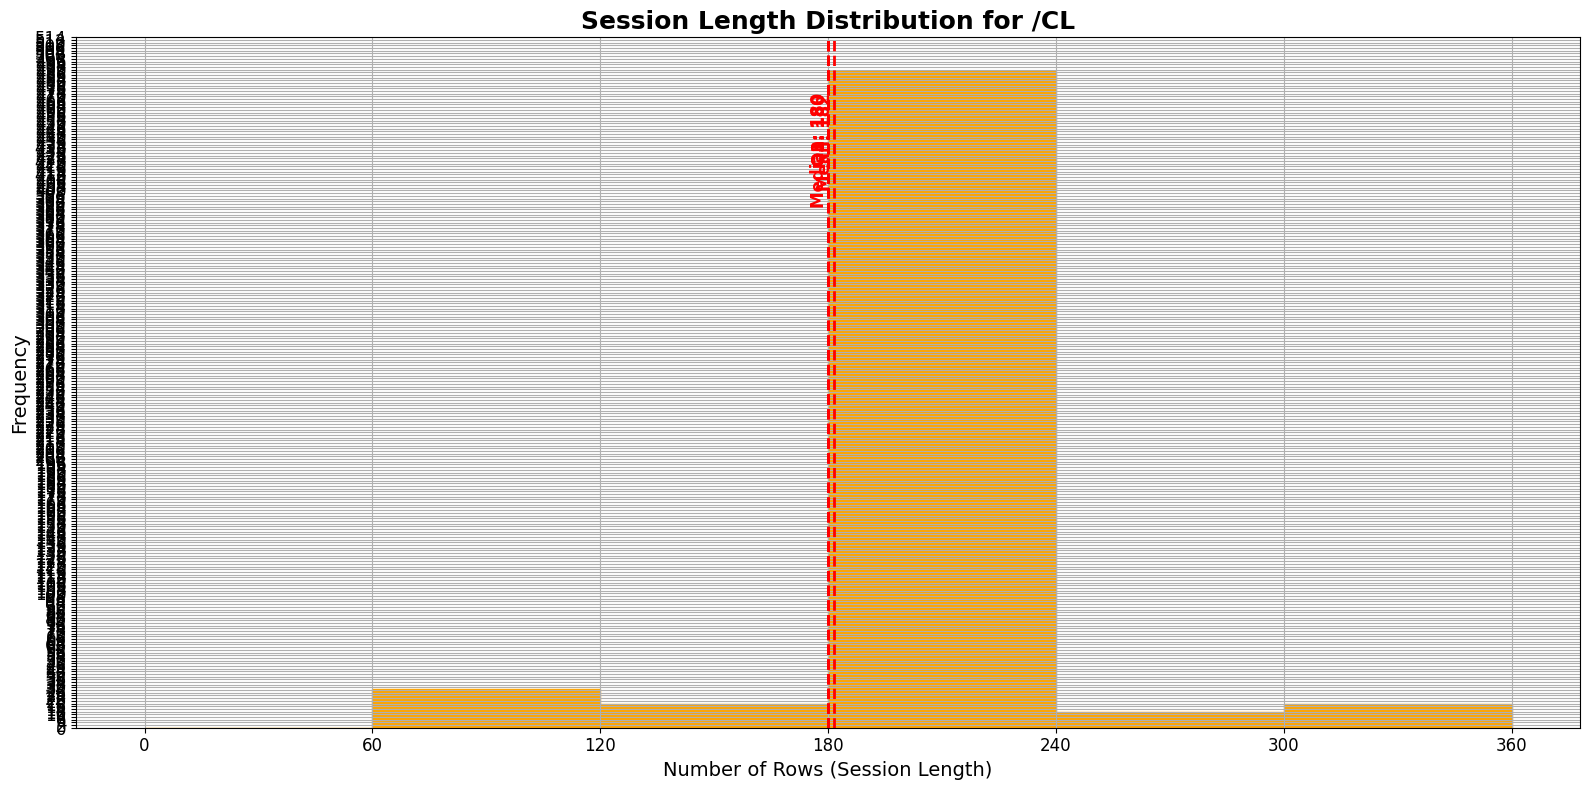

Summary Statistics for /CL:
  Mean Session Length: 181.53 minutes (3.03 hours)
  Median Session Length: 180.00 minutes (3.00 hours)
  Q1 Session Length: 180.00 minutes (3.00 hours)
  Q3 Session Length: 180.00 minutes (3.00 hours)

------------------------------------------------------------



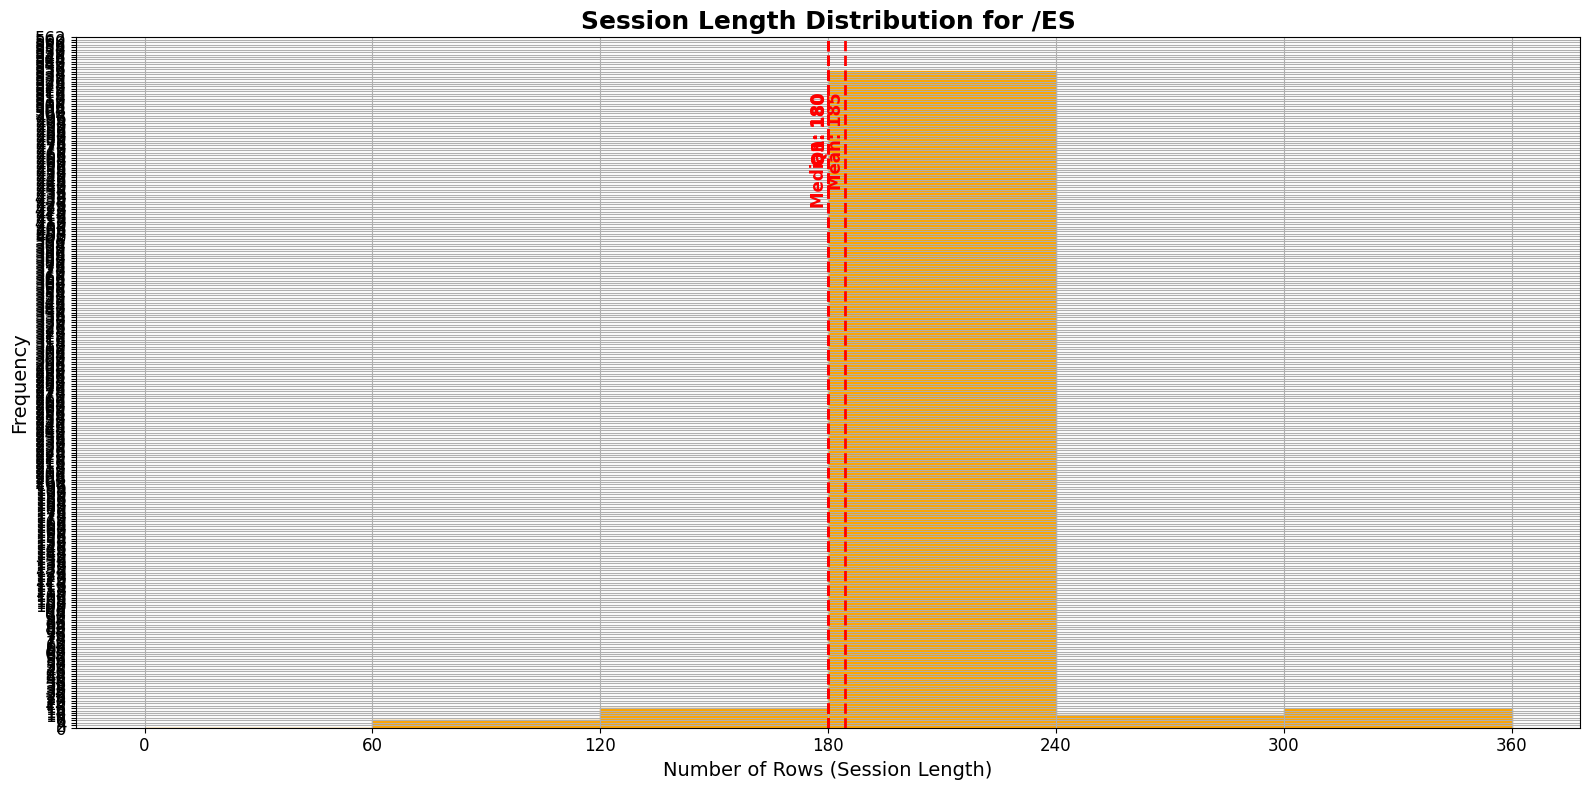

Summary Statistics for /ES:
  Mean Session Length: 184.54 minutes (3.08 hours)
  Median Session Length: 180.00 minutes (3.00 hours)
  Q1 Session Length: 180.00 minutes (3.00 hours)
  Q3 Session Length: 180.00 minutes (3.00 hours)

------------------------------------------------------------



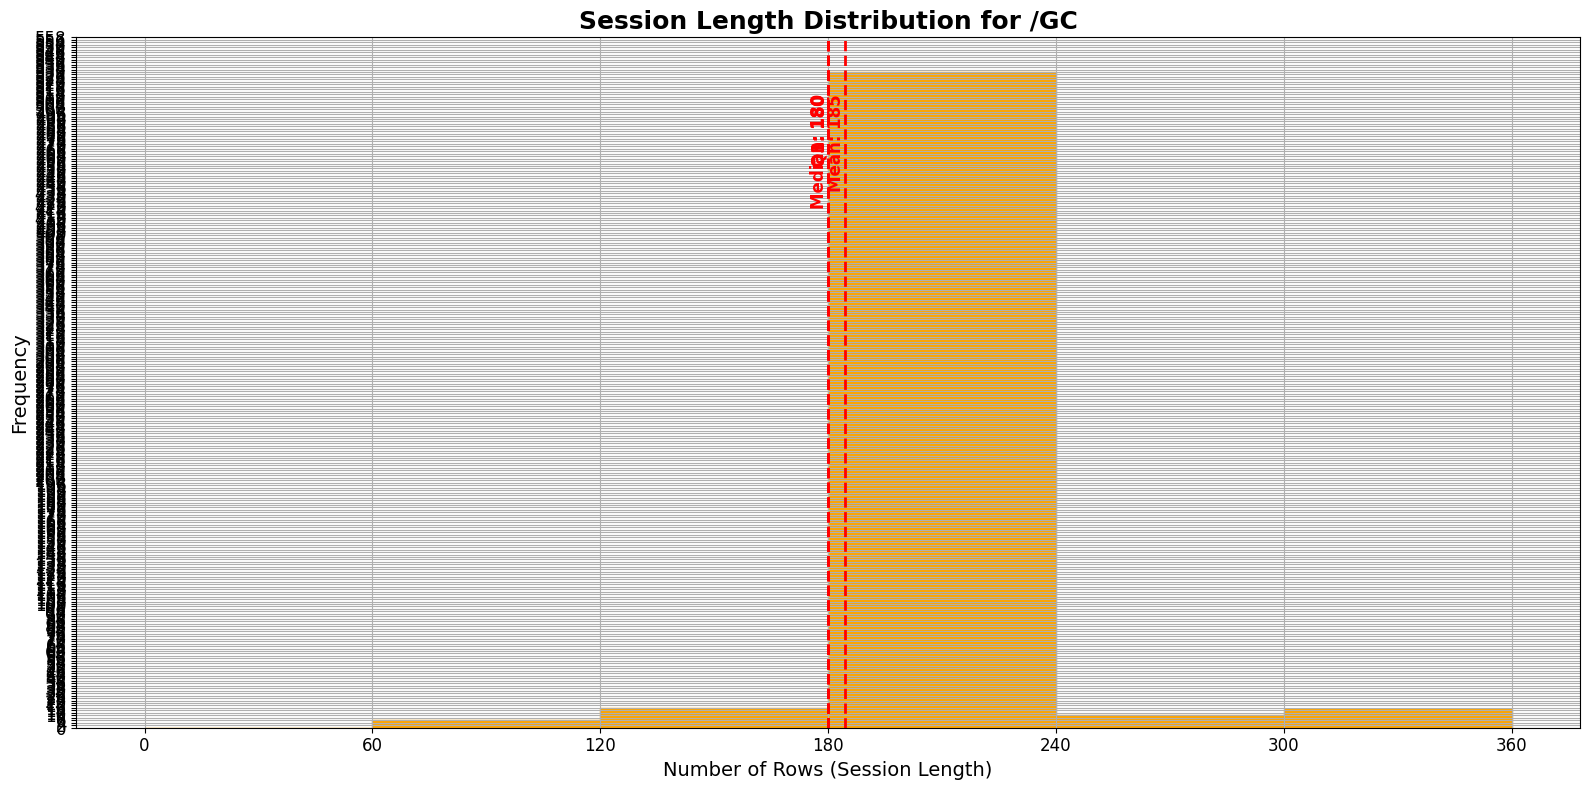

Summary Statistics for /GC:
  Mean Session Length: 184.51 minutes (3.08 hours)
  Median Session Length: 180.00 minutes (3.00 hours)
  Q1 Session Length: 180.00 minutes (3.00 hours)
  Q3 Session Length: 180.00 minutes (3.00 hours)

------------------------------------------------------------



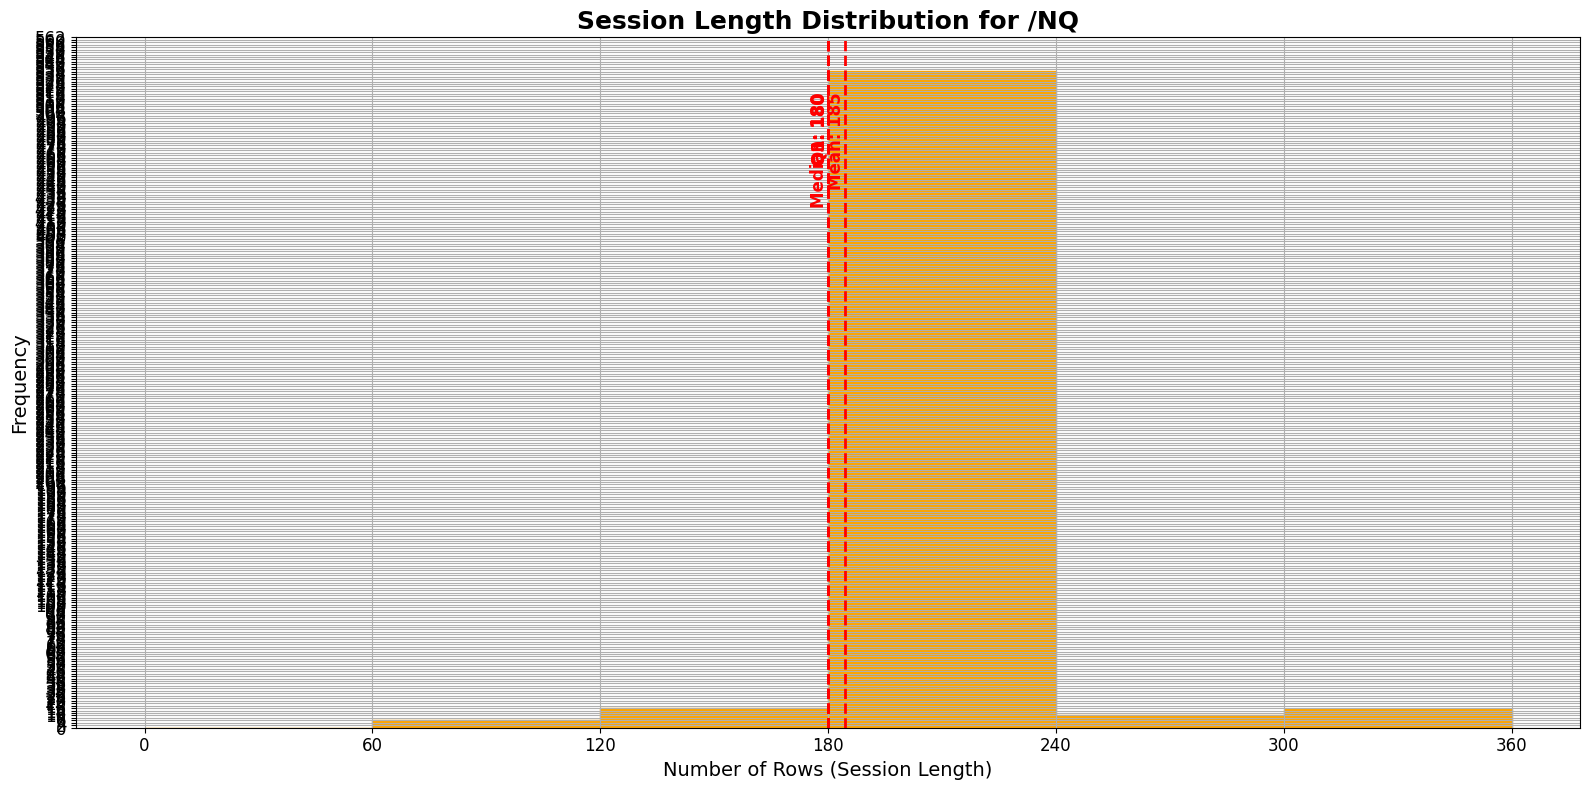

Summary Statistics for /NQ:
  Mean Session Length: 184.54 minutes (3.08 hours)
  Median Session Length: 180.00 minutes (3.00 hours)
  Q1 Session Length: 180.00 minutes (3.00 hours)
  Q3 Session Length: 180.00 minutes (3.00 hours)

------------------------------------------------------------



In [47]:
def plot_session_lengths(split_sessions):
    """
    Plots histograms of session lengths for each ticker,
    syncing x-axis ticks and bin edges every 60,
    and y-axis ticks every 2,
    with black-colored bars and red lines for mean, median, and quartiles.
    Also prints mean, median, and quartiles after each chart,
    in both minutes and hours.
    """
    for ticker, sessions in split_sessions.items():
        session_lengths = [len(session_df) for session_df in sessions.values()]
        
        if not session_lengths:
            continue

        plt.figure(figsize=(16, 8))
        
        # Calculate bin edges and x-ticks at 60-step intervals
        max_x = max(session_lengths)
        bin_edges = np.arange(0, max_x + 60, 60)

        # Plot histogram with black bars
        plt.hist(session_lengths, bins=bin_edges, edgecolor='orange', color='orange')
        
        # Calculate statistics
        mean_val = np.mean(session_lengths)
        median_val = np.median(session_lengths)
        q1 = np.percentile(session_lengths, 25)
        q3 = np.percentile(session_lengths, 75)

        # Plot vertical lines
        for stat, label in zip([mean_val, median_val, q1, q3], ['Mean', 'Median', 'Q1', 'Q3']):
            plt.axvline(stat, color='red', linestyle='--', linewidth=2)
            plt.text(
                stat, plt.gca().get_ylim()[1]*0.92, 
                f'{label}: {stat:.0f}', 
                color='red', rotation=90, va='top', ha='right', 
                fontsize=12, fontweight='bold'
            )

        # Bigger title and axis labels
        plt.title(f'Session Length Distribution for {ticker}', fontsize=18, fontweight='bold')
        plt.xlabel('Number of Rows (Session Length)', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)

        # Make xticks and yticks a little bigger
        plt.xticks(bin_edges, fontsize=12)
        
        ax = plt.gca()
        max_y = ax.get_ylim()[1]
        plt.yticks(np.arange(0, max_y + 2, 2), fontsize=12)  # y-axis increments of 2

        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # === Print summary statistics ===
        print(f"Summary Statistics for {ticker}:")
        for label, value in zip(['Mean', 'Median', 'Q1', 'Q3'], [mean_val, median_val, q1, q3]):
            hours = value / 60
            print(f"  {label} Session Length: {value:.2f} minutes ({hours:.2f} hours)")
        print("\n" + "-"*60 + "\n")

plot_session_lengths(split_sessions)

## <h2 style="color:yellow;">Compressing Each Session of Each Ticker in the Dictionary, Calculating Indicators, Applying Strategy.</h2> 
#### **- This is where we get bound by big computation**

Add a new key:value degree ( `session` : `compression` ) to the candle dictionary and call it `compressed_sessions`. Every session now has as many compressions as there are in the `compression_factors` list

In [ ]:
# Create the new nested dictionary
compressed_sessions = {}

# Iterate through tickers
for ticker, sessions in split_sessions.items():
    compressed_sessions[ticker] = {}  # Initialize ticker dictionary

    # Iterate through sessions (time slices)
    for time_slice, session_df in sessions.items():
        compressed_sessions[ticker][time_slice] = {}  # Initialize session dictionary

        # Apply each compression factor
        for compression_factor in compression_factors:
            dynamic_name = f"{compression_factor}_minute_compression"
            compressed_sessions[ticker][time_slice][dynamic_name] = compress_candles(session_df, compression_factor)

dictionary[ticker][session][compression][lower_slice:upper_slice]

In [ ]:
# Get the nth session key (e.g., index 0, 1, 2, ...)
session_index_view = 0
ticker_view = '/NQ'
compression_view = '1_minute_compression'

# Extract the session key by index
session_keys = list(compressed_sessions[ticker].keys())
selected_session_view = session_keys[session_index_view]

# Access and display the DataFrame
display(compressed_sessions[ticker_view][selected_session_view][compression_view])

`eastern_time` should not exist in any data frame in the dictionary. Here, we check

In [ ]:
df = compressed_sessions[ticker_view][selected_session_view][compression_view]

if 'eastern_time' in df.columns:
    print("'eastern_time' column exists.")
else:
    print("'eastern_time' column does not exist.")

Printing percentage of candles that contain prior candles' close for each compression of each session of each ticker

In [ ]:
def percentage_candles_containing_price_1(df, price_column, offset=0):
    """Calculate the % of candles where (prev close ± offset) is within [low, high]."""
    prev_close = df[price_column].shift(1)
    target_price = prev_close + offset
    contains = (df['low'] <= target_price) & (df['high'] >= target_price)
    return contains.mean() * 100  # percentage

for ticker, sessions in compressed_sessions.items():
    print(f"\nTicker: {ticker}, Total Sessions: {len(sessions)}")
    tick_size = ticker_to_tick_size.get(ticker, 0)

    # Storage
    weighted_sums_center = {}
    weighted_sums_minus_tick = {}
    weighted_sums_plus_tick = {}
    row_counts = {}

    for time_slice, compressions in sessions.items():
        print(f"  {ticker} Time Slice: {time_slice}, Total Compressions: {len(compressions)}")

        for compression_name, session_df in compressions.items():
            compression_factor = int(compression_name.split('_')[0])

            pct_center = percentage_candles_containing_price_1(session_df, 'close', offset=0)
            pct_minus_tick = percentage_candles_containing_price_1(session_df, 'close', offset=-tick_size)
            pct_plus_tick = percentage_candles_containing_price_1(session_df, 'close', offset=tick_size)

            avg_close = session_df['close'].mean().round(2)
            session_rows = len(session_df)

            # Init storage
            if compression_factor not in weighted_sums_center:
                weighted_sums_center[compression_factor] = 0
                weighted_sums_minus_tick[compression_factor] = 0
                weighted_sums_plus_tick[compression_factor] = 0
                row_counts[compression_factor] = 0

            # Weighted accumulation
            weighted_sums_center[compression_factor] += pct_center * session_rows
            weighted_sums_minus_tick[compression_factor] += pct_minus_tick * session_rows
            weighted_sums_plus_tick[compression_factor] += pct_plus_tick * session_rows
            row_counts[compression_factor] += session_rows

            # Print session-level stats
            print(
                f"    Compression: {compression_factor}-Min, Rows: {session_rows}, "
                f"Avg Close: {avg_close:.2f}, "
                f"% Close In Candle: {pct_center:.2f}%, "
                f"% Close - Tick In Candle: {pct_minus_tick:.2f}%, "
                f"% Close + Tick In Candle: {pct_plus_tick:.2f}%"
            )

    # Print weighted averages per compression
    print("\n  Weighted Averages by Compression Factor:")
    for compression_factor in sorted(row_counts.keys()):
        total_rows = row_counts[compression_factor]
        if total_rows == 0:
            continue
        print(
            f"    {ticker} {compression_factor}-Min:"
            f" Center={weighted_sums_center[compression_factor] / total_rows:.2f}%,"
            f" -Tick={weighted_sums_minus_tick[compression_factor] / total_rows:.2f}%,"
            f" +Tick={weighted_sums_plus_tick[compression_factor] / total_rows:.2f}%"
        )

Calculating indicators for each compression of each session of each ticker

In [ ]:
# Print the result to verify
print("MA Periods:", ma_periods)
print("MA Combinations:", ma_combinations)

# Iterate through all tickers in compressed_sessions
for ticker, sessions in compressed_sessions.items():
    print(f"Processing ticker: {ticker}")

    # Iterate through all sessions of the current ticker
    for time_slice, compressions in sessions.items():
        print(f"{ticker}  Processing session: {time_slice}, Total Compressions: {len(compressions)}")

        # Iterate through all compression levels of the current session
        for compression_name, df in compressions.items():
            print(f"    Processing compression: {compression_name} in session {time_slice}")

            # Calculate moving averages and indicators for each DataFrame
            compressions[compression_name] = calculate_indicators_1(
                df, 
                price_col='close', 
                acc_vol_col='accumulative_volume', 
                sma_periods=sma_periods,
                wma_periods=wma_periods,
                rsi_periods=rsi_periods,
                candle_window=5,
                base_window=5,
                adaptive_window=3,
                trend_window=6
            )

In [ ]:
display(compressed_sessions[ticker_view][selected_session_view][compression_view])

Looking at some counts to think about the size of the data structure

In [ ]:
def summarize_compressed_sessions(compressed_sessions):
    num_tickers = len(compressed_sessions)
    num_sessions = 0
    num_compressions = 0
    total_rows = 0
    total_columns = 0

    for ticker, sessions in compressed_sessions.items():
        num_sessions += len(sessions)
        for session, compressions in sessions.items():
            num_compressions += len(compressions)
            for compression, df in compressions.items():
                total_rows += len(df)
                total_columns += len(df.columns)

    print(f"Total number of tickers: {num_tickers}")
    print(f"Total number of sessions across all tickers: {num_sessions}")
    print(f"Total number of compressions across all tickers and all sessions: {num_compressions}")
    print(f"Total number of columns across all tickers, sessions, and compressions: {total_columns}")
    print(f"Total number of rows across all tickers, sessions, and compressions: {total_rows}")

summarize_compressed_sessions(compressed_sessions)

In [ ]:
# Access and display the DataFrame
display(compressed_sessions[ticker_view][selected_session_view][compression_view])

Applying the trading strategy to each compression of each session of each ticker

In [ ]:
strategy_types = ['trend', 'reversion']
order_types = ['market', 'limit']
directional_biases = ['long', 'short']
directional_bias = 'long'

# Iterate through all tickers in compressed_sessions
for ticker, sessions in compressed_sessions.items():
    print(f"Processing ticker: {ticker}")

    # Iterate through all sessions of the current ticker
    for time_slice, compressions in sessions.items():
        print(f"  {ticker} Processing session: {time_slice}, Total Compressions: {len(compressions)}")

        # Iterate through all compression levels of the current session
        for compression_name, df in compressions.items():
            print(f"    {ticker} Processing compression: {compression_name} in session {time_slice}")

            # Iterate through all the ma_combinations
            for sig_ma, con_ma, rsi_col in ma_combinations:

                for strategy_type in strategy_types:
                    print(f"      {ticker} {time_slice} {compression_name} Applying {strategy_type} strategy for {sig_ma} and {con_ma}")
                    
                    for order_type in order_types:
                        print(f"        {ticker} Applying {order_type} order_type")

                        # for directional_bias in directional_biases:
                        #     print(f"          Applying {directional_bias} directional bias")

                        # Generate trading signals for the current strategy
                        compressions[compression_name] = generate_trading_signals_1(
                            df,
                            ma_name1=sig_ma,
                            ma_name2=con_ma,
                            rsi_column=rsi_col,
                            strategy_type=strategy_type,
                            order_type=order_type,
                            directional_bias=directional_bias
                        )

                        # Update position_open columns to be 1:1 verbal boolean with the signal
                        compressions[compression_name] = update_position_open_1(
                            df,
                            ma_name1=sig_ma,
                            ma_name2=con_ma,
                            rsi_column=rsi_col,
                            strategy_type=strategy_type,
                            order_type=order_type,
                            directional_bias=directional_bias
                        )

                        # Determine entry prices for each ticker
                        compressions[compression_name] = determine_entry_prices_1(
                            df,
                            ma_name1=sig_ma,
                            ma_name2=con_ma,
                            rsi_column=rsi_col,
                            ticker_to_tick_size=ticker_to_tick_size,
                            ticker=ticker,
                            strategy_type=strategy_type,
                            order_type=order_type,
                            directional_bias=directional_bias
                        )

                        # Determine exit prices for each ticker
                        compressions[compression_name] = determine_exit_prices_1(
                            df,
                            ma_name1=sig_ma,
                            ma_name2=con_ma,
                            rsi_column=rsi_col,
                            ticker_to_tick_size=ticker_to_tick_size,
                            ticker=ticker,
                            strategy_type=strategy_type,
                            order_type=order_type,
                            directional_bias=directional_bias
                        )

                        # Stop loss calculation
                        compressions[compression_name] = calculate_stop_losses_1(
                            df,
                            ma_name1=sig_ma,
                            ma_name2=con_ma,
                            rsi_column=rsi_col,
                            strategy_type=strategy_type,
                            order_type=order_type,
                            directional_bias=directional_bias
                        )

                        # Track stop loss hits
                        compressions[compression_name] = track_stop_loss_hits_1(
                            df,
                            ma_name1=sig_ma,
                            ma_name2=con_ma,
                            rsi_column=rsi_col,
                            ticker_to_tick_size=ticker_to_tick_size,
                            ticker=ticker,
                            strategy_type=strategy_type,
                            order_type=order_type,
                            directional_bias=directional_bias
                        )

                        # Adjust signals from stop loss hits
                        compressions[compression_name] = adjust_signals_for_stop_loss_1(
                            df,
                            ma_name1=sig_ma,
                            ma_name2=con_ma,
                            rsi_column=rsi_col,
                            strategy_type=strategy_type,
                            order_type=order_type,
                            directional_bias=directional_bias
                        )

                        # Re-update position_open column after stop loss hits
                        compressions[compression_name] = update_position_open_1(
                            df,
                            ma_name1=sig_ma,
                            ma_name2=con_ma,
                            rsi_column=rsi_col,
                            strategy_type=strategy_type,
                            order_type=order_type,
                            directional_bias=directional_bias
                        )

                        # Re-determine entry prices after stop loss hits
                        compressions[compression_name] = determine_entry_prices_1(
                            df,
                            ma_name1=sig_ma,
                            ma_name2=con_ma,
                            rsi_column=rsi_col,
                            ticker_to_tick_size=ticker_to_tick_size,
                            ticker=ticker,
                            strategy_type=strategy_type,
                            order_type=order_type,
                            directional_bias=directional_bias
                        )

                        # Re-determine exit prices after stop loss hits
                        compressions[compression_name] = determine_exit_prices_1(
                            df,
                            ma_name1=sig_ma,
                            ma_name2=con_ma,
                            rsi_column=rsi_col,
                            ticker_to_tick_size=ticker_to_tick_size,
                            ticker=ticker,
                            strategy_type=strategy_type,
                            order_type=order_type,
                            directional_bias=directional_bias
                        )

                        # Update stop loss levels after stop loss hits
                        compressions[compression_name] = update_stop_loss_1(
                            df,
                            ma_name1=sig_ma,
                            ma_name2=con_ma,
                            rsi_column=rsi_col,
                            strategy_type=strategy_type,
                            order_type=order_type,
                            directional_bias=directional_bias
                            
                        )

                        # Calculate profit/loss for each ticker's DataFrame
                        compressions[compression_name] = calculate_profit_loss_1(
                            df,
                            contract_multiplier=1,
                            ma_name1=sig_ma,
                            ma_name2=con_ma,
                            rsi_column=rsi_col,
                            strategy_type=strategy_type,
                            order_type=order_type,
                            directional_bias=directional_bias   
                        )

Looking at the dictionary to see how the application of the trading strategy affected its structure and size

In [ ]:
summarize_compressed_sessions(compressed_sessions)
display(compressed_sessions[ticker_view][selected_session_view][compression_view])

In [ ]:
# get column names of the following DataFrame
print(compressed_sessions[ticker_view][selected_session_view][compression_view].columns.tolist())

Plotting the evolution of each trade after entry in an attempt to find a pattern that would help optimize a "fixed bar exit"

In [ ]:
# Get the nth session key (e.g., index 0, 1, 2, ...)
session_index_view1 = 300
ticker_view1 = '/NQ'
compression_view1 = '3_minute_compression'

# Extract the session key by index
session_keys1 = list(compressed_sessions[ticker].keys())
selected_session_view1 = session_keys1[session_index_view1]

def plot_pnl_curves_from_entries(
    df,
    ma_name1='wma_1',
    ma_name2='sma_1',
    strategy_type='trend',
    order_type='market',
    directional_bias='long',
    max_bars=60
):
    """
    Plot how PnL evolves from each entry point using the 'close' column.

    Parameters:
    - df (pd.DataFrame): The DataFrame with OHLC data and entry prices.
    - ma_name1, ma_name2, strategy_type, order_type, directional_bias: Used to dynamically define the entry column.
    - max_bars (int): Maximum number of bars to track after entry.
    """
    entry_col = f'entry_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'

    if entry_col not in df.columns:
        raise ValueError(f"{entry_col} not found in DataFrame.")

    curves = []

    for idx, entry_price in df[entry_col].dropna().items():
        close_slice = df['close'].iloc[idx:idx + max_bars].values
        if len(close_slice) > 1:
            pnl_curve = close_slice - entry_price
            curves.append(pnl_curve)

    # Plot all curves
    plt.figure(figsize=(18, 9))
    for curve in curves:
        plt.plot(curve, alpha=1, linewidth=2)

    # Plot average curve
    if curves:
        max_len = max(len(c) for c in curves)
        padded = np.full((len(curves), max_len), np.nan)
        for i, curve in enumerate(curves):
            padded[i, :len(curve)] = curve
        avg_curve = np.nanmean(padded, axis=0)
        plt.plot(avg_curve, color='black', linewidth=4, label='Average PnL')

    plt.title(f"PnL Curves from Entry — {entry_col}")
    plt.xlabel("Bars Since Entry")
    plt.ylabel("PnL")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Display function for user to call
plot_pnl_curves_from_entries(
    df=compressed_sessions[ticker_view1][selected_session_view1][compression_view1],
    ma_name1='wma_3',
    ma_name2='sma_3',
    strategy_type='reversion',
    order_type='limit',
    directional_bias='long',
    max_bars=100
)

Plotting all average profit evolution curve averages across sessions to see if there is some pattern for optimizing fixed bar exit. There does not seem to be one. I may be presenting this data incorrectly for this question

In [ ]:
def plot_avg_pnl_curves_across_sessions(
    sessions_dict,
    ticker,
    compression,
    ma_name1='wma_1',
    ma_name2='sma_1',
    strategy_type='trend',
    order_type='market',
    directional_bias='long',
    max_bars=60
):
    """
    Plot average PnL curve for each session in the compressed_sessions dictionary.

    Parameters:
    - sessions_dict (dict): Dictionary of sessions (e.g., compressed_sessions).
    - ticker (str): Ticker symbol to access.
    - compression (str): Compression key (e.g., '3_minute_compression').
    - ma_name1, ma_name2, strategy_type, order_type, directional_bias: Used to construct entry column.
    - max_bars (int): Number of bars to track PnL after entry.
    """
    entry_col = f'entry_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    avg_curves = []

    for session_key in sessions_dict[ticker].keys():
        df = sessions_dict[ticker][session_key][compression]
        if entry_col not in df.columns:
            continue

        curves = []
        for idx, entry_price in df[entry_col].dropna().items():
            close_slice = df['close'].iloc[idx:idx + max_bars].values
            if len(close_slice) > 1:
                pnl_curve = close_slice - entry_price
                curves.append(pnl_curve)

        if curves:
            max_len = max(len(c) for c in curves)
            padded = np.full((len(curves), max_len), np.nan)
            for i, curve in enumerate(curves):
                padded[i, :len(curve)] = curve
            avg_curve = np.nanmean(padded, axis=0)
            avg_curves.append(avg_curve)

    # Plot all average curves
    plt.figure(figsize=(18, 9))
    for curve in avg_curves:
        plt.plot(curve, linewidth=3, alpha=0.7)

    plt.title(f"Avg PnL Curves — All Sessions — {entry_col}")
    plt.xlabel("Bars Since Entry")
    plt.ylabel("PnL")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_avg_pnl_curves_across_sessions(
    sessions_dict=compressed_sessions,
    ticker='/NQ',
    compression='3_minute_compression',
    ma_name1='wma_3',
    ma_name2='sma_3',
    strategy_type='reversion',
    order_type='limit',
    directional_bias='long',
    max_bars=100
)

## <h2 style="color:yellow;">Storing Calculated Data in Dictionary and Flat DF Formats and Pulling Them Back into Environment</h2>
#### **- I'm doing this to reduce the time it takes to get into the analytics of the strategies**

Store `compressed_sessions` in json format.

In [ ]:
def save_compressed_sessions_to_json(data, filepath):
    serializable_dict = {}

    for ticker, sessions in data.items():
        serializable_dict[ticker] = {}
        for session, compressions in sessions.items():
            serializable_dict[ticker][session] = {}
            for compression, df in compressions.items():
                df_copy = df.copy()

                # Convert any Timestamp (including tz-aware) to ISO string globally
                df_copy = df_copy.applymap(
                    lambda x: x.isoformat() if isinstance(x, pd.Timestamp) else x
                )

                serializable_dict[ticker][session][compression] = df_copy.to_dict(orient='records')

    with open(filepath, 'w') as f:
        json.dump(serializable_dict, f, indent=2)

save_compressed_sessions_to_json(compressed_sessions, 'compressed_sessions.json')

Pull `compressed_sessions' back into dictionary

In [ ]:
def load_compressed_sessions_from_json(filepath):
    with open(filepath, 'r') as f:
        raw_data = json.load(f)

    reconstructed = {}

    for ticker, ticker_data in raw_data.items():
        reconstructed[ticker] = {}
        for session, session_data in ticker_data.items():
            reconstructed[ticker][session] = {}
            for compression, df_data in session_data.items():
                df = pd.DataFrame(df_data)

                # Convert 'datetime' column to datetime format (keep as a column)
                if 'datetime' in df.columns:
                    df['datetime'] = pd.to_datetime(df['datetime'])

                # Keep default numeric index, don't set datetime as index
                reconstructed[ticker][session][compression] = df

    return reconstructed

compressed_sessions = load_compressed_sessions_from_json('compressed_sessions.json')

In [ ]:
display(compressed_sessions[ticker_view][selected_session_view][compression_view])

Flatten the nested dictionary `compressed_sessions` to the data frame `compressed_sessions_flattened` and call it back after storing it. This will allow for more detailed analytics.

In [ ]:
def flatten_compressed_sessions_to_dataframe(compressed_sessions_dictionary):
    all_rows = []

    for ticker, sessions in compressed_sessions_dictionary.items():
        for session, compressions in sessions.items():
            for compression, df in compressions.items():
                temp_df = df.copy()
                temp_df["ticker"] = ticker
                temp_df["session"] = session
                temp_df["compression_factor"] = compression.split('_')[0]
                all_rows.append(temp_df)

    combined_df = pd.concat(all_rows, ignore_index=True)

    # Reorder columns: datetime → session → compression → rest
    cols = combined_df.columns.tolist()

    if 'datetime' in cols:
        front = ['datetime', 'session', 'compression_factor']
        rest = [col for col in cols if col not in front]
        combined_df = combined_df[front + rest]

    return combined_df

compressed_sessions_flat = flatten_compressed_sessions_to_dataframe(compressed_sessions)

# Reorder columns: datetime → session → compression → rest
cols = compressed_sessions_flat.columns.tolist()

if 'datetime' in cols:
    front = ['datetime', 'session', 'compression_factor']
    rest = [col for col in cols if col not in front]
    compressed_sessions_flat = compressed_sessions_flat[front + rest]

In [ ]:
nq_df = compressed_sessions_flat[compressed_sessions_flat['ticker'] == '/NQ'].copy()
display(nq_df)

Write `compressed_sessions_flattened` to csv and pull back into data frame format

In [ ]:
compressed_sessions_flat.to_csv("compressed_sessions_flat.csv", index=False)

In [ ]:
compressed_sessions_flat = pd.read_csv("compressed_sessions_flat.csv")

In [ ]:
nq_df = compressed_sessions_flat[compressed_sessions_flat['ticker'] == '/NQ'].copy()
display(nq_df)

In [ ]:
nq_1m_df = compressed_sessions_flat[(compressed_sessions_flat['ticker'] == '/NQ') & (compressed_sessions_flat['compression_factor'] == 1)]
nq_1m_df

In [ ]:
# get list of column names for compressed_sessions_flat
compressed_sessions_flat.columns.tolist()

Don't delete, might need this on occasion

In [ ]:
# def reconstruct_nested_dict_from_flattened_dataframe(compressed_sessions_flat):
#     nested_dict = {}

#     grouped = compressed_sessions_flat.groupby(['ticker', 'session', 'compression'])

#     for (ticker, session, compression), group in grouped:
#         df = group.drop(columns=['ticker', 'session', 'compression'])
#         nested_dict.setdefault(ticker, {}).setdefault(session, {})[compression] = df.reset_index(drop=True)

#     return nested_dict

# compressed_sessions = reconstruct_nested_dict_from_flattened_dataframe(compressed_sessions_flat)
# compressed_sessions

These are suspect... not yet to be trusted. Distributions don't look how I expect. Especially the 17th hour

In [ ]:
def plot_avg_hourly_pnl_from_flat(
    df,
    ticker,
    compression_factor,
    ma_name1='wma_1',
    ma_name2='sma_1',
    rsi_column='rsi_1',
    strategy_type='trend',
    order_type='market',
    directional_bias='long',
    source='ma'  # 'ma' or 'rsi'
):
    """
    Plot average hourly PnL from a flat DataFrame for a given strategy configuration.
    Filters by ticker and compression factor.

    Parameters:
    - df (pd.DataFrame): Flat DataFrame (e.g., compressed_sessions_flat)
    - ticker (str): Ticker symbol to filter
    - compression_factor (int): Compression factor to filter
    - ma_name1, ma_name2, rsi_column: Indicator names
    - strategy_type, order_type, directional_bias: Strategy metadata
    - source (str): 'ma' or 'rsi' to indicate which pnl column to use
    """
    # Construct dynamic column name
    if source == 'ma':
        pnl_col = f'pnl_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    elif source == 'rsi':
        pnl_col = f'pnl_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    else:
        raise ValueError("source must be 'ma' or 'rsi'")

    if pnl_col not in df.columns:
        raise ValueError(f"Column '{pnl_col}' not found in DataFrame.")
    if 'datetime' not in df.columns:
        raise ValueError("DataFrame must contain a 'datetime' column.")

    # Filter by ticker and compression factor
    filtered = df[(df['ticker'] == ticker) & (df['compression_factor'] == compression_factor)]

    if filtered.empty:
        print(f"No matching data for selected ticker {ticker} and compression factor {compression_factor}.")
        return

    # Parse datetime and extract hour
    filtered = filtered.copy()
    filtered['datetime'] = pd.to_datetime(filtered['datetime'], utc=True)
    filtered['datetime'] = filtered['datetime'].dt.tz_convert(None)
    filtered['hour'] = filtered['datetime'].dt.hour

    # Group by hour and average
    hourly_avg = filtered.groupby('hour')[pnl_col].sum()

    # Plot
    plt.figure(figsize=(14, 6))
    plt.bar(hourly_avg.index, hourly_avg.values, color='black', edgecolor='white')
    plt.title(f"Avg Hourly PnL — {ticker} {compression_factor}min — {pnl_col}", fontsize=16, fontweight='bold')
    plt.xlabel("Hour of Day", fontsize=14)
    plt.ylabel("Average PnL", fontsize=14)
    plt.xticks(range(0, 24))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_avg_hourly_pnl_from_flat(
    df=compressed_sessions_flat,
    ticker='/NQ',
    compression_factor=3,
    ma_name1='wma_3',
    ma_name2='sma_3',
    rsi_column='rsi_3',
    strategy_type='reversion',
    order_type='limit',
    directional_bias='long',
    source='ma'
)

In [ ]:
def plot_hourly_row_count(
    df,
    ticker,
    compression_factor
):
    """
    Plot the number of rows in the dataset per hour of the day, filtered by ticker and compression_factor.

    Parameters:
    - df (pd.DataFrame): Flat DataFrame (e.g., compressed_sessions_flat)
    - ticker (str): Ticker symbol to filter
    - compression_factor (int): Compression factor to filter
    """
    if 'datetime' not in df.columns:
        raise ValueError("DataFrame must contain a 'datetime' column.")

    # Filter by ticker and compression factor
    filtered = df[(df['ticker'] == ticker) & (df['compression_factor'] == compression_factor)]

    if filtered.empty:
        print(f"No matching data for selected ticker {ticker} and compression factor {compression_factor}.")
        return

    # Parse datetime and extract hour
    filtered = filtered.copy()
    filtered['datetime'] = pd.to_datetime(filtered['datetime'], utc=True).dt.tz_convert(None)
    filtered['hour'] = filtered['datetime'].dt.hour

    # Count rows per hour
    hourly_counts = filtered.groupby('hour').size()

    # Plot
    plt.figure(figsize=(14, 6))
    plt.bar(hourly_counts.index, hourly_counts.values, color='black', edgecolor='white')
    plt.title(f"Hourly Row Count — {ticker} {compression_factor}min", fontsize=16, fontweight='bold')
    plt.xlabel("Hour of Day", fontsize=14)
    plt.ylabel("Row Count", fontsize=14)
    plt.xticks(range(0, 24))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_hourly_row_count(
    df=compressed_sessions_flat,
    ticker='/NQ',
    compression_factor=1
)

In [ ]:
nq_1m_df = compressed_sessions_flat[(compressed_sessions_flat['ticker'] == '/NQ') & (compressed_sessions_flat['compression_factor'] == 1)]
nq_1m_df

## <h2 style="color:yellow;">Generate PNL Data Frame</h2>
#### **This section generates a data frame that contains pnl figures for each compression of each session of each ticker of each strategy type (trend and reversion).**

In [ ]:
def generate_pnl_dataframe(compressed_sessions, ticker_to_tick_size, ticker_to_point_value, 
                           ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5', 
                           strategy_type='trend', order_type='market', directional_bias='long',
                           daily_stop_loss_dollars=-1000):
    """
    Generates a DataFrame containing detailed PnL, trade statistics, and max gain/loss for all tickers, 
    sessions, and compression factors, now including trend/reversion strategy type and MA/RSI periods.

    Parameters:
    - compressed_sessions: Dictionary of nested dictionaries containing trading data structured as:
      {ticker: {session: {compression_factor: DataFrame}}}
    - ticker_to_tick_size: Dictionary mapping tickers to tick sizes.
    - ticker_to_point_value: Dictionary mapping tickers to point values.
    - ma_name1, ma_name2: Moving average column names.
    - rsi_column: RSI column name.
    - strategy_type: "trend" or "reversion".

    Returns:
    - pd.DataFrame: A DataFrame with PnL, trade statistics, max gain/loss, session names, compression factors, 
      strategy type, and indicator periods.
    """
    def compute_stop_loss_metrics(dollar_pnl, dollar_max_loss, daily_stop_loss_dollars):
        hit = int(dollar_max_loss <= daily_stop_loss_dollars)
        cost = daily_stop_loss_dollars - dollar_pnl if dollar_pnl > daily_stop_loss_dollars and hit else 0.0
        gain = daily_stop_loss_dollars - dollar_pnl if dollar_pnl < daily_stop_loss_dollars and hit else 0.0
        return hit, cost, gain

    # Extract period lengths from indicator names (assumes format like "wma_5", "sma_10", "rsi_14")
    ma1_period = int(ma_name1.split('_')[-1])  # Extract last numeric part
    ma2_period = int(ma_name2.split('_')[-1])
    rsi_period = int(rsi_column.split('_')[-1])

    # Generate dynamic column names for PnL and trade metrics
    pnl_ma_col = f'pnl_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    pnl_rsi_col = f'pnl_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    cum_pnl_ma_col = f'cum_{pnl_ma_col}'
    cum_pnl_rsi_col = f'cum_{pnl_rsi_col}'
    cum_pnl_all_col = f'cum_pnl_all_{ma_name1}_{ma_name2}_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    ma_entry_price = f'entry_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    ma_exit_price = f'exit_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_entry_price = f'entry_price_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_exit_price = f'exit_price_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    ma_commission_col = f'commission_cost_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_commission_col = f'commission_cost_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'

    # Create a list to hold rows of the DataFrame
    pnl_rows = []

    # Iterate over tickers
    for ticker, sessions in compressed_sessions.items():
        tick_size = ticker_to_tick_size.get(ticker, "Unknown")
        point_value = ticker_to_point_value.get(ticker, 1)

        # Iterate over sessions
        for session_name, compressions in sessions.items():

            # Iterate over compression factors
            for compression_name, df in compressions.items():
                try:
                    # Extract compression factor (e.g., '5_minute_compression' → 5)
                    compression_factor = int(compression_name.split('_')[0])

                    # Calculate cumulative PnL and other statistics
                    ma_pnl = round(df[cum_pnl_ma_col].iloc[-1], 3)
                    rsi_pnl = round(df[cum_pnl_rsi_col].iloc[-1], 3)
                    total_pnl = round(df[cum_pnl_all_col].iloc[-1], 3)
                    close_price_diff = round(df["close"].iloc[-1] - df["close"].iloc[0], 3)
                    point_alpha = round(total_pnl - close_price_diff, 3)

                    # Retrieve total commission costs
                    ma_commission_total = round(df[ma_commission_col].iloc[-1], 3) if ma_commission_col in df else 0.0
                    rsi_commission_total = round(df[rsi_commission_col].iloc[-1], 3) if rsi_commission_col in df else 0.0
                    total_commission_cost = ma_commission_total + rsi_commission_total

                    # Calculate total dollar PnLs
                    # Dollar PnL adjusted for commissions (optional)
                    ma_dollar_pnl = ma_pnl * point_value
                    rsi_dollar_pnl = rsi_pnl * point_value
                    total_dollar_pnl = total_pnl * point_value
                    ma_dollar_pnl_sub_comms = ma_pnl * point_value - ma_commission_total
                    rsi_dollar_pnl_sub_comms = rsi_pnl * point_value - rsi_commission_total
                    total_dollar_pnl_sub_comms = total_pnl * point_value - total_commission_cost
                    close_price_dollar_diff = close_price_diff * point_value
                    dollar_alpha = point_alpha * point_value

                    # Count the number of trades for MA and RSI strategies
                    ma_trades = (df[ma_exit_price].notna().sum() + df[ma_entry_price].notna().sum()) / 2
                    rsi_trades = (df[rsi_exit_price].notna().sum() + df[rsi_entry_price].notna().sum()) / 2

                    # Calculate max gain and max loss for MA, RSI, and total strategies (point and dollar)
                    ma_max_gain = round(df[cum_pnl_ma_col].max(), 3)
                    ma_max_loss = round(df[cum_pnl_ma_col].min(), 3)
                    rsi_max_gain = round(df[cum_pnl_rsi_col].max(), 3)
                    rsi_max_loss = round(df[cum_pnl_rsi_col].min(), 3)
                    total_max_gain = round(df[cum_pnl_all_col].max(), 3)
                    total_max_loss = round(df[cum_pnl_all_col].min(), 3)

                    ma_max_dollar_gain = ma_max_gain * point_value
                    ma_max_dollar_loss = ma_max_loss * point_value
                    rsi_max_dollar_gain = rsi_max_gain * point_value
                    rsi_max_dollar_loss = rsi_max_loss * point_value
                    total_max_dollar_gain = total_max_gain * point_value
                    total_max_dollar_loss = total_max_loss * point_value

                    ma_gain_idx = df[cum_pnl_ma_col].idxmax()
                    ma_loss_idx = df[cum_pnl_ma_col].idxmin()
                    rsi_gain_idx = df[cum_pnl_rsi_col].idxmax()
                    rsi_loss_idx = df[cum_pnl_rsi_col].idxmin()
                    total_gain_idx = df[cum_pnl_all_col].idxmax()
                    total_loss_idx = df[cum_pnl_all_col].idxmin()

                    ma_max_dollar_gain_sub_comms = ma_max_dollar_gain - df[ma_commission_col].loc[ma_gain_idx]
                    ma_max_dollar_loss_sub_comms = ma_max_dollar_loss - df[ma_commission_col].loc[ma_loss_idx]
                    rsi_max_dollar_gain_sub_comms = rsi_max_dollar_gain - df[rsi_commission_col].loc[rsi_gain_idx]
                    rsi_max_dollar_loss_sub_comms = rsi_max_dollar_loss - df[rsi_commission_col].loc[rsi_loss_idx]
                    total_max_dollar_gain_sub_comms = total_max_dollar_gain - (
                        df[ma_commission_col].loc[total_gain_idx] + df[rsi_commission_col].loc[total_gain_idx]
                    )
                    total_max_dollar_loss_sub_comms = total_max_dollar_loss - (
                        df[ma_commission_col].loc[total_loss_idx] + df[rsi_commission_col].loc[total_loss_idx]
                    )

                    # Stop loss logic for total, MA, and RSI
                    stop_loss_hit_total, loss_prevention_cost_total, loss_prevention_gain_total = compute_stop_loss_metrics(
                        total_dollar_pnl, total_max_dollar_loss, daily_stop_loss_dollars)
                    stop_loss_hit_ma, loss_prevention_cost_ma, loss_prevention_gain_ma = compute_stop_loss_metrics(
                        ma_dollar_pnl, ma_max_dollar_loss, daily_stop_loss_dollars)
                    stop_loss_hit_rsi, loss_prevention_cost_rsi, loss_prevention_gain_rsi = compute_stop_loss_metrics(
                        rsi_dollar_pnl, rsi_max_dollar_loss, daily_stop_loss_dollars)
                    
                    # Compute the new stop-loss metrics for sub_comms
                    stop_loss_hit_total_sub_comms, loss_prevention_cost_total_sub_comms, loss_prevention_gain_total_sub_comms = compute_stop_loss_metrics(
                        total_dollar_pnl_sub_comms, total_max_dollar_loss_sub_comms, daily_stop_loss_dollars)
                    stop_loss_hit_ma_sub_comms, loss_prevention_cost_ma_sub_comms, loss_prevention_gain_ma_sub_comms = compute_stop_loss_metrics(
                        ma_dollar_pnl_sub_comms, ma_max_dollar_loss_sub_comms, daily_stop_loss_dollars)
                    stop_loss_hit_rsi_sub_comms, loss_prevention_cost_rsi_sub_comms, loss_prevention_gain_rsi_sub_comms = compute_stop_loss_metrics(
                        rsi_dollar_pnl_sub_comms, rsi_max_dollar_loss_sub_comms, daily_stop_loss_dollars)
                    
                    # Calculate adjusted total PnL after applying stop loss protection
                    total_dollar_pnl_stop_loss_adjusted = (total_dollar_pnl + loss_prevention_cost_total + loss_prevention_gain_total)
                    ma_dollar_pnl_stop_loss_adjusted = (ma_dollar_pnl + loss_prevention_cost_ma + loss_prevention_gain_ma)
                    rsi_dollar_pnl_stop_loss_adjusted = (rsi_dollar_pnl + loss_prevention_cost_rsi + loss_prevention_gain_rsi)
                    total_dollar_pnl_sub_comms_stop_loss_adjusted = (total_dollar_pnl_sub_comms + loss_prevention_cost_total_sub_comms + loss_prevention_gain_total_sub_comms)
                    ma_dollar_pnl_sub_comms_stop_loss_adjusted = (ma_dollar_pnl_sub_comms + loss_prevention_cost_ma_sub_comms + loss_prevention_gain_ma_sub_comms)
                    rsi_dollar_pnl_sub_comms_stop_loss_adjusted = (rsi_dollar_pnl_sub_comms + loss_prevention_cost_rsi_sub_comms + loss_prevention_gain_rsi_sub_comms)

                    # Append row with all calculated metrics
                    pnl_rows.append({
                        'ticker': ticker,
                        'session': session_name,
                        'compression_factor': compression_factor,

                        'ma_period1': ma1_period,
                        'ma_period2': ma2_period,
                        'rsi_period': rsi_period,

                        'strategy_type': strategy_type,
                        'order_type': order_type,
                        'directional_bias': directional_bias,

                        'ma_trades': ma_trades,
                        'rsi_trades': rsi_trades,

                        'total_point_pnl': total_pnl,
                        'ma_point_pnl': ma_pnl,
                        'rsi_point_pnl': rsi_pnl,

                        'total_dollar_pnl': total_dollar_pnl,
                        'ma_dollar_pnl': ma_dollar_pnl,
                        'rsi_dollar_pnl': rsi_dollar_pnl,

                        'ma_commission_cost': ma_commission_total,
                        'rsi_commission_cost': rsi_commission_total,
                        'total_commission_cost': total_commission_cost,

                        'total_dollar_pnl_sub_comms': total_dollar_pnl_sub_comms,
                        'ma_dollar_pnl_sub_comms': ma_dollar_pnl_sub_comms,
                        'rsi_dollar_pnl_sub_comms': rsi_dollar_pnl_sub_comms,

                        'ma_max_point_gain': ma_max_gain,
                        'ma_max_point_loss': ma_max_loss,
                        'rsi_max_point_gain': rsi_max_gain,
                        'rsi_max_point_loss': rsi_max_loss,
                        'total_max_point_gain': total_max_gain,
                        'total_max_point_loss': total_max_loss,

                        'ma_max_dollar_gain': ma_max_dollar_gain,
                        'ma_max_dollar_loss': ma_max_dollar_loss,
                        'rsi_max_dollar_gain': rsi_max_dollar_gain,
                        'rsi_max_dollar_loss': rsi_max_dollar_loss,
                        'total_max_dollar_gain': total_max_dollar_gain,
                        'total_max_dollar_loss': total_max_dollar_loss,

                        'ma_max_dollar_gain_sub_comms': ma_max_dollar_gain_sub_comms,
                        'ma_max_dollar_loss_sub_comms': ma_max_dollar_loss_sub_comms,
                        'rsi_max_dollar_gain_sub_comms': rsi_max_dollar_gain_sub_comms,
                        'rsi_max_dollar_loss_sub_comms': rsi_max_dollar_loss_sub_comms,
                        'total_max_dollar_gain_sub_comms': total_max_dollar_gain_sub_comms,
                        'total_max_dollar_loss_sub_comms': total_max_dollar_loss_sub_comms,

                        'close_price_diff': close_price_diff,
                        'point_alpha': point_alpha,
                        'close_price_dollar_diff': close_price_dollar_diff,
                        'dollar_alpha': dollar_alpha,
                        'tick_size': tick_size,

                        'daily_stop_loss_dollars': daily_stop_loss_dollars,

                        'session_stop_loss_hit_total': stop_loss_hit_total,
                        'session_stop_loss_hit_ma': stop_loss_hit_ma,
                        'session_stop_loss_hit_rsi': stop_loss_hit_rsi,
                        'loss_prevention_cost_total': loss_prevention_cost_total,
                        'loss_prevention_cost_ma': loss_prevention_cost_ma,
                        'loss_prevention_cost_rsi': loss_prevention_cost_rsi,                        
                        'loss_prevention_gain_total': loss_prevention_gain_total,
                        'loss_prevention_gain_ma': loss_prevention_gain_ma,
                        'loss_prevention_gain_rsi': loss_prevention_gain_rsi,

                        "session_stop_loss_hit_total_sub_comms": stop_loss_hit_total_sub_comms,
                        "session_stop_loss_hit_ma_sub_comms": stop_loss_hit_ma_sub_comms,
                        "session_stop_loss_hit_rsi_sub_comms": stop_loss_hit_rsi_sub_comms,
                        "loss_prevention_cost_total_sub_comms": loss_prevention_cost_total_sub_comms,
                        "loss_prevention_cost_ma_sub_comms": loss_prevention_cost_ma_sub_comms,
                        "loss_prevention_cost_rsi_sub_comms": loss_prevention_cost_rsi_sub_comms,
                        "loss_prevention_gain_total_sub_comms": loss_prevention_gain_total_sub_comms,
                        "loss_prevention_gain_ma_sub_comms": loss_prevention_gain_ma_sub_comms,
                        "loss_prevention_gain_rsi_sub_comms": loss_prevention_gain_rsi_sub_comms,

                        'total_dollar_pnl_stop_loss_adjusted': total_dollar_pnl_stop_loss_adjusted,
                        'ma_dollar_pnl_stop_loss_adjusted': ma_dollar_pnl_stop_loss_adjusted,
                        'rsi_dollar_pnl_stop_loss_adjusted': rsi_dollar_pnl_stop_loss_adjusted,
                        'total_dollar_pnl_sub_comms_stop_loss_adjusted': total_dollar_pnl_sub_comms_stop_loss_adjusted,
                        'ma_dollar_pnl_sub_comms_stop_loss_adjusted': ma_dollar_pnl_sub_comms_stop_loss_adjusted,
                        'rsi_dollar_pnl_sub_comms_stop_loss_adjusted': rsi_dollar_pnl_sub_comms_stop_loss_adjusted
                    })

                except Exception as e:
                    print(f"Error processing {ticker} - {session_name} - {compression_name}: {e}")

    # Convert the list of dictionaries into a DataFrame
    return pd.DataFrame(pnl_rows)

In [ ]:
display(compressed_sessions[ticker_view][selected_session_view][compression_view][0:5])

Calling `generate_pnl_dataframe` to create `final_pnl_pdf`

In [ ]:
# # Define your periods
# ma_periods = [1, 3, 5]
# ma_combinations = [
#     (f'wma_{wma}', f'sma_{sma}', f'rsi_{wma}')
#     for wma in ma_periods
#     for sma in ma_periods
#     if wma <= sma
# ]

strategy_types = ["trend", "reversion"]
order_types = ["market", "limit"]
directional_biases = ["long"]

# Generate PnL DataFrame for each full combination
daily_stop_loss_values = [-10000, -7500, -5000, -2500, -1000, -750, -500, -250, -100, -50, -25]

pnl_dataframes = []

for stop_val in daily_stop_loss_values:
    for (sig_ma, con_ma, rsi_col), strategy, order_type, directional_bias in product(
        ma_combinations, strategy_types, order_types, directional_biases
    ):
        df = generate_pnl_dataframe(
            compressed_sessions,
            ticker_to_tick_size,
            ticker_to_point_value,
            ma_name1=sig_ma,
            ma_name2=con_ma,
            rsi_column=rsi_col,
            strategy_type=strategy,
            order_type=order_type,
            directional_bias=directional_bias,
            daily_stop_loss_dollars=stop_val
        )
        pnl_dataframes.append(df)

# Combine into one big dataframe
final_pnl_df = pd.concat(pnl_dataframes, ignore_index=True)

Questions about `final_pnl_df`:
1. What percentage of sessions have a max_dollar_gain that is above its max_dollar_loss per ticker per 
2. Print point and dollar pnl next to commissions to make sure their being subtracted- probably not

In [ ]:
final_pnl_df#[0:2]

What are the sums of the several loss_prevention columns and how does the gain compare with the loss across all configurations?

In [ ]:
# === CONFIGURE YOUR TARGET VALUE ===
target_stop_loss_value = -1000

# === APPLY FILTER ===
filtered_final_pnl_df = final_pnl_df[final_pnl_df['daily_stop_loss_dollars'] == target_stop_loss_value]

# === TOTAL Metrics ===
# print("Unique values in 'session_stop_loss_hit_total':", final_pnl_df['session_stop_loss_hit_total'].unique())
# print("Unique values in 'loss_prevention_cost_total':", final_pnl_df['loss_prevention_cost_total'].unique())
# print("Unique values in 'loss_prevention_gain_total':", final_pnl_df['loss_prevention_gain_total'].unique())
print(f"--- Metrics for daily_stop_loss_dollars = {target_stop_loss_value} ---\n")

print("Total 'loss_prevention_cost_total':", filtered_final_pnl_df['loss_prevention_cost_total'].sum())
print("Total 'loss_prevention_gain_total':", filtered_final_pnl_df['loss_prevention_gain_total'].sum())
print()
print("Total 'loss_prevention_cost_total_sub_comms':", filtered_final_pnl_df['loss_prevention_cost_total_sub_comms'].sum())
print("Total 'loss_prevention_gain_total_sub_comms':", filtered_final_pnl_df['loss_prevention_gain_total_sub_comms'].sum())
print()
print("Total 'loss_prevention_cost_ma':", filtered_final_pnl_df['loss_prevention_cost_ma'].sum())
print("Total 'loss_prevention_gain_ma':", filtered_final_pnl_df['loss_prevention_gain_ma'].sum())
print()
print("Total 'loss_prevention_cost_ma_sub_comms':", filtered_final_pnl_df['loss_prevention_cost_ma_sub_comms'].sum())
print("Total 'loss_prevention_gain_ma_sub_comms':", filtered_final_pnl_df['loss_prevention_gain_ma_sub_comms'].sum())
print()
print("Total 'loss_prevention_cost_rsi':", filtered_final_pnl_df['loss_prevention_cost_rsi'].sum())
print("Total 'loss_prevention_gain_rsi':", filtered_final_pnl_df['loss_prevention_gain_rsi'].sum())
print()
print("Total 'loss_prevention_cost_rsi_sub_comms':", filtered_final_pnl_df['loss_prevention_cost_rsi_sub_comms'].sum())
print("Total 'loss_prevention_gain_rsi_sub_comms':", filtered_final_pnl_df['loss_prevention_gain_rsi_sub_comms'].sum())
print()

# === MA Metrics ===
# print("Unique values in 'session_stop_loss_hit_ma':", final_pnl_df['session_stop_loss_hit_ma'].unique())
# print("Unique values in 'loss_prevention_cost_ma':", final_pnl_df['loss_prevention_cost_ma'].unique())
# print("Unique values in 'loss_prevention_gain_ma':", final_pnl_df['loss_prevention_gain_ma'].unique())

# === RSI Metrics ===
# print("Unique values in 'session_stop_loss_hit_rsi':", final_pnl_df['session_stop_loss_hit_rsi'].unique())
# print("Unique values in 'loss_prevention_cost_rsi':", final_pnl_df['loss_prevention_cost_rsi'].unique())
# print("Unique values in 'loss_prevention_gain_rsi':", final_pnl_df['loss_prevention_gain_rsi'].unique())

# === General Stats ===
print("Number of rows in filtered_final_pnl_df:", len(filtered_final_pnl_df))
print("Number of non-integers in total_dollar_pnl:", (filtered_final_pnl_df['total_dollar_pnl'] % 1 != 0).sum())
print()

# === Preview Slice ===
row_start = 7300
display(final_pnl_df[[  
    'ticker', 
    # 'session', 
    'compression_factor', 'ma_period1', 'ma_period2', 'rsi_period', 'strategy_type', 'order_type', 'directional_bias',
    # === TOTAL ===
    'session_stop_loss_hit_total', 'total_max_dollar_loss', 'total_dollar_pnl', 'total_dollar_pnl_stop_loss_adjusted', 'daily_stop_loss_dollars', 'loss_prevention_cost_total', 'loss_prevention_gain_total',
    'session_stop_loss_hit_total_sub_comms', 'total_max_dollar_loss_sub_comms', 'total_dollar_pnl_sub_comms', 'total_dollar_pnl_sub_comms_stop_loss_adjusted', 'loss_prevention_cost_total_sub_comms', 'loss_prevention_gain_total_sub_comms',
    # === MA ===
    'session_stop_loss_hit_ma', 'ma_max_dollar_loss', 'ma_dollar_pnl', 'ma_dollar_pnl_stop_loss_adjusted', 'daily_stop_loss_dollars', 'loss_prevention_cost_ma', 'loss_prevention_gain_ma',
    'session_stop_loss_hit_ma_sub_comms', 'ma_max_dollar_loss_sub_comms', 'ma_dollar_pnl_sub_comms', 'ma_dollar_pnl_sub_comms_stop_loss_adjusted', 'loss_prevention_cost_ma_sub_comms', 'loss_prevention_gain_ma_sub_comms',
    # === RSI ===
    'session_stop_loss_hit_rsi', 'rsi_max_dollar_loss', 'rsi_dollar_pnl', 'daily_stop_loss_dollars', 'loss_prevention_cost_rsi', 'loss_prevention_gain_rsi',
    'session_stop_loss_hit_rsi_sub_comms', 'rsi_max_dollar_loss_sub_comms', 'rsi_dollar_pnl_sub_comms', 'loss_prevention_cost_rsi_sub_comms', 'loss_prevention_gain_rsi_sub_comms'
]][row_start:row_start+60])

Printing unique combinations of ma window length in `final_pnl_df`

In [ ]:
unique_combinations = filtered_final_pnl_df[['ma_period1', 'ma_period2', 'rsi_period']].drop_duplicates().values.tolist()
combo_counts = filtered_final_pnl_df.groupby(['ma_period1', 'ma_period2', 'rsi_period']).size().reset_index(name='count')
combo_dict = combo_counts.set_index(['ma_period1', 'ma_period2', 'rsi_period'])['count'].to_dict()
display(combo_dict)

## <h2 style="color:yellow;">Starting Analytics/Visualizations</h2>

Grouping by all iterables of each compression_factor of each ticker on pnl metrics to see which configs are most profitable within final_pnl_df
- Issues: 
- I should group by session also 
- Find out if commission is being subtracted upstream. Potential problem functions:

In [ ]:
# Set display options
pd.set_option('display.max_colwidth', None)   # Allow columns to expand to full width
pd.set_option('display.width', 0)             # Let pandas auto-detect width based on terminal
# pd.set_option('display.max_rows', 100)        # Adjust this if you want more rows visible

# Group and aggregate
grouped = final_pnl_df.groupby([
    'ticker', 
    # 'session', # comment out here to exclude session
    'compression_factor', 
    'strategy_type', 
    'order_type', 
    'directional_bias',
    'daily_stop_loss_dollars',
    'ma_period1', 
    'ma_period2', 
    'rsi_period'
])

# Aggregate total, MA, and RSI PnL (sum and mean)
agg_df = grouped[['total_dollar_pnl', 'total_dollar_pnl_stop_loss_adjusted', 'total_dollar_pnl_sub_comms_stop_loss_adjusted', 
                  'ma_dollar_pnl', 'ma_dollar_pnl_stop_loss_adjusted', 'ma_dollar_pnl_sub_comms_stop_loss_adjusted',
                  'rsi_dollar_pnl', 'rsi_dollar_pnl_stop_loss_adjusted', 'rsi_dollar_pnl_sub_comms_stop_loss_adjusted',
                  ]].agg(['sum', 'mean']).reset_index()

# Flatten MultiIndex columns
agg_df.columns = [
    'ticker', 
    # 'session',
    'compression_factor', 'strategy_type', 'order_type', 'directional_bias', 'daily_stop_loss_dollars',
    'ma_period1', 'ma_period2', 'rsi_period', 
    'total_dollar_pnl_sum', 'total_dollar_pnl_mean',
    'total_dollar_pnl_stop_loss_adjusted_sum', 'total_dollar_pnl_stop_loss_adjusted_mean',
    'total_dollar_pnl_sub_comms_stop_loss_adjusted_sum', 'total_dollar_pnl_sub_comms_stop_loss_adjusted_mean',
    'ma_dollar_pnl_sum', 'ma_dollar_pnl_mean',
    'ma_dollar_pnl_stop_loss_adjusted_sum', 'ma_dollar_pnl_stop_loss_adjusted_mean',
    'ma_dollar_pnl_sub_comms_stop_loss_adjusted_sum', 'ma_dollar_pnl_sub_comms_stop_loss_adjusted_mean',
    'rsi_dollar_pnl_sum', 'rsi_dollar_pnl_mean',
    'rsi_dollar_pnl_stop_loss_adjusted_sum', 'rsi_dollar_pnl_stop_loss_adjusted_mean',
    'rsi_dollar_pnl_sub_comms_stop_loss_adjusted_sum', 'rsi_dollar_pnl_sub_comms_stop_loss_adjusted_mean'
]

# Top 10 best-performing parameter combinations
top_combinations = agg_df.sort_values('total_dollar_pnl_sub_comms_stop_loss_adjusted_sum', ascending=False)
print("If sums and means are printing the same, you are including session in the groupby. To exclude session, comment out the designated lines in the `grouped` variable and where `agg_df.columns` is created.")
display(top_combinations#[:25]
        )

In [ ]:
def slice_final_pnl_df(df, ticker, compression_factor, ma_period1, ma_period2, rsi_period, strategy_type, order_type, directional_bias, daily_stop_loss_dollars):
    return df[
        (df['ticker'] == ticker) &
        (df['compression_factor'] == compression_factor) &
        (df['ma_period1'] == ma_period1) &
        (df['ma_period2'] == ma_period2) &
        (df['rsi_period'] == rsi_period) &
        (df['strategy_type'] == strategy_type) &
        (df['order_type'] == order_type) &
        (df['directional_bias'] == directional_bias) &
        (df['daily_stop_loss_dollars'] == daily_stop_loss_dollars)
    ].reset_index(drop=True)

sliced_df = slice_final_pnl_df(
    final_pnl_df,
    ticker='/NQ',
    compression_factor=5,
    ma_period1=3,
    ma_period2=5,
    rsi_period=3,
    strategy_type='reversion',
    order_type='limit',
    directional_bias='long',
    daily_stop_loss_dollars=-25
)

display(sliced_df)

def plot_total_pnl_variants(df, 
                            dollar_pnl_col='total_dollar_pnl', 
                            dollar_pnl_sub_comms_col='total_dollar_pnl_sub_comms',
                            dollar_pnl_stop_loss_adjusted_col='total_dollar_pnl_stop_loss_adjusted',
                            dollar_pnl_sub_comms_stop_loss_adjusted_col='total_dollar_pnl_sub_comms_stop_loss_adjusted'):
    # Reset matplotlib settings to default
    plt.rcdefaults()
    plt.figure(figsize=(18, 9))

    plt.plot(df.index, df[dollar_pnl_col].cumsum(), label='Cumulative Raw PnL')
    plt.plot(df.index, df[dollar_pnl_sub_comms_col].cumsum(), label='Cumulative PnL - Commissions')
    plt.plot(df.index, df[dollar_pnl_stop_loss_adjusted_col].cumsum(), label='Cumulative PnL + Stop Loss Adj')
    plt.plot(df.index, df[dollar_pnl_sub_comms_stop_loss_adjusted_col].cumsum(), label='Cumulative PnL - Comms + Stop Loss Adj')

    plt.xlabel('Index')
    plt.ylabel('Cumulative Dollar PnL')
    plt.title(f'Cumulative Total Dollar PnL Variants {dollar_pnl_col}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_total_pnl_variants(sliced_df, 
                        dollar_pnl_col='total_dollar_pnl', 
                        dollar_pnl_sub_comms_col='total_dollar_pnl_sub_comms',
                        dollar_pnl_stop_loss_adjusted_col='total_dollar_pnl_stop_loss_adjusted',
                        dollar_pnl_sub_comms_stop_loss_adjusted_col='total_dollar_pnl_sub_comms_stop_loss_adjusted')

plot_total_pnl_variants(sliced_df, 
                        dollar_pnl_col='ma_dollar_pnl', 
                        dollar_pnl_sub_comms_col='ma_dollar_pnl_sub_comms',
                        dollar_pnl_stop_loss_adjusted_col='ma_dollar_pnl_stop_loss_adjusted',
                        dollar_pnl_sub_comms_stop_loss_adjusted_col='ma_dollar_pnl_sub_comms_stop_loss_adjusted')

plot_total_pnl_variants(sliced_df, 
                        dollar_pnl_col='rsi_dollar_pnl', 
                        dollar_pnl_sub_comms_col='rsi_dollar_pnl_sub_comms',
                        dollar_pnl_stop_loss_adjusted_col='rsi_dollar_pnl_stop_loss_adjusted',
                        dollar_pnl_sub_comms_stop_loss_adjusted_col='rsi_dollar_pnl_sub_comms_stop_loss_adjusted')

In [ ]:
def plot_pnl_by_stop_loss(df, 
                          ticker, 
                          compression_factor, 
                          ma_period1, 
                          ma_period2, 
                          rsi_period, 
                          strategy_type, 
                          order_type, 
                          directional_bias, 
                          stop_loss_values,
                          pnl_column='total_dollar_pnl_sub_comms_stop_loss_adjusted'):
    """
    Plot cumulative PnL curves for different stop loss values with rainbow color mapping.

    Parameters:
    - df (pd.DataFrame): The full final_pnl_df.
    - ticker, compression_factor, ma_period1, ma_period2, rsi_period, strategy_type, order_type, directional_bias: Slicing parameters.
    - stop_loss_values (list): A list of daily_stop_loss_dollars values to plot.
    - pnl_column (str): The column to plot cumulatively.
    """
    # Reset matplotlib to default
    plt.rcdefaults()
    plt.figure(figsize=(18, 9))

    # Generate rainbow colors
    cmap = plt.cm.rainbow
    colors = [cmap(i / max(len(stop_loss_values)-1, 1)) for i in range(len(stop_loss_values))]

    for i, stop_loss in enumerate(stop_loss_values):
        sliced = df[
            (df['ticker'] == ticker) &
            (df['compression_factor'] == compression_factor) &
            (df['ma_period1'] == ma_period1) &
            (df['ma_period2'] == ma_period2) &
            (df['rsi_period'] == rsi_period) &
            (df['strategy_type'] == strategy_type) &
            (df['order_type'] == order_type) &
            (df['directional_bias'] == directional_bias) &
            (df['daily_stop_loss_dollars'] == stop_loss)
        ].reset_index(drop=True)

        if not sliced.empty:
            plt.plot(sliced.index, sliced[pnl_column].cumsum(), label=f'Session SL = {stop_loss}', color=colors[i])
    
    plt.xlabel('Chronological Sessions')
    plt.ylabel('Cumulative PnL (Sub Comms + Stop Loss Adj)')
    plt.title(f'Cumulative PnL vs Stop Loss — {ticker}, MA({ma_period1},{ma_period2}), RSI({rsi_period})')
    plt.legend(title='Stop Loss ($)', fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pnl_by_stop_loss(
    final_pnl_df,
    ticker='/NQ',
    compression_factor=5,
    ma_period1=3,
    ma_period2=5,
    rsi_period=3,
    strategy_type='reversion',
    order_type='limit',
    directional_bias='long',
    stop_loss_values=daily_stop_loss_values
)

Defining updated viz functions to include all iterables

In [ ]:
def plot_trading_strategies_2(candles, 
                           ma_name1='wma_5', 
                           ma_name2='sma_5', 
                           rsi_column='rsi_5',  
                           figsize=(40, 20), 
                           font_size=10, 
                           ma_markersize=50, 
                           signal_markersize_y=400, 
                           signal_markersize_b=250,
                           strategy_type='trend',
                           order_type='market',
                           directional_bias='long'
                           ):
    """
    Plots the minute_candles DataFrame with two selected moving averages and optional RSI.
    Also plots cumulative profit for MA and RSI strategies on a secondary axis.

    Parameters:
    - ma_name1 (str): The column name of the first moving average to plot.
    - ma_name2 (str): The column name of the second moving average to plot.
    - signal_column (str): The column name of the signal data (default is 'signal').
    - figsize (tuple): The size of the plot (width, height) in inches (default is (30, 20)).
    """

    try:
        # Clean the data to ensure numeric columns are valid
        columns_to_convert = ['open', 'high', 'low', 'close', 'volume', ma_name1, ma_name2, rsi_column] 
        candles[columns_to_convert] = candles[columns_to_convert].apply(pd.to_numeric, errors='coerce')

        # Generate dynamic column names for PnL and signals
        ma_entry_price = f'entry_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
        ma_exit_price = f'exit_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
        rsi_entry_price = f'entry_price_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
        rsi_exit_price = f'exit_price_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
        cum_pnl_ma_col = f'cum_pnl_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
        cum_pnl_rsi_col = f'cum_pnl_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
        cum_pnl_all_col = f'cum_pnl_all_{ma_name1}_{ma_name2}_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
        stop_loss_ma = f'stop_loss_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
        stop_loss_rsi = f'stop_loss_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'

        # Select the columns to plot
        plot_data = candles[['datetime', 'open', 'high', 'low', 'close', 'volume', 
                             ma_name1, ma_name2, rsi_column, 
                             ma_entry_price, ma_exit_price, rsi_entry_price, rsi_exit_price,
                             cum_pnl_ma_col, cum_pnl_rsi_col, cum_pnl_all_col,
                             stop_loss_ma, stop_loss_rsi]].copy() # here
        plot_data.set_index('datetime', inplace=True)

        # Create the additional plots for the moving averages and RSI, but only if they are warmed up
        add_plots = []

        # Check if the moving averages have enough valid data to plot
        if not candles[ma_name1].isnull().all() and not candles[ma_name2].isnull().all():
            add_plots.append(mpf.make_addplot(plot_data[ma_name1], color='yellow', type='scatter', marker='o', markersize=ma_markersize, label=f'{ma_name1}'))
            add_plots.append(mpf.make_addplot(plot_data[ma_name1], color='yellow', linestyle='-', width=0.75))
            add_plots.append(mpf.make_addplot(plot_data[ma_name2], color='purple', type='scatter', marker='o', markersize=ma_markersize, label=f'{ma_name2}'))
            add_plots.append(mpf.make_addplot(plot_data[ma_name2], color='purple', linestyle='-', width=0.75))
        else:
            print("Moving averages have not warmed up yet. Plotting without them.")

        # Check if the RSI has enough valid data to plot
        if not candles[rsi_column].isnull().all():
            add_plots.append(mpf.make_addplot(candles[rsi_column], panel=2, color='blue', type='scatter', marker='o', markersize=ma_markersize, label='RSI'))
            add_plots.append(mpf.make_addplot(candles[rsi_column], panel=2, color='blue', linestyle='-', width=0.75))
            add_plots.append(mpf.make_addplot(candles['trend_indicator'], panel=2, color='white', type='scatter', marker='o', markersize=ma_markersize, label='RSI'))
            add_plots.append(mpf.make_addplot(candles['trend_indicator'], panel=2, color='white', linestyle='-', width=0.75))
            add_plots.append(mpf.make_addplot(candles['hundred_line'], panel=2, color='red', linestyle=':', secondary_y=False))
            add_plots.append(mpf.make_addplot(candles['fifty_line'], panel=2, color='yellow', linestyle=':', secondary_y=False))
            add_plots.append(mpf.make_addplot(candles['zero_line'], panel=2, color='green', linestyle=':', secondary_y=False))
            add_plots.append(mpf.make_addplot(candles['trend_high_threshold'], panel=2, color='white', linestyle=':', secondary_y=False))
            add_plots.append(mpf.make_addplot(candles['trend_low_threshold'], panel=2, color='white', linestyle=':', secondary_y=False))
        else:
            print("RSI has not warmed up yet. Plotting without it.")

        # Add buy, sell, and neutral markers if signal_column exists. Eliminate the if else statement to revert to working order
        if ma_entry_price in candles.columns and ma_exit_price in candles.columns:
            add_plots.append(mpf.make_addplot(candles[ma_entry_price], type='scatter', marker='^', markersize=signal_markersize_y, color='yellow', panel=0, secondary_y=False))
            add_plots.append(mpf.make_addplot(candles[ma_exit_price], type='scatter', marker='o', markersize=signal_markersize_y, color='yellow', panel=0, secondary_y=False))
        else:
            print("Buy/Sell markers for MA strat have not warmed up yet. Plotting without them.")

        # Add buy, sell, and neutral markers for RSI strategy
        if rsi_entry_price in candles.columns and rsi_exit_price in candles.columns:
            add_plots.append(mpf.make_addplot(candles[rsi_entry_price], type='scatter', marker='^', markersize=signal_markersize_b, color='blue', panel=0, secondary_y=False))
            add_plots.append(mpf.make_addplot(candles[rsi_exit_price], type='scatter', marker='o', markersize=signal_markersize_b, color='blue', panel=0, secondary_y=False))
        else:
            print("Buy/Sell markers for RSI strat have not warmed up yet. Plotting without them.")

        # Add cumulative profit plots on a secondary y-axis with dynamic names
        add_plots.append(mpf.make_addplot(candles[cum_pnl_ma_col], panel=0, color='yellow', secondary_y=True, label=f'Cumulative PnL (MA: {ma_name1}_{ma_name2})', linestyle='-', width=1.25))
        add_plots.append(mpf.make_addplot(candles[cum_pnl_rsi_col], panel=0, color='blue', secondary_y=True, label=f'Cumulative PnL (RSI: {rsi_column})', linestyle='-', width=1.25))
        add_plots.append(mpf.make_addplot(candles[cum_pnl_all_col], panel=0, color='green', secondary_y=True, label=f'Cumulative PnL (Combined)', linestyle='-', width=1.25))

        # Add stop-loss markers (x) for both MA and RSI strategies
        # if 'stop_loss_ma' in candles.columns:
        add_plots.append(mpf.make_addplot(candles[stop_loss_ma], type='scatter', marker='x', markersize=100, color='yellow', panel=0, secondary_y=False))
        # else:
        #     print("There are no stop loss markers for MA strat")
        # if 'stop_loss_rsi' in candles.columns:
        add_plots.append(mpf.make_addplot(candles[stop_loss_rsi], type='scatter', marker='x', markersize=50, color='blue', panel=0, secondary_y=False))
        # else:
        #     print("There are no stop loss markers for RSI strat")

        # Add price action envelope as white lines
        if 'price_action_upper' in candles.columns and 'price_action_lower' in candles.columns:
            add_plots.append(mpf.make_addplot(candles['price_action_upper'], color='white', linestyle='-', width=0.5, label='Price Action Upper'))
            add_plots.append(mpf.make_addplot(candles['price_action_lower'], color='white', linestyle='-', width=0.5, label='Price Action Lower'))
            # add_plots.append(mpf.make_addplot(candles['ma_price_action_upper'], color='white', linestyle='-', width=0.5, label='Price Action Upper'))
            # add_plots.append(mpf.make_addplot(candles['ma_price_action_lower'], color='white', linestyle='-', width=0.5, label='Price Action Lower'))
        else:
            print("Price action envelope not calculating properly")

        # Create a custom style with a black background
        black_style = mpf.make_mpf_style(
            base_mpf_style='charles',  # Start with the 'charles' style and modify it
            facecolor='black',         # Set the background color to black
            gridcolor='black',          # Set the grid line color
            edgecolor='purple',          # Set the edge color for candles and boxes
            figcolor='black',          # Set the figure background color to black
            rc={'axes.labelcolor': 'yellow', 
                'xtick.color': 'yellow', 
                'ytick.color': 'yellow', 
                'axes.titlecolor': 'yellow',
                'font.size': font_size, 
                'axes.labelsize': font_size,
                'axes.titlesize': font_size,
                'xtick.labelsize': font_size,
                'ytick.labelsize': font_size,
                'legend.fontsize': font_size}  # Set tick and label colors to white
        )

        # Plot using mplfinance
        mpf.plot(plot_data, type='candle', style=black_style, 
                title='',
                ylabel='Price', 
                addplot=add_plots, 
                figsize=figsize,
                volume=True,
                panel_ratios=(8, 2),
                #  panel_ratios=(8, 2, 2),             
                tight_layout=True)
    except Exception as e:
        print(f"Something wrong in the plotting_moving_averages function: {e}")

def visualize_trades_2(candles, ticker_to_tick_size, ticker_to_point_value, ma_name1='wma_5', ma_name2='sma_5',
                        rsi_column='rsi_5', lower_slice=0, upper_slice=-1, compression_factor=1, session_key="", strategy_type="trend", order_type="market", directional_bias='long'):
    """
    Visualize trades and print summary statistics, including tick size for each ticker.

    Parameters:
    - candles (dict): Dictionary of DataFrames with candle data for each ticker.
    - ticker_to_tick_size (dict): Dictionary mapping tickers to their respective tick sizes.
    - ticker_to_point_value (dict): Dictionary mapping tickers to their respective point values.
    - ma_name1, ma_name2, rsi_column: Names of MA and RSI columns.
    - lower_slice, upper_slice: Range of rows to visualize.
    """
    # Generate dynamic column names for PnL and trade metrics
    pnl_ma_col = f'pnl_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    pnl_rsi_col = f'pnl_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    cum_pnl_ma_col = f'cum_{pnl_ma_col}'
    cum_pnl_rsi_col = f'cum_{pnl_rsi_col}'
    cum_pnl_all_col = f'cum_pnl_all_{ma_name1}_{ma_name2}_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    ma_entry_price = f'entry_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    ma_exit_price = f'exit_price_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_entry_price = f'entry_price_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_exit_price = f'exit_price_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'
    ma_commission_col = f'commission_cost_{ma_name1}_{ma_name2}_{strategy_type}_{order_type}_{directional_bias}'
    rsi_commission_col = f'commission_cost_{rsi_column}_{strategy_type}_{order_type}_{directional_bias}'

    # Variable to accumulate total dollar PnL
    total_dollar_pnl_sum = 0.0

    # Iterate through the candles dictionary
    for ticker, minute_candles_df in candles.items():
        # Create a copy of the DataFrame for the specified slice
        minute_candles_viz_1 = minute_candles_df[lower_slice:upper_slice].copy()
        tick_size = ticker_to_tick_size.get(ticker, "Unknown")  # Retrieve tick size or default to "Unknown"
        point_value = ticker_to_point_value.get(ticker, 1)  # Retrieve point value or default to 1

        try:
            # Plot moving averages
            plot_trading_strategies_2(
                minute_candles_viz_1,
                ma_name1=ma_name1, ma_name2=ma_name2, rsi_column=rsi_column,
                figsize=(40, 20), font_size=20,
                ma_markersize=50, signal_markersize_y=450, signal_markersize_b=300, 
                strategy_type=strategy_type, order_type=order_type, directional_bias=directional_bias
            )
            
            # Calculate cumulative PnL and other statistics
            ma_pnl = round(minute_candles_df[cum_pnl_ma_col].iloc[-1], 3)
            rsi_pnl = round(minute_candles_df[cum_pnl_rsi_col].iloc[-1], 3)
            total_pnl = round(minute_candles_df[cum_pnl_all_col].iloc[-1], 3)
            close_price_diff = round(minute_candles_df["close"].iloc[-1] - minute_candles_df["close"].iloc[0], 3)
            point_alpha = round(total_pnl - close_price_diff, 3)

            # Retrieve total commission costs
            ma_commission_total = round(minute_candles_df[ma_commission_col].iloc[-1], 3) if ma_commission_col in minute_candles_df else 0.0
            rsi_commission_total = round(minute_candles_df[rsi_commission_col].iloc[-1], 3) if rsi_commission_col in minute_candles_df else 0.0
            total_commission_cost = ma_commission_total + rsi_commission_total

            # Calculate total dollar PnLs
            ma_dollar_pnl = (ma_pnl * point_value) - ma_commission_total
            rsi_dollar_pnl = (rsi_pnl * point_value) - rsi_commission_total
            total_dollar_pnl = (total_pnl * point_value) - total_commission_cost
            total_dollar_pnl_sum += total_dollar_pnl
            close_price_dollar_diff = close_price_diff * point_value
            dollar_alpha = (point_alpha * point_value) - total_commission_cost

            # Count the number of trades for MA and RSI strategies
            ma_trades = (minute_candles_df[ma_exit_price].notna().sum() + minute_candles_df[ma_entry_price].notna().sum())/2
            rsi_trades = (minute_candles_df[rsi_exit_price].notna().sum() + minute_candles_df[rsi_entry_price].notna().sum())/2
            total_trades = ma_trades + rsi_trades

            # Calculate max gain and max loss for MA, RSI, and total strategies
            ma_max_gain = round(minute_candles_df[cum_pnl_ma_col].max(), 3)
            ma_max_loss = round(minute_candles_df[cum_pnl_ma_col].min(), 3)
            rsi_max_gain = round(minute_candles_df[cum_pnl_rsi_col].max(), 3)
            rsi_max_loss = round(minute_candles_df[cum_pnl_rsi_col].min(), 3)
            total_max_gain = round(minute_candles_df[cum_pnl_all_col].max(), 3)
            total_max_loss = round(minute_candles_df[cum_pnl_all_col].min(), 3)
            ma_max_dollar_gain = (ma_max_gain * point_value) - ma_commission_total
            ma_max_dollar_loss = (ma_max_loss * point_value) - ma_commission_total
            rsi_max_dollar_gain = (rsi_max_gain * point_value) - rsi_commission_total
            rsi_max_dollar_loss = (rsi_max_loss * point_value) - rsi_commission_total
            total_max_dollar_gain = (total_max_gain * point_value) - total_commission_cost
            total_max_dollar_loss = (total_max_loss * point_value) - total_commission_cost

            # Print detailed statistics for the ticker
            print(f"{ticker}: {compression_factor}-Minute Compression Factor, Strategy Type: {strategy_type}, Order Type: {order_type}, Directional Bias: {directional_bias}, Total PnL: {total_pnl:.2f}pt/${total_dollar_pnl:.2f}, {len(minute_candles_df)} rows, "
                f"Session: {session_key}, {ma_name1}, {ma_name2}, {rsi_column}, "                
                f"Total trades: {total_trades}, Total Commission Cost: ${total_commission_cost:.2f}, Total Max Gain: {total_max_gain:.2f}pt/${total_max_dollar_gain}, Total Max Loss: {total_max_loss:.2f}pt/${total_max_dollar_loss}, "
                f"MA PnL: {ma_pnl:.2f}pt/${ma_dollar_pnl:.2f},MA trades: {ma_trades}, MA Commission Cost: ${ma_commission_total:.2f}, MA Max Gain: {ma_max_gain:.2f}pt/${ma_max_dollar_gain}, MA Max Loss: {ma_max_loss:.2f}pt/${ma_max_dollar_loss}, "
                f"RSI PnL: {rsi_pnl:.2f}pt/${rsi_dollar_pnl:.2f}, RSI trades: {rsi_trades}, RSI Commission Cost: ${rsi_commission_total:.2f}, RSI Max Gain: {rsi_max_gain:.2f}pt/${rsi_max_dollar_gain}, RSI Max Loss: {rsi_max_loss:.2f}pt/${rsi_max_dollar_loss}, "
                f"Close Price Difference: {close_price_diff:.2f}pt/${close_price_dollar_diff:.2f}, Alpha: {point_alpha:.2f}pt/${dollar_alpha:.2f}, Tick Size: {tick_size}, "                
            )
        except Exception as e:
            # Handle any errors that occur during the plotting
            print(f"Error in visualize_trades_2 for {ticker}: {e}")

    # Return the total PnL for this ticker so it can be aggregated
    return total_dollar_pnl_sum

Visualizing strategy against candles in the iteration order of `order_type`, then `strategy_type`, then `ticker`

In [ ]:
chosen_session_index = 50  # 0 for first session, 1 for second, etc.
chosen_compression_factor = 3  # Which compression factor to use
chosen_compression_key = f'{chosen_compression_factor}_minute_compression' # Build the compression string dynamically
upper_slice = -1  # Slice to the end of the DataFrame
lower_slice = 0  # Slice from the beginning of the DataFrame
_wma_rsi = '3'
_sma = '3'
wma = f'wma_{_wma_rsi}'
sma = f'sma_{_sma}'
rsi = f'rsi_{_wma_rsi}'

# Separate tracking for trend and reversion PnL
total_pnl_across_tickers_trend = 0.0
total_pnl_across_tickers_reversion = 0.0

for ticker, sessions in compressed_sessions.items():
    # Get sorted session keys to create a numerical map
    session_keys = list(sessions.keys())

    if chosen_session_index >= len(session_keys):
        print(f"Ticker {ticker} only has {len(session_keys)} sessions. Skipping...")
        continue

    # Get the actual session key from numerical index
    chosen_session = session_keys[chosen_session_index]

    # Check if the chosen compression exists within this session
    if chosen_compression_key not in sessions[chosen_session]:
        print(f"Ticker {ticker}, session {chosen_session} does not have compression {chosen_compression_key}. Skipping...")
        continue

    # Grab the DataFrame for the chosen session and compression
    df = sessions[chosen_session][chosen_compression_key]

    for strategy_type in ["trend", "reversion"]: # Ensure both strategies are visualized sequentially
        # print(f"\nVisualizing {strategy_type.upper()} strategy for {ticker} - Session: {chosen_session}")

        for order_type in ["market", "limit"]: # Ensure both order types are visualized sequentially

            # for directional_bias in ["long"]:

            ticker_pnl = visualize_trades_2(
                candles={ticker: df},
                ticker_to_tick_size=ticker_to_tick_size,
                ticker_to_point_value=ticker_to_point_value,
                ma_name1=wma,
                ma_name2=sma,
                rsi_column=rsi,
                lower_slice=lower_slice,
                upper_slice=upper_slice,
                compression_factor=chosen_compression_factor,
                session_key=chosen_session, # Pass the session key
                strategy_type=strategy_type,
                order_type=order_type,
                directional_bias='long'
            )

            # Store PnL separately for each strategy
            if strategy_type == "trend":
                total_pnl_across_tickers_trend += ticker_pnl
            else:
                total_pnl_across_tickers_reversion += ticker_pnl

    # Print final aggregated PnL for each strategy type
    print(f"\nTotal Dollar PnL Across All Tickers for Trend Strategy (Session Index {chosen_session_index}): {total_pnl_across_tickers_trend:.2f}")
    print(f"Total Dollar PnL Across All Tickers for Reversion Strategy (Session Index {chosen_session_index}): {total_pnl_across_tickers_reversion:.2f}")

This cell might be kind of useless since a data frame is being generated with all of the data just below and it's much easier to read and make visualizations from. But this is calling `print_all_pnls` on every compression of every session of every ticker in the nested dictionary `compressed_sessions`. Also the function being called was not designed with this dictionary format in mind so it behaves incorrectly.

In [ ]:
# for ticker, sessions in compressed_sessions.items():
#     print(f"\nTicker: {ticker}, Total Sessions: {len(sessions)}")

#     for session_name, compressions in sessions.items():
#         print(f"  Session: {session_name}, Total Compressions: {len(compressions)}")

#         for compression_name, session_df in compressions.items():
#             # Extract the compression factor from the compression name (e.g., "5_minute_compression" → 5)
#             compression_factor = int(compression_name.split('_')[0])

#             print(f"\n  {compression_factor}-Minute Compression PnL Figures for {ticker} - {session_name}")

#             # Call the print_all_pnls_1 function
#             print_all_pnls_1(
#                 candles={ticker: session_df},  # Pass the session's DataFrame inside a dict
#                 compression_factor=compression_factor,  # Pass the extracted compression factor
#                 ticker_to_tick_size=ticker_to_tick_size,  # Pass tick size mapping
#                 ticker_to_point_value=ticker_to_point_value,  # Pass point value mapping
#                 ma_name1='wma_5',
#                 ma_name2='sma_5',
#                 rsi_column='rsi_5'
#             )

In [ ]:
final_pnl_df#[:5]

In [ ]:
# def plot_pnl_distributions(
#     final_pnl_df,
#     strategy_type="trend",
#     order_type="market",
#     directional_bias="long",
#     ma_period1=None,
#     ma_period2=None,
#     rsi_period=None,
#     ma_dollar_pnl = "ma_dollar_pnl",
#     total_dollar_pnl = "total_dollar_pnl",
#     rsi_dollar_pnl = "rsi_dollar_pnl"
# ):
#     """
#     Plots the PnL distributions for a single ticker, strategy type, and order type.
#     Assumes the input DataFrame is already filtered to one ticker.
#     """

#     # Filter for the selected MA/RSI period combination if provided
#     if ma_period1 is not None and ma_period2 is not None and rsi_period is not None:
#         final_pnl_df = final_pnl_df[
#             (final_pnl_df["ma_period1"] == ma_period1) &
#             (final_pnl_df["ma_period2"] == ma_period2) &
#             (final_pnl_df["rsi_period"] == rsi_period)
#         ]

#     if final_pnl_df.empty:
#         print("The DataFrame is empty. No data to visualize.")
#         return

#     if "compression_factor" not in final_pnl_df.columns:
#         print("Missing Compression_Factor column.")
#         return

#     ticker = final_pnl_df["ticker"].iloc[0]  # For title display

#     # Extract unique compression factors
#     compression_factors = sorted(final_pnl_df["compression_factor"].unique())

#     # Prepare data for violin plots
#     ma_pnl_data = [final_pnl_df[final_pnl_df["compression_factor"] == cf][ma_dollar_pnl].values for cf in compression_factors]
#     total_pnl_data = [final_pnl_df[final_pnl_df["compression_factor"] == cf][total_dollar_pnl].values for cf in compression_factors]
#     rsi_pnl_data = [final_pnl_df[final_pnl_df["compression_factor"] == cf][rsi_dollar_pnl].values for cf in compression_factors]

#     plt.figure(figsize=(20, 12))

#     # Position offsets
#     ma_positions = [cf - 0.5 for cf in compression_factors]
#     total_positions = compression_factors
#     rsi_positions = [cf + 0.5 for cf in compression_factors]

#     def plot_extra_stats(data, positions, color):
#         for i, pos in enumerate(positions):
#             if len(data[i]) == 0:
#                 continue
#             mean_val = np.mean(data[i])
#             q25, q75 = np.percentile(data[i], [25, 75])
#             p5, p95 = np.percentile(data[i], [5, 95])
#             plt.scatter(pos, mean_val, color='black', s=80, zorder=3)
#             plt.plot([pos, pos], [q25, q75], color=color, linewidth=4)
#             plt.plot([pos, pos], [p5, p95], color=color, linewidth=1, linestyle='--')

#     # Plot MA
#     violin_ma = plt.violinplot(ma_pnl_data, positions=ma_positions, showmedians=True)
#     for vp in violin_ma['bodies']:
#         vp.set_facecolor('yellow')
#         vp.set_edgecolor('black')
#         vp.set_alpha(0.5)
#     violin_ma['cmedians'].set_color('yellow')
#     for part in ['cmins', 'cmaxes', 'cbars']:
#         violin_ma[part].set_color('yellow')
#     plot_extra_stats(ma_pnl_data, ma_positions, 'yellow')

#     # Plot Total
#     violin_total = plt.violinplot(total_pnl_data, positions=total_positions, showmedians=True)
#     for vp in violin_total['bodies']:
#         vp.set_facecolor('green')
#         vp.set_edgecolor('black')
#         vp.set_alpha(0.5)
#     violin_total['cmedians'].set_color('green')
#     for part in ['cmins', 'cmaxes', 'cbars']:
#         violin_total[part].set_color('green')
#     plot_extra_stats(total_pnl_data, total_positions, 'green')

#     # Plot RSI
#     violin_rsi = plt.violinplot(rsi_pnl_data, positions=rsi_positions, showmedians=True)
#     for vp in violin_rsi['bodies']:
#         vp.set_facecolor('blue')
#         vp.set_edgecolor('black')
#         vp.set_alpha(0.5)
#     violin_rsi['cmedians'].set_color('blue')
#     for part in ['cmins', 'cmaxes', 'cbars']:
#         violin_rsi[part].set_color('blue')
#     plot_extra_stats(rsi_pnl_data, rsi_positions, 'blue')

#     plt.axhline(0, color='yellow', linestyle='--', linewidth=1)
#     plt.xlabel("Compression Factor (Minutes)")
#     plt.ylabel("Dollar PnL")
#     plt.title(f"PnL Distributions vs Compression Factor for {ticker} ({strategy_type}, {order_type})")
#     plt.xticks(compression_factors, labels=[str(cf) for cf in compression_factors])
#     plt.show()

#     # Summary Stats
#     print(f"Ticker: {ticker} - Aggregate PnL Metrics by Compression Factor ({strategy_type}, {order_type}):\n")
#     for cf in compression_factors:
#         cf_ma_pnl = final_pnl_df[final_pnl_df["compression_factor"] == cf][ma_dollar_pnl]
#         cf_total_pnl = final_pnl_df[final_pnl_df["compression_factor"] == cf][total_dollar_pnl]
#         cf_rsi_pnl = final_pnl_df[final_pnl_df["compression_factor"] == cf][rsi_dollar_pnl]
#         print(f"  Compression Factor {cf}:")
#         print(f"    MA PnL    -> Sum: {cf_ma_pnl.sum():.2f}, Mean: {cf_ma_pnl.mean():.2f}")
#         print(f"    Total PnL -> Sum: {cf_total_pnl.sum():.2f}, Mean: {cf_total_pnl.mean():.2f}")
#         print(f"    RSI PnL   -> Sum: {cf_rsi_pnl.sum():.2f}, Mean: {cf_rsi_pnl.mean():.2f}")
#         print("-" * 50)
#     print("\n" + "=" * 60 + "\n")

# def plot_all_pnl_distributions(final_pnl_df, 
#                                ma_period1=None, 
#                                ma_period2=None, 
#                                rsi_period=None,
#                                ma_dollar_pnl='ma_dollar_pnl',
#                                total_dollar_pnl='total_dollar_pnl',
#                                rsi_dollar_pnl='rsi_dollar_pnl'):
#     """
#     Plots PnL distributions for each ticker, strategy, order type, and selected MA/RSI period combination.
#     """
#     if final_pnl_df.empty:
#         print("The DataFrame is empty. Nothing to plot.")
#         return

#     required_columns = {"ticker", "strategy_type", "order_type", "compression_factor"}
#     if not required_columns.issubset(final_pnl_df.columns):
#         print(f"Missing one or more required columns: {required_columns}")
#         return

#     unique_tickers = final_pnl_df["ticker"].unique()

#     for ticker in unique_tickers:
#         ticker_df = final_pnl_df[final_pnl_df["ticker"] == ticker]

#         for strategy_type in ["trend", "reversion"]:
#             for order_type in ["market", "limit"]:
#                 subset = ticker_df[
#                     (ticker_df["strategy_type"] == strategy_type) &
#                     (ticker_df["order_type"] == order_type) &
#                     (ticker_df["ma_period1"] == ma_period1) &
#                     (ticker_df["ma_period2"] == ma_period2) &
#                     (ticker_df["rsi_period"] == rsi_period)
#                 ]
#                 if not subset.empty:
#                     plot_pnl_distributions(
#                         subset,
#                         strategy_type=strategy_type,
#                         order_type=order_type,
#                         ma_period1=ma_period1,
#                         ma_period2=ma_period2,
#                         rsi_period=rsi_period,
#                         ma_dollar_pnl=ma_dollar_pnl,
#                         total_dollar_pnl=total_dollar_pnl,
#                         rsi_dollar_pnl=rsi_dollar_pnl
#                     )

In [ ]:
def plot_pnl_distributions(
    final_pnl_df,
    strategy_type="trend",
    order_type="market",
    directional_bias="long",
    ma_period1=None,
    ma_period2=None,
    rsi_period=None,
    daily_stop_loss_dollars=None,
    ma_dollar_pnl="ma_dollar_pnl",
    total_dollar_pnl="total_dollar_pnl",
    rsi_dollar_pnl="rsi_dollar_pnl",
):
    """
    Plots the PnL distributions for a single ticker, strategy type, and order type.
    Assumes the input DataFrame is already filtered to one ticker.
    """

    # Filter for the selected MA/RSI period combination if provided
    if ma_period1 is not None and ma_period2 is not None and rsi_period is not None:
        final_pnl_df = final_pnl_df[
            (final_pnl_df["ma_period1"] == ma_period1) &
            (final_pnl_df["ma_period2"] == ma_period2) &
            (final_pnl_df["rsi_period"] == rsi_period)
        ]

    # Filter by daily_stop_loss_dollars if specified
    if daily_stop_loss_dollars is not None:
        final_pnl_df = final_pnl_df[
            final_pnl_df["daily_stop_loss_dollars"] == daily_stop_loss_dollars
        ]

    if final_pnl_df.empty:
        print("The DataFrame is empty. No data to visualize.")
        return

    if "compression_factor" not in final_pnl_df.columns:
        print("Missing Compression_Factor column.")
        return

    ticker = final_pnl_df["ticker"].iloc[0]  # For title display
    compression_factors = sorted(final_pnl_df["compression_factor"].unique())

    ma_pnl_data = [final_pnl_df[final_pnl_df["compression_factor"] == cf][ma_dollar_pnl].values for cf in compression_factors]
    total_pnl_data = [final_pnl_df[final_pnl_df["compression_factor"] == cf][total_dollar_pnl].values for cf in compression_factors]
    rsi_pnl_data = [final_pnl_df[final_pnl_df["compression_factor"] == cf][rsi_dollar_pnl].values for cf in compression_factors]

    plt.figure(figsize=(20, 12))

    ma_positions = [cf - 0.5 for cf in compression_factors]
    total_positions = compression_factors
    rsi_positions = [cf + 0.5 for cf in compression_factors]

    def plot_extra_stats(data, positions, color):
        for i, pos in enumerate(positions):
            if len(data[i]) == 0:
                continue
            mean_val = np.mean(data[i])
            q25, q75 = np.percentile(data[i], [25, 75])
            p5, p95 = np.percentile(data[i], [5, 95])
            plt.scatter(pos, mean_val, color='black', s=80, zorder=3)
            plt.plot([pos, pos], [q25, q75], color=color, linewidth=4)
            plt.plot([pos, pos], [p5, p95], color=color, linewidth=1, linestyle='--')

    # Plot MA
    violin_ma = plt.violinplot(ma_pnl_data, positions=ma_positions, showmedians=True)
    for vp in violin_ma['bodies']:
        vp.set_facecolor('yellow')
        vp.set_edgecolor('black')
        vp.set_alpha(0.5)
    violin_ma['cmedians'].set_color('yellow')
    for part in ['cmins', 'cmaxes', 'cbars']:
        violin_ma[part].set_color('yellow')
    plot_extra_stats(ma_pnl_data, ma_positions, 'yellow')

    # Plot Total
    violin_total = plt.violinplot(total_pnl_data, positions=total_positions, showmedians=True)
    for vp in violin_total['bodies']:
        vp.set_facecolor('green')
        vp.set_edgecolor('black')
        vp.set_alpha(0.5)
    violin_total['cmedians'].set_color('green')
    for part in ['cmins', 'cmaxes', 'cbars']:
        violin_total[part].set_color('green')
    plot_extra_stats(total_pnl_data, total_positions, 'green')

    # Plot RSI
    violin_rsi = plt.violinplot(rsi_pnl_data, positions=rsi_positions, showmedians=True)
    for vp in violin_rsi['bodies']:
        vp.set_facecolor('blue')
        vp.set_edgecolor('black')
        vp.set_alpha(0.5)
    violin_rsi['cmedians'].set_color('blue')
    for part in ['cmins', 'cmaxes', 'cbars']:
        violin_rsi[part].set_color('blue')
    plot_extra_stats(rsi_pnl_data, rsi_positions, 'blue')

    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel("Compression Factor (Minutes)")
    plt.ylabel("Dollar PnL")
    title = f"PnL Distributions vs Compression Factor for {ticker} ({strategy_type}, {order_type}, SL={daily_stop_loss_dollars})"
    plt.title(title)
    plt.xticks(compression_factors, labels=[str(cf) for cf in compression_factors])
    plt.show()

    # Summary Stats
    print(f"Ticker: {ticker} - Aggregate PnL Metrics by Compression Factor ({strategy_type}, {order_type}, SL={daily_stop_loss_dollars}):\n")
    for cf in compression_factors:
        cf_ma_pnl = final_pnl_df[final_pnl_df["compression_factor"] == cf][ma_dollar_pnl]
        cf_total_pnl = final_pnl_df[final_pnl_df["compression_factor"] == cf][total_dollar_pnl]
        cf_rsi_pnl = final_pnl_df[final_pnl_df["compression_factor"] == cf][rsi_dollar_pnl]
        print(f"  Compression Factor {cf}:")
        print(f"    MA PnL    -> Sum: {cf_ma_pnl.sum():.2f}, Mean: {cf_ma_pnl.mean():.2f}")
        print(f"    Total PnL -> Sum: {cf_total_pnl.sum():.2f}, Mean: {cf_total_pnl.mean():.2f}")
        print(f"    RSI PnL   -> Sum: {cf_rsi_pnl.sum():.2f}, Mean: {cf_rsi_pnl.mean():.2f}")
        print("-" * 50)
    print("\n" + "=" * 60 + "\n")

def plot_all_pnl_distributions(final_pnl_df, 
                               ma_period1=None, 
                               ma_period2=None, 
                               rsi_period=None,
                               daily_stop_loss_dollars=None,
                               ma_dollar_pnl='ma_dollar_pnl',
                               total_dollar_pnl='total_dollar_pnl',
                               rsi_dollar_pnl='rsi_dollar_pnl'):
    """
    Plots PnL distributions for each ticker, strategy, order type, and selected MA/RSI period combination,
    filtered by daily_stop_loss_dollars.
    """
    if final_pnl_df.empty:
        print("The DataFrame is empty. Nothing to plot.")
        return

    required_columns = {"ticker", "strategy_type", "order_type", "compression_factor", "daily_stop_loss_dollars"}
    if not required_columns.issubset(final_pnl_df.columns):
        print(f"Missing one or more required columns: {required_columns}")
        return

    unique_tickers = final_pnl_df["ticker"].unique()

    for ticker in unique_tickers:
        ticker_df = final_pnl_df[final_pnl_df["ticker"] == ticker]

        if daily_stop_loss_dollars is not None:
            ticker_df = ticker_df[ticker_df["daily_stop_loss_dollars"] == daily_stop_loss_dollars]

        for strategy_type in ["trend", "reversion"]:
            for order_type in ["market", "limit"]:
                subset = ticker_df[
                    (ticker_df["strategy_type"] == strategy_type) &
                    (ticker_df["order_type"] == order_type) &
                    (ticker_df["ma_period1"] == ma_period1) &
                    (ticker_df["ma_period2"] == ma_period2) &
                    (ticker_df["rsi_period"] == rsi_period)
                ]
                if not subset.empty:
                    plot_pnl_distributions(
                        subset,
                        strategy_type=strategy_type,
                        order_type=order_type,
                        ma_period1=ma_period1,
                        ma_period2=ma_period2,
                        rsi_period=rsi_period,
                        daily_stop_loss_dollars=daily_stop_loss_dollars,
                        ma_dollar_pnl=ma_dollar_pnl,
                        total_dollar_pnl=total_dollar_pnl,
                        rsi_dollar_pnl=rsi_dollar_pnl
                    )

In [ ]:
daily_stop_loss_dollars = -100

In [ ]:
plot_all_pnl_distributions(final_pnl_df, 
                           ma_period1=3, 
                           ma_period2=3, 
                           rsi_period=3,
                           daily_stop_loss_dollars = daily_stop_loss_dollars,
                           ma_dollar_pnl='ma_dollar_pnl',
                           total_dollar_pnl='total_dollar_pnl',
                           rsi_dollar_pnl='rsi_dollar_pnl')

In [ ]:
plot_all_pnl_distributions(final_pnl_df, 
                           ma_period1=3, 
                           ma_period2=3, 
                           rsi_period=3,
                           daily_stop_loss_dollars = daily_stop_loss_dollars,
                           ma_dollar_pnl='ma_dollar_pnl_stop_loss_adjusted',
                           total_dollar_pnl='total_dollar_pnl_stop_loss_adjusted',
                           rsi_dollar_pnl='rsi_dollar_pnl_stop_loss_adjusted')

In [ ]:
plot_all_pnl_distributions(final_pnl_df, 
                           ma_period1=3, 
                           ma_period2=3, 
                           rsi_period=3,
                           daily_stop_loss_dollars = daily_stop_loss_dollars,
                           ma_dollar_pnl='ma_dollar_pnl_sub_comms_stop_loss_adjusted',
                           total_dollar_pnl='total_dollar_pnl_sub_comms_stop_loss_adjusted',
                           rsi_dollar_pnl='rsi_dollar_pnl_sub_comms_stop_loss_adjusted')

# <h1 style="color:red;"><b>End of Research Branch<b></h1>

## <h2 style="color:yellow;">Clean a copy of `minute_candles` for current day</h2>

Create a copy of `minute_candles` to experiment with

In [ ]:
# minute_candles_0 = minute_candles_nmhr.copy() # Use this line if working with all accrued data from csv stock
minute_candles_0 = minute_candles.copy()

In [ ]:
minute_candles_1 = minute_candles_0.copy()

Create copy and reduce data frame to only columns from `columns_to_save` so the subsequent calculations are guaranteed fresh and define the candle `compression_factor`

In [ ]:
columns_to_save = ['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']
minute_candles_1 = filter_columns_in_dict(minute_candles_1, columns_to_save)

Some light but necessary data cleaning: removing duplicate rows and rows with zero price (ghost streamer data)

In [ ]:
# # Apply `remove_zero_close` to all DataFrames in the dictionary
# for key in minute_candles_1.keys():
#     minute_candles_1[key] = remove_zero_close(minute_candles_1[key])

# # Apply `remove_duplicates` to all DataFrames in the dictionary
# for key in minute_candles_1.keys():
#     minute_candles_1[key] = remove_duplicates(minute_candles_1[key])

# # Apply `remove_duplicates` to all DataFrames in the dictionary
# for key in minute_candles_1.keys():
#     minute_candles_1[key] = remove_data_between_5pm_and_6pm(minute_candles_1[key])

In [ ]:
display(minute_candles_1['/ES'])

## <h2 style="color:yellow;">The "Data Handler" for this Simulation Iteration</h2>

Compress the one minute candles if desired

In [ ]:
compressed_candles = {}

# Define the compression factors
compression_factors = range(1, 16, 2)

# Iterate through the compression factors and compress each ticker's data separately
for compression_factor in compression_factors:
    # Generate the dynamic name for the compression level
    dynamic_name = f"minute_candles_{compression_factor}"

    # Apply compression to each ticker's DataFrame and store the results
    compressed_candles[dynamic_name] = {
        ticker: compress_candles(df, compression_factor) for ticker, df in minute_candles_1.items()
    }

In [ ]:
# Example: Access dynamically named dictionaries of DataFrames
display(compressed_candles['minute_candles_3']['/NQ'])  # Access the dictionary for compression factor 5

Calculate the indicators

In [ ]:
ma_periods = [5, 10, 20]
sma_periods = ma_periods
wma_periods = ma_periods
rsi_periods = ma_periods

# Dynamically create ma_combinations
ma_combinations = [
    (f'wma_{period}', f'sma_{period}', f'rsi_{period}') for period in ma_periods
]

# Print the result to verify
print("MA Periods:", ma_periods)
print("MA Combinations:", ma_combinations)

# Iterate through all the dictionaries in compressed_candles
for compression_name, ticker_dict in compressed_candles.items():
    print(f"Processing compression: {compression_name}")
    
    # Iterate through all the tickers in the current dictionary
    for ticker, df in ticker_dict.items():
        print(f"Processing ticker: {ticker} in {compression_name}")
        
        # Calculate moving averages and indicators for each DataFrame
        ticker_dict[ticker] = calculate_indicators(
            df, 
            price_col='close', 
            acc_vol_col='accumulative_volume', 
            sma_periods=sma_periods,
            wma_periods=wma_periods,
            rsi_periods=rsi_periods,
            candle_window=5
        )

In [ ]:
examination_compression_factor = 3
display(compressed_candles[f'minute_candles_{examination_compression_factor}']['/NQ'])

Apply the trading strategy

In [ ]:
for compression_name, ticker_dict in compressed_candles.items():
    print(f"Processing compression: {compression_name}")
    
    # Iterate through all the tickers in the current dictionary
    for ticker, df in ticker_dict.items():
        print(f"Processing ticker: {ticker} in {compression_name}")
        
        # Iterate through all the ma_combinations
        for sig_ma, con_ma, rsi_col in ma_combinations:
            # Generate trading signals
            ticker_dict[ticker] = generate_trading_signals_1(
                df,
                ma_name1=sig_ma,
                ma_name2=con_ma,
                rsi_column=rsi_col
            )

            # Update position_open columns to be 1:1 verbal boolean with the signal
            ticker_dict[ticker] = update_position_open_1(
                df,
                ma_name1=sig_ma,
                ma_name2=con_ma,
                rsi_column=rsi_col
            )

            # Determine entry prices for each ticker
            ticker_dict[ticker] = determine_entry_prices_1(
                df,
                ma_name1=sig_ma,
                ma_name2=con_ma,
                rsi_column=rsi_col,
                ticker_to_tick_size=ticker_to_tick_size,
                ticker=ticker
            )

            # Determine exit prices for each ticker
            ticker_dict[ticker] = determine_exit_prices_1(
                df,
                ma_name1=sig_ma,
                ma_name2=con_ma,
                rsi_column=rsi_col,
                ticker_to_tick_size=ticker_to_tick_size,
                ticker=ticker
            )

            # Stop loss calculation
            ticker_dict[ticker] = calculate_stop_losses_1(
                df,
                ma_name1=sig_ma,
                ma_name2=con_ma,
                rsi_column=rsi_col
            )

            # Track stop loss hits
            ticker_dict[ticker] = track_stop_loss_hits_1(
                df,
                ma_name1=sig_ma,
                ma_name2=con_ma,
                rsi_column=rsi_col,
                ticker_to_tick_size=ticker_to_tick_size,
                ticker=ticker
            )

            # Adjust signals from stop loss hits
            ticker_dict[ticker] = adjust_signals_for_stop_loss_1(
                df,
                ma_name1=sig_ma,
                ma_name2=con_ma,
                rsi_column=rsi_col
            )

            # Re-update position_open column after stop loss hits
            ticker_dict[ticker] = update_position_open_1(
                df,
                ma_name1=sig_ma,
                ma_name2=con_ma,
                rsi_column=rsi_col
            )

            # Re-determine entry prices after stop loss hits
            ticker_dict[ticker] = determine_entry_prices_1(
                df,
                ma_name1=sig_ma,
                ma_name2=con_ma,
                rsi_column=rsi_col,
                ticker_to_tick_size=ticker_to_tick_size,
                ticker=ticker
            )

            # Re-determine exit prices after stop loss hits
            ticker_dict[ticker] = determine_exit_prices_1(
                df,
                ma_name1=sig_ma,
                ma_name2=con_ma,
                rsi_column=rsi_col,
                ticker_to_tick_size=ticker_to_tick_size,
                ticker=ticker
            )

            # Update stop loss levels after stop loss hits
            ticker_dict[ticker] = update_stop_loss_1(
                df,
                ma_name1=sig_ma,
                ma_name2=con_ma,
                rsi_column=rsi_col
            )

            # Calculate profit/loss for each ticker's DataFrame
            ticker_dict[ticker] = calculate_profit_loss_1(
                df,
                contract_multiplier=1,
                ma_name1=sig_ma,
                ma_name2=con_ma,
                rsi_column=rsi_col
            )

## <h2 style="color:yellow;">Inspection of Strategy Outputs</h2>

Looking at a selection of columns from the new data frame

In [ ]:
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
pd.options.display.float_format = '{:,.4f}'.format # Format numerical output to have certain number of decimals
# pd.options.display.float_format = None # Reset to default numerical output formatting
pd.set_option('display.width', 2000) # Set the display width to a large number
pd.set_option('display.max_colwidth', 1000) # Set max column width to a large number

pd.set_option('display.max_columns', None) # Displays all columns
# pd.set_option('display.max_rows', None) # Displays all rows                             
# pd.reset_option('display.max_columns') # Display default abbreviated columns
# pd.reset_option('display.max_rows') # Display default abbreviated rows

# key = 0

tickers_list = list(ticker_tables.keys())
# display(tickers_list)
# display(minute_candles_1[tickers_list[key]][['close', 
#                                            'candle_span_max', 
#                                            'stop_loss_ma', 
#                                            'wma_5', 'sma_5', 
#                                            'signal_wma_5_sma_5',
#                                            'ma_position_open',
#                                            'ma_entry_price',
#                                            'ma_exit_price',
#                                            'ma_stop_loss_hit',
#                                            'close',
#                                            'stop_loss_rsi', 
#                                            'rsi_5', 
#                                            'signal_rsi_5',
#                                            'rsi_position_open',
#                                            'rsi_entry_price',
#                                            'rsi_exit_price',
#                                            'rsi_stop_loss_hit']])
# display(minute_candles_1[tickers_list[key]])

key = 1
ma_name1 = 'wma_5'
ma_name2 = 'sma_5'
rsi_column = 'rsi_5'

display(compressed_candles[f'minute_candles_{examination_compression_factor}'][tickers_list[key]][['close', 
                                                                'candle_span_max', 
                                                                f'stop_loss_{ma_name1}_{ma_name2}', 
                                                                ma_name1, ma_name2, 
                                                                f'signal_{ma_name1}_{ma_name2}',
                                                                f'position_open_{ma_name1}_{ma_name2}',
                                                                f'entry_price_{ma_name1}_{ma_name2}',
                                                                f'exit_price_{ma_name1}_{ma_name2}',
                                                                f'stop_loss_hit_{ma_name1}_{ma_name2}',
                                                                'close',
                                                                f'stop_loss_{rsi_column}', 
                                                                rsi_column, 
                                                                f'signal_{rsi_column}',
                                                                f'position_open_{rsi_column}',
                                                                f'entry_price_{rsi_column}',
                                                                f'exit_price_{rsi_column}',
                                                                f'stop_loss_hit_{rsi_column}']])

In [ ]:
display(compressed_candles[f'minute_candles_{examination_compression_factor}']['/NQ'])

In [ ]:
for ticker, tick_size in ticker_to_tick_size.items():
    print(f"Ticker: {ticker}, Tick Size: {tick_size}")

Visualize the streamed and stored data

In [ ]:
window_size = 5

sig_ma = f'wma_{window_size}'
con_ma = f'sma_{window_size}'
rsi_col = f'rsi_{window_size}'

visualize_trades_1(
    candles=compressed_candles[f'minute_candles_{examination_compression_factor}'], 
    ticker_to_tick_size=ticker_to_tick_size,
    ticker_to_point_value=ticker_to_point_value,    
    ma_name1=sig_ma, 
    ma_name2=con_ma, 
    rsi_column=rsi_col, 
    lower_slice=0, 
    upper_slice=-1,
    compression_factor=examination_compression_factor
)

Add metrics for difference between last and first close price, and difference between that and total pnl, and a boolean to determine whether the algorithm had alpha (better performance than buy/hold)

In [ ]:
for dynamic_name, ticker_dict in compressed_candles.items():
    # Extract the compression factor from the dynamic name
    compression_factor = int(dynamic_name.split('_')[-1])  # Extract the number from 'minute_candles_X'

    print()
    print(f"{compression_factor}-Minute Compression PnL Figures")
    
    # Call the updated print_all_pnls function
    print_all_pnls_1(
        candles=ticker_dict,  # Pass the dictionary of DataFrames
        compression_factor=compression_factor,  # Pass the extracted compression factor
        ticker_to_tick_size=ticker_to_tick_size,  # Pass tick size mapping
        ticker_to_point_value=ticker_to_point_value,  # Pass point value mapping
        ma_name1='wma_5',
        ma_name2='sma_5',
        rsi_column='rsi_5'
    )

Consider rewriting this function given the new print_all_pnls function

In [ ]:
def generate_pnl_dataframe(candles, compression_factor, ticker_to_tick_size, ticker_to_point_value, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5'):
    """
    Generates a DataFrame containing detailed PnL, trade statistics, and max gain/loss for all tickers.

    Parameters:
    - candles: Dictionary of DataFrames containing trading data for multiple tickers.
    - compression_factor: The compression factor associated with the current dataset.
    - ticker_to_tick_size: Dictionary mapping tickers to tick sizes.
    - ticker_to_point_value: Dictionary mapping tickers to point values.
    - ma_name1, ma_name2: Moving average column names.
    - rsi_column: RSI column name.

    Returns:
    - pd.DataFrame: A DataFrame with PnL, trade statistics, and max gain/loss for all tickers.
    """
    # Generate dynamic column names for PnL and trade metrics
    pnl_ma_col = f'pnl_{ma_name1}_{ma_name2}'
    pnl_rsi_col = f'pnl_{rsi_column}'
    cum_pnl_ma_col = f'cum_{pnl_ma_col}'
    cum_pnl_rsi_col = f'cum_{pnl_rsi_col}'
    cum_pnl_all_col = f'cum_pnl_all_{ma_name1}_{ma_name2}_{rsi_column}'
    ma_entry_price = f'entry_price_{ma_name1}_{ma_name2}'
    ma_exit_price = f'exit_price_{ma_name1}_{ma_name2}'
    rsi_entry_price = f'entry_price_{rsi_column}'
    rsi_exit_price = f'exit_price_{rsi_column}'
    ma_commission_col = f'commission_cost_{ma_name1}_{ma_name2}'
    rsi_commission_col = f'commission_cost_{rsi_column}'

    # Create a list to hold rows of the DataFrame
    pnl_rows = []

    for ticker, minute_candles_df in candles.items():
        try:
            # Retrieve tick size and point value for the ticker
            tick_size = ticker_to_tick_size.get(ticker, "Unknown")
            point_value = ticker_to_point_value.get(ticker, 1)

            # Calculate cumulative PnL and other statistics
            ma_pnl = round(minute_candles_df[cum_pnl_ma_col].iloc[-1], 3)
            rsi_pnl = round(minute_candles_df[cum_pnl_rsi_col].iloc[-1], 3)
            total_pnl = round(minute_candles_df[cum_pnl_all_col].iloc[-1], 3)
            close_price_diff = round(minute_candles_df["close"].iloc[-1] - minute_candles_df["close"].iloc[0], 3)
            point_alpha = round(total_pnl - close_price_diff, 3)

            # Retrieve total commission costs
            ma_commission_total = round(minute_candles_df[ma_commission_col].iloc[-1], 3) if ma_commission_col in minute_candles_df else 0.0
            rsi_commission_total = round(minute_candles_df[rsi_commission_col].iloc[-1], 3) if rsi_commission_col in minute_candles_df else 0.0
            total_commission_cost = ma_commission_total + rsi_commission_total

            # Calculate total dollar PnLs
            ma_dollar_pnl = ma_pnl * point_value
            rsi_dollar_pnl = rsi_pnl * point_value
            total_dollar_pnl = total_pnl * point_value
            close_price_dollar_diff = close_price_diff * point_value
            dollar_alpha = point_alpha * point_value

            # Count the number of trades for MA and RSI strategies
            ma_trades = (minute_candles_df[ma_exit_price].notna().sum() + minute_candles_df[ma_entry_price].notna().sum()) / 2
            rsi_trades = (minute_candles_df[rsi_exit_price].notna().sum() + minute_candles_df[rsi_entry_price].notna().sum()) / 2

            # Calculate max gain and max loss for MA, RSI, and total strategies
            ma_max_gain = round(minute_candles_df[cum_pnl_ma_col].max(), 3)
            ma_max_loss = round(minute_candles_df[cum_pnl_ma_col].min(), 3)
            rsi_max_gain = round(minute_candles_df[cum_pnl_rsi_col].max(), 3)
            rsi_max_loss = round(minute_candles_df[cum_pnl_rsi_col].min(), 3)
            total_max_gain = round(minute_candles_df[cum_pnl_all_col].max(), 3)
            total_max_loss = round(minute_candles_df[cum_pnl_all_col].min(), 3)
            ma_max_dollar_gain = ma_max_gain * point_value
            ma_max_dollar_loss = ma_max_loss * point_value
            rsi_max_dollar_gain = rsi_max_gain * point_value
            rsi_max_dollar_loss = rsi_max_loss * point_value
            total_max_dollar_gain = total_max_gain * point_value
            total_max_dollar_loss = total_max_loss * point_value

            # Create a row with all the calculated metrics
            pnl_rows.append({
                'Ticker': ticker,
                'Compression_Factor': compression_factor,
                'MA_Trades': ma_trades,
                'RSI_Trades': rsi_trades,
                'Total_PnL': total_pnl,
                'MA_PnL': ma_pnl,
                'RSI_PnL': rsi_pnl,
                'Total_Dollar_PnL': total_dollar_pnl,
                'MA_Dollar_PnL': ma_dollar_pnl,
                'RSI_Dollar_PnL': rsi_dollar_pnl,
                'MA_Max_Gain': ma_max_gain,
                'MA_Max_Loss': ma_max_loss,
                'RSI_Max_Gain': rsi_max_gain,
                'RSI_Max_Loss': rsi_max_loss,
                'Total_Max_Gain': total_max_gain,
                'Total_Max_Loss': total_max_loss,
                'MA_Dollar_Max_Gain': ma_max_dollar_gain,
                'MA_Dollar_Max_Loss': ma_max_dollar_loss,
                'RSI_Dollar_Max_Gain': rsi_max_dollar_gain,
                'RSI_Dollar_Max_Loss': rsi_max_dollar_loss,
                'Total_Dollar_Max_Gain': total_max_dollar_gain,
                'Total_Dollar_Max_Loss': total_max_dollar_loss,
                'MA_Commission_Cost': ma_commission_total,
                'RSI_Commission_Cost': rsi_commission_total,
                'Total_Commission_Cost': total_commission_cost,
                'Close_Price_Diff': close_price_diff,
                'Point_Alpha': point_alpha,
                'Close_Price_Dollar_Diff': close_price_dollar_diff,
                'Dollar_Alpha': dollar_alpha,
                'Tick_Size': tick_size
            })

        except Exception as e:
            print(f"Error processing ticker {ticker}: {e}")

    # Convert the list of dictionaries into a DataFrame
    return pd.DataFrame(pnl_rows)

# Generate a DataFrame for each compression factor and concatenate them
all_pnl_dfs = []

for dynamic_name, ticker_dict in compressed_candles.items():
    compression_factor = int(dynamic_name.split('_')[-1])  # Extract the compression factor
    pnl_df = generate_pnl_dataframe(
        candles=ticker_dict,
        compression_factor=compression_factor,
        ticker_to_tick_size=ticker_to_tick_size,
        ticker_to_point_value=ticker_to_point_value,
        ma_name1='wma_5',
        ma_name2='sma_5',
        rsi_column='rsi_5'
    )
    all_pnl_dfs.append(pnl_df)

# Concatenate all DataFrames into one
final_pnl_df = pd.concat(all_pnl_dfs, ignore_index=True)

# Display the final DataFrame
display(final_pnl_df)

In [ ]:
def plot_pnl_distributions(final_pnl_df, strategy_type="trend", order_type="market"):
    """
    Plots the PnL distributions for a specified strategy type ("trend" or "reversion") 
    for each ticker against compression factors using violin plots.

    Parameters:
    - final_pnl_df (pd.DataFrame): DataFrame containing PnL metrics for all tickers and strategies.
    - strategy_type (str): Either "trend" or "reversion", specifying which strategy's PnL to visualize.
    """

    # Ensure there is data to visualize
    if final_pnl_df.empty:
        print("The DataFrame is empty. No data to visualize.")
        return
    
    # Ensure the strategy type column exists
    if "Strategy_Type" not in final_pnl_df.columns:
        print("Error: The DataFrame does not contain a 'Strategy_Type' column.")
        return

    # Filter for the selected strategy type
    strategy_data = final_pnl_df[
        (final_pnl_df["Strategy_Type"] == strategy_type) &
        (final_pnl_df["Order_Type"] == order_type)
    ]

    if strategy_data.empty:
        print(f"No data available for strategy type: {strategy_type}")
        return

    # Get the unique tickers in the filtered dataframe
    unique_tickers = strategy_data["Ticker"].unique()

    # Create a violin plot for each ticker
    for ticker in unique_tickers:
        # Filter data for the specific ticker
        ticker_data = strategy_data[strategy_data["Ticker"] == ticker]

        # Extract unique compression factors and sort them
        compression_factors = sorted(ticker_data["Compression_Factor"].unique())

        # Prepare data for violin plots (three metrics)
        ma_pnl_data = [ticker_data[ticker_data["Compression_Factor"] == cf]["MA_Dollar_PnL"].values for cf in compression_factors]
        total_pnl_data = [ticker_data[ticker_data["Compression_Factor"] == cf]["Total_Dollar_PnL"].values for cf in compression_factors]
        rsi_pnl_data = [ticker_data[ticker_data["Compression_Factor"] == cf]["RSI_Dollar_PnL"].values for cf in compression_factors]

        # Create the violin plot
        plt.figure(figsize=(20, 12))

        # Shift positions for separation
        ma_positions = [cf - 0.5 for cf in compression_factors]  # Move left
        total_positions = compression_factors  # Stay at original position (middle)
        rsi_positions = [cf + 0.5 for cf in compression_factors]  # Move right

        # Function to plot extra statistics
        def plot_extra_stats(data, positions, color):
            for i, pos in enumerate(positions):
                if len(data[i]) == 0:
                    continue  # Skip empty data
                mean_val = np.mean(data[i])
                q25, q75 = np.percentile(data[i], [25, 75])
                p5, p95 = np.percentile(data[i], [5, 95])

                # Plot mean as a black dot
                plt.scatter(pos, mean_val, color='black', s=80, zorder=3)

                # Plot interquartile range (thicker line)
                plt.plot([pos, pos], [q25, q75], color=color, linewidth=4)

                # Plot 5th and 95th percentiles (thin whisker line)
                plt.plot([pos, pos], [p5, p95], color=color, linewidth=1, linestyle='--')

        # Plot MA Dollar PnL (Yellow, Left)
        violin_ma = plt.violinplot(ma_pnl_data, positions=ma_positions, showmedians=True)
        for vp in violin_ma['bodies']:
            vp.set_facecolor('yellow')  # Yellow for MA_PnL
            vp.set_edgecolor('black')
            vp.set_alpha(0.5)
        violin_ma['cmedians'].set_color('yellow')  # Set median color
        for part in ['cmins', 'cmaxes', 'cbars']:  # Whiskers & caps
            violin_ma[part].set_color('yellow')

        # Plot extra statistics for MA PnL
        plot_extra_stats(ma_pnl_data, ma_positions, 'yellow')

        # Plot Total Dollar PnL (Green, Middle)
        violin_total = plt.violinplot(total_pnl_data, positions=total_positions, showmedians=True)
        for vp in violin_total['bodies']:
            vp.set_facecolor('green')  # Green for Total_PnL
            vp.set_edgecolor('black')
            vp.set_alpha(0.5)
        violin_total['cmedians'].set_color('green')  # Set median color
        for part in ['cmins', 'cmaxes', 'cbars']:  # Whiskers & caps
            violin_total[part].set_color('green')

        # Plot extra statistics for Total PnL
        plot_extra_stats(total_pnl_data, total_positions, 'green')

        # Plot RSI Dollar PnL (Blue, Right)
        violin_rsi = plt.violinplot(rsi_pnl_data, positions=rsi_positions, showmedians=True)
        for vp in violin_rsi['bodies']:
            vp.set_facecolor('blue')  # Blue for RSI_PnL
            vp.set_edgecolor('black')
            vp.set_alpha(0.5)
        violin_rsi['cmedians'].set_color('blue')  # Set median color
        for part in ['cmins', 'cmaxes', 'cbars']:  # Whiskers & caps
            violin_rsi[part].set_color('blue')

        # Plot extra statistics for RSI PnL
        plot_extra_stats(rsi_pnl_data, rsi_positions, 'blue')

        # Add a horizontal zero line
        plt.axhline(0, color='yellow', linestyle='--', linewidth=1)

        # Labels and title
        plt.xlabel("Compression Factor (Minutes)")
        plt.ylabel("Dollar PnL")
        plt.title(f"PnL Distributions vs Compression Factor for {ticker} ({strategy_type}, {order_type})")

        # Adjust x-ticks to avoid overlapping
        plt.xticks(compression_factors, labels=[str(cf) for cf in compression_factors])

        # Show the plot
        plt.show()

        # Print sum and mean of all PnL metrics **grouped by compression factor**
        print(f"Ticker: {ticker} - Aggregate PnL Metrics by Compression Factor ({strategy_type} Strategy):\n")
        for cf in compression_factors:
            cf_ma_pnl = ticker_data[ticker_data["Compression_Factor"] == cf]["MA_Dollar_PnL"]
            cf_total_pnl = ticker_data[ticker_data["Compression_Factor"] == cf]["Total_Dollar_PnL"]
            cf_rsi_pnl = ticker_data[ticker_data["Compression_Factor"] == cf]["RSI_Dollar_PnL"]

            print(f"  Compression Factor {cf}:")
            print(f"    MA PnL    -> Sum: {cf_ma_pnl.sum():.2f}, Mean: {cf_ma_pnl.mean():.2f}")
            print(f"    Total PnL -> Sum: {cf_total_pnl.sum():.2f}, Mean: {cf_total_pnl.mean():.2f}")
            print(f"    RSI PnL   -> Sum: {cf_rsi_pnl.sum():.2f}, Mean: {cf_rsi_pnl.mean():.2f}")
            print("-" * 50)

        print("\n" + "=" * 60 + "\n")  # Separator for clarity

In [ ]:
for strategy_type in ["trend", "reversion"]:
    for order_type in ["market", "limit"]:
        plot_pnl_distributions(final_pnl_df, strategy_type=strategy_type, order_type=order_type)

**Open Interest (OI)** is a term used in derivatives markets (such as futures and options) to describe the total number of outstanding (or open) contracts that have not yet been settled or closed.

### Key Points:
1. **Open Interest vs Volume**:
   - **Volume** refers to the number of contracts traded in a specific period (typically one day). Each time a buyer and seller trade a contract, it counts toward the volume.
   - **Open Interest** refers to the total number of contracts that remain active (open) at the end of a trading day. It only changes when a new contract is created or an existing contract is closed (through settlement or expiration).

2. **How Open Interest Changes**:
   - **Increases**: Open interest increases when new contracts are opened, meaning a buyer and a seller create a new contract. This happens when one trader opens a new long position (buy) and another trader opens a new short position (sell).
   - **Decreases**: Open interest decreases when contracts are closed. This happens when one of the traders involved in the contract closes their position (either through offsetting trades or contract expiration).

   **Example of Changes in Open Interest**:
   - Two traders open a new contract: Open interest increases by 1.
   - A trader who holds a position sells it to another trader (who did not previously have a position): Open interest does not change.
   - A trader closes their position by selling it back to the market, and the other party in the contract does the same: Open interest decreases by 1.

3. **Why Open Interest is Important**:
   - **Liquidity**: A higher open interest generally indicates more liquidity in the market, meaning it's easier for traders to enter and exit positions. Markets with high open interest tend to have tighter spreads and less price slippage.
   - **Market Sentiment**: Increasing open interest in a rising market can indicate that more traders are entering new positions and expecting the price to continue moving up (bullish sentiment). Conversely, increasing open interest in a falling market can indicate bearish sentiment.
   - **Potential Reversals**: If open interest starts to decline while price trends continue, it can suggest that traders are closing their positions and the current trend may lose momentum, potentially leading to a reversal.

4. **Open Interest in Different Markets**:
   - **Futures**: Open interest is closely watched in futures markets. For example, in commodity markets like oil or gold, OI can indicate the level of trader engagement in a particular contract.
   - **Options**: In options markets, open interest shows the number of outstanding option contracts for a specific strike price and expiration date. It's useful for understanding market positioning and potential areas of support/resistance.

### Practical Use of Open Interest:
- **Trend Confirmation**: Traders often use open interest in combination with price movements to confirm trends. For example:
   - **Rising prices + increasing open interest**: Confirms that new traders are entering the market, supporting the continuation of the trend.
   - **Rising prices + decreasing open interest**: Suggests that traders are closing positions, indicating that the trend may be weakening.
   
- **Reversals**: A decrease in open interest during a trending market can signal that the current trend is running out of steam, as participants are exiting positions.

### Example of Open Interest in a Futures Contract:
Suppose you’re trading a futures contract for crude oil. Initially, 100 contracts are open in the market (Open Interest = 100). During the trading day:
- Trader A buys 10 contracts from Trader B, and both open new positions. Open interest increases by 10 (OI = 110).
- Trader C sells 5 contracts, closing their position. Open interest decreases by 5 (OI = 105).

In this example, open interest fluctuates based on the creation and closure of new contracts but doesn't change based on intra-day volume alone.

### Summary:
- **Open Interest** reflects the total number of open (unsettled) derivative contracts in the market.
- It increases with new contracts and decreases when contracts are closed.
- Open interest can be a key indicator of market sentiment, liquidity, and potential trend strength or weakness.

It is primarily used in futures and options trading to give insights into the current market condition and participant behavior.

# <h1 style="color:red;">Creating a dictionary containing order details.</h1>

This will get the hashValue of the first linked account.

In [ ]:
linked_accounts = client.account_linked().json()
linked_accounts

Get account number and hashes for linked accounts.

In [ ]:
account_hash = linked_accounts[0].get('hashValue')
print(account_hash)
# sleep(3)

In [ ]:
buy_order = {"orderType": "MARKET",
        "session": "NORMAL",
        "duration": "DAY",
        "orderStrategyType": "SINGLE",
        "orderLegCollection": [
            {
                "instruction": "BUY",
                "quantity": 1,
                "instrument": {
                    "symbol": "ENVX",
                    "assetType": "EQUITY"
                }
            }
            ]
        }  

In [ ]:
# client.order_place(account_hash, buy_order)

Placing the order created above.

In [ ]:
# resp = client.order_place(account_hash, order)
# print(f"Response code: {resp}")

Get the order ID. If the order is immediately filled, its id might not be returned.

In [ ]:
# order_id = resp.headers.get('location', '/').split('/')[-1] 
# print(f"Order id: {order_id}")

Get specific order details

In [ ]:
# client.order_details(account_hash, order_id).json()

Cancel specific order.

In [ ]:
# print(client.order_cancel(account_hash, order_id))

In [ ]:
{
  "session": "NORMAL",                             # Indicates that the trading session is the normal market session
  "duration": "DAY",                               # Specifies that the order is valid only for the trading day
  "orderType": "MARKET",                           # Sets the order type to 'MARKET', meaning it will be executed at the current market price
  "cancelTime": "2024-09-17T02:32:09.008Z",        # Time when the order will be canceled if not executed
  "complexOrderStrategyType": "NONE",              # No complex order strategy is applied
  "quantity": 0,                                   # Number of shares/contracts to be ordered (0 in this case, placeholder)
  "filledQuantity": 0,                             # Number of shares/contracts that have been filled (none in this case)
  "remainingQuantity": 0,                          # Number of shares/contracts remaining to be filled (none in this case)
  "destinationLinkName": "string",                 # Placeholder for the routing destination of the order
  "releaseTime": "2024-09-17T02:32:09.008Z",       # Time when the order will be released for execution
  "stopPrice": 0,                                  # Stop price for stop orders (0 since it's not a stop order)
  "stopPriceLinkBasis": "MANUAL",                  # Manual basis for setting the stop price
  "stopPriceLinkType": "VALUE",                    # Stop price is set to a specific value
  "stopPriceOffset": 0,                            # Offset value for the stop price (0 since no offset is defined)
  "stopType": "STANDARD",                          # Type of stop order (STANDARD type is specified)
  "priceLinkBasis": "MANUAL",                      # Manual basis for setting the order price
  "priceLinkType": "VALUE",                        # Price is set to a specific value
  "price": 0,                                      # Price of the order (0 since this is a market order)
  "taxLotMethod": "FIFO",                          # First-In, First-Out (FIFO) method for calculating the tax lot
  "orderLegCollection": [                          # Collection of order legs, each representing a separate part of the order
    {
      "orderLegType": "EQUITY",                    # Indicates that this order leg is for an equity (stock)
      "legId": 0,                                  # Unique identifier for the order leg
      "instrument": {
        "cusip": "string",                         # CUSIP (placeholder) for identifying the instrument
        "symbol": "string",                        # Stock symbol (placeholder)
        "description": "string",                   # Description of the instrument (placeholder)
        "instrumentId": 0,                         # Unique instrument ID (placeholder)
        "netChange": 0,                            # Net price change of the instrument (0 for placeholder)
        "type": "SWEEP_VEHICLE"                    # Type of the instrument (sweep vehicle is used here)
      },
      "instruction": "BUY",                        # Instruction for the leg, in this case to 'BUY'
      "positionEffect": "OPENING",                 # Indicates that this order is opening a new position
      "quantity": 0,                               # Number of shares/contracts for this order leg (0 as placeholder)
      "quantityType": "ALL_SHARES",                # Specifies the quantity type for the order (all shares to be included)
      "divCapGains": "REINVEST",                   # Dividend or capital gains strategy, reinvest dividends
      "toSymbol": "string"                         # Placeholder for symbol conversion or destination
    }
  ],
  "activationPrice": 0,                            # Activation price for the order (not applicable here, so it's 0)
  "specialInstruction": "ALL_OR_NONE",             # Special instruction for the order, meaning it should execute fully or not at all
  "orderStrategyType": "SINGLE",                   # Single-order strategy (not part of a larger order strategy)
  "orderId": 0,                                    # Unique identifier for the order (0 as a placeholder)
  "cancelable": false,                             # Indicates whether the order can be canceled (false here)
  "editable": false,                               # Indicates whether the order can be edited (false here)
  "status": "AWAITING_PARENT_ORDER",               # Status of the order (waiting for a parent order)
  "enteredTime": "2024-09-17T02:32:09.008Z",       # Time the order was entered
  "closeTime": "2024-09-17T02:32:09.008Z",         # Time the order was closed
  "accountNumber": 0,                              # Account number associated with the order (placeholder value)
  "orderActivityCollection": [                     # Collection of activities related to the order (e.g., executions)
    {
      "activityType": "EXECUTION",                 # Type of activity (execution of the order)
      "executionType": "FILL",                     # Execution type, indicating that the order has been filled
      "quantity": 0,                               # Number of shares/contracts executed (0 as placeholder)
      "orderRemainingQuantity": 0,                 # Remaining quantity of the order (0 since none is left)
      "executionLegs": [
        {
          "legId": 0,                              # ID for the execution leg
          "price": 0,                              # Price at which the order was executed
          "quantity": 0,                           # Quantity executed in this leg
          "mismarkedQuantity": 0,                  # Quantity marked incorrectly, if any
          "instrumentId": 0,                       # Instrument ID for this execution leg
          "time": "2024-09-17T02:32:09.008Z"       # Time of the execution leg
        }
      ]
    }
  ],
  "replacingOrderCollection": [                    # Collection of orders that are replacing this one (empty in this case)
    "string"
  ],
  "childOrderStrategies": [                        # Collection of child order strategies (empty in this case)
    "string"
  ],
  "statusDescription": "string"                    # Description of the current status of the order (placeholder)
}

{
  "session": "NORMAL",                             # The trading session. Can take values: "NORMAL", "AM", "PM", "SEAMLESS".
  "duration": "DAY",                               # Duration of the order. Can take values: "DAY", "GTC" (Good Till Canceled), "FOK" (Fill or Kill), "IOC" (Immediate or Cancel).
  "orderType": "MARKET",                           # Type of order. Can take values: "MARKET", "LIMIT", "STOP", "STOP_LIMIT".
  "cancelTime": "2024-09-17T02:32:09.008Z",        # Time when the order will be canceled if not executed. Format: ISO 8601.
  "complexOrderStrategyType": "NONE",              # Strategy type for complex orders. Can take values: "NONE", "COVERED", "VERTICAL", "CALENDAR", etc.
  "quantity": 0,                                   # Number of shares or contracts. Can be any positive integer.
  "filledQuantity": 0,                             # Number of shares/contracts filled. Can be any non-negative integer.
  "remainingQuantity": 0,                          # Number of shares/contracts remaining to be filled. Can be any non-negative integer.
  "destinationLinkName": "string",                 # Routing destination of the order. Can take values like "AUTO" (automatically routed) or specific exchanges.
  "releaseTime": "2024-09-17T02:32:09.008Z",       # Time the order will be released for execution. Format: ISO 8601.
  "stopPrice": 0,                                  # The price at which a stop order is triggered. Can be any non-negative number.
  "stopPriceLinkBasis": "MANUAL",                  # The basis for setting the stop price. Can take values: "MANUAL", "LAST", "BID", "ASK".
  "stopPriceLinkType": "VALUE",                    # The method used to link the stop price. Can take values: "VALUE", "PERCENT", "TICKS".
  "stopPriceOffset": 0,                            # Offset from the stop price. Can be any non-negative number.
  "stopType": "STANDARD",                          # Type of stop order. Can take values: "STANDARD", "TRAILING_STOP".
  "priceLinkBasis": "MANUAL",                      # Basis for the price of the order. Can take values: "MANUAL", "LAST", "BID", "ASK".
  "priceLinkType": "VALUE",                        # Method used to link the price. Can take values: "VALUE", "PERCENT", "TICKS".
  "price": 0,                                      # Order price (for limit orders). Can be any positive number.
  "taxLotMethod": "FIFO",                          # Tax lot method. Can take values: "FIFO", "LIFO", "HIFO", "SPECIFIC_LOT".
  "orderLegCollection": [                          # Collection of legs for multi-leg orders (e.g., options).
    {
      "orderLegType": "EQUITY",                    # Type of asset in the order leg. Can take values: "EQUITY", "OPTION", "FUTURE", "BOND".
      "legId": 0,                                  # Unique identifier for the leg. Can be any non-negative integer.
      "instrument": {
        "cusip": "string",                         # CUSIP number for the security. This is a unique 9-character identifier for securities.
        "symbol": "string",                        # Ticker symbol for the instrument (e.g., "AAPL").
        "description": "string",                   # Text description of the instrument (e.g., "Apple Inc.").
        "instrumentId": 0,                         # Unique identifier for the instrument. Can be any non-negative integer.
        "netChange": 0,                            # Net price change of the instrument. Can be any number (positive or negative).
        "type": "SWEEP_VEHICLE"                    # Type of instrument. Can take values: "EQUITY", "OPTION", "FUTURE", "SWEEP_VEHICLE".
      },
      "instruction": "BUY",                        # Instruction for this leg. Can take values: "BUY", "SELL", "BUY_TO_COVER", "SELL_SHORT".
      "positionEffect": "OPENING",                 # Indicates if the leg is opening or closing a position. Can take values: "OPENING", "CLOSING".
      "quantity": 0,                               # Number of shares/contracts in this leg. Can be any positive integer.
      "quantityType": "ALL_SHARES",                # Specifies the type of quantity. Can take values: "ALL_SHARES", "DOLLARS".
      "divCapGains": "REINVEST",                   # Dividend/capital gains instructions. Can take values: "REINVEST", "CASH".
      "toSymbol": "string"                         # Conversion symbol, if applicable (e.g., stock split).
    }
  ],
  "activationPrice": 0,                            # Price at which the order becomes active (for stop orders). Can be any positive number.
  "specialInstruction": "ALL_OR_NONE",             # Special instruction for the order. Can take values: "ALL_OR_NONE", "NONE", "DO_NOT_REDUCE".
  "orderStrategyType": "SINGLE",                   # Strategy type for the order. Can take values: "SINGLE", "OCO" (One Cancels Other), "OTO" (One Triggers Other).
  "orderId": 0,                                    # Unique identifier for the order. Can be any non-negative integer.
  "cancelable": false,                             # Indicates whether the order can be canceled. Boolean: true/false.
  "editable": false,                               # Indicates whether the order can be edited. Boolean: true/false.
  "status": "AWAITING_PARENT_ORDER",               # Status of the order. Can take values: "AWAITING_PARENT_ORDER", "FILLED", "CANCELED", etc.
  "enteredTime": "2024-09-17T02:32:09.008Z",       # Time when the order was entered. Format: ISO 8601.
  "closeTime": "2024-09-17T02:32:09.008Z",         # Time when the order was closed (if applicable). Format: ISO 8601.
  "accountNumber": 0,                              # Account number associated with the order. Can be any valid account number.
  "orderActivityCollection": [                     # Collection of activities related to the order (e.g., executions).
    {
      "activityType": "EXECUTION",                 # Type of activity. Can take values: "EXECUTION", "CANCEL", etc.
      "executionType": "FILL",                     # Execution type, meaning the order was filled. Can also be "PARTIAL_FILL".
      "quantity": 0,                               # Quantity executed. Can be any positive integer.
      "orderRemainingQuantity": 0,                 # Remaining quantity after this execution. Can be any positive integer.
      "executionLegs": [
        {
          "legId": 0,                              # ID of the execution leg. Can be any non-negative integer.
          "price": 0,                              # Price at which the execution took place. Can be any positive number.
          "quantity": 0,                           # Quantity executed in this leg. Can be any positive integer.
          "mismarkedQuantity": 0,                  # Quantity that was incorrectly marked (if applicable). Can be any positive integer.
          "instrumentId": 0,                       # Unique identifier for the instrument executed. Can be any non-negative integer.
          "time": "2024-09-17T02:32:09.008Z"       # Time the execution occurred. Format: ISO 8601.
        }
      ]
    }
  ],
  "replacingOrderCollection": [                    # Collection of orders that are replacing this one (if applicable). Empty in this case.
    "string"
  ],
  "childOrderStrategies": [                        # Collection of child order strategies (if applicable). Empty in this case.
    "string"
  ],
  "statusDescription": "string"                    # Description of the current order status. Text string.
}

